## **Import libraries**

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

## **Import data**

In [86]:
# Specify the quiniela you want to import (i.e., nacional, buenos_aires, misiones, etc.)
quiniela_name = 'nacional'
raw_df = pd.read_csv('./data_source/quiniela_{}.csv'.format(quiniela_name))

df_quiniela = raw_df.copy()
df_quiniela.head()

lottery_date  quiniela   period  position  result
0   2014-11-01  nacional  primera         1    3940
1   2014-11-01  nacional  primera         2    6857
2   2014-11-01  nacional  primera         3     609
3   2014-11-01  nacional  primera         4    8018
4   2014-11-01  nacional  primera         5    3232

## **Data exploration and cleaning**

In [87]:
# Check data types, null and total values.
df_quiniela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191060 entries, 0 to 191059
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   lottery_date  191060 non-null  object
 1   quiniela      191060 non-null  object
 2   period        191060 non-null  object
 3   position      191060 non-null  int64 
 4   result        191060 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 7.3+ MB


### Fix data types
*Note: 'position' is categorical ordinal data, but to the effects of creating position groups -see betting options-, it will be treated as numerical data (no change in format at this point).*

In [88]:
# Modify 'lottery_date' to type DATE.
df_quiniela['lottery_date'] = pd.to_datetime(df_quiniela['lottery_date'])
# Parse 'result' as TEXT with 4 characters an leading zeros. This feature is, in essence, categorical nominal data.
df_quiniela['result'] = df_quiniela['result'].astype(str).str.zfill(4)

df_quiniela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191060 entries, 0 to 191059
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   lottery_date  191060 non-null  datetime64[ns]
 1   quiniela      191060 non-null  object        
 2   period        191060 non-null  object        
 3   position      191060 non-null  int64         
 4   result        191060 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 7.3+ MB


In [89]:
# Check leading zeros for 'result'
df_quiniela.head()

lottery_date  quiniela   period  position result
0   2014-11-01  nacional  primera         1   3940
1   2014-11-01  nacional  primera         2   6857
2   2014-11-01  nacional  primera         3   0609
3   2014-11-01  nacional  primera         4   8018
4   2014-11-01  nacional  primera         5   3232

## **Feature engineering & more EDA**

### Add new columns, splitting results by betting options
This features will allow us to analyze occurrences by types of bets availables
(1 digit, 2 digits, 3 digits, 4 digits - https://www.laquinieladetucuman.com.ar/quiniela-nacional/cuanto-paga-premios)
> To analyze results individually and grouped by number of digits, the new columns will be formatted as numbers

In [90]:
# Four digits
df_quiniela['digits_4'] = df_quiniela['result'].astype(int)
# Three digits
df_quiniela['digits_3'] = df_quiniela['result'].str[-3:].astype(int)
# Two digits
df_quiniela['digits_2'] = df_quiniela['result'].str[-2:].astype(int)

# First digit column
df_quiniela['first_digit'] = df_quiniela['result'].str[-4].astype(int)
# Second digit column
df_quiniela['second_digit'] = df_quiniela['result'].str[-3].astype(int)
# Third digit column
df_quiniela['third_digit'] = df_quiniela['result'].str[-2].astype(int)
# Fourth & One digit column
df_quiniela['fourth_digit'] = df_quiniela['result'].str[-1].astype(int)

df_quiniela.head()

lottery_date  quiniela   period  position result  digits_4  digits_3  \
0   2014-11-01  nacional  primera         1   3940      3940       940   
1   2014-11-01  nacional  primera         2   6857      6857       857   
2   2014-11-01  nacional  primera         3   0609       609       609   
3   2014-11-01  nacional  primera         4   8018      8018        18   
4   2014-11-01  nacional  primera         5   3232      3232       232   

   digits_2  first_digit  second_digit  third_digit  fourth_digit  
0        40            3             9            4             0  
1        57            6             8            5             7  
2         9            0             6            0             9  
3        18            8             0            1             8  
4        32            3             2            3             2

In [91]:
# Check main statistics to validate data
df_quiniela.describe()

position       digits_4       digits_3       digits_2  \
count  191060.000000  191060.000000  191060.000000  191060.000000   
mean       10.500000    5008.019366     498.713388      49.463415   
std         5.766296    2886.793826     288.682076      28.864417   
min         1.000000       0.000000       0.000000       0.000000   
25%         5.750000    2507.000000     248.000000      24.000000   
50%        10.500000    5019.000000     497.000000      49.000000   
75%        15.250000    7504.000000     748.000000      74.000000   
max        20.000000    9999.000000     999.000000      99.000000   

         first_digit   second_digit    third_digit   fourth_digit  
count  191060.000000  191060.000000  191060.000000  191060.000000  
mean        4.509306       4.492500       4.495959       4.503821  
std         2.872757       2.872592       2.872816       2.873970  
min         0.000000       0.000000       0.000000       0.000000  
25%         2.000000       2.000000       2.000000       2.000000  
50%         5.000000       4.000000       4.000000       5.000000  
75%         7.000000       7.000000       7.000000       7.000000  
max         9.000000       9.000000       9.000000       9.000000

> *No outliers identified. Data seems valid, considering ranges for each number of digits, their mean and percentiles. Median being different between digits is also reasonable, being 4 and 5, since ranges go from 0 to 9.*

### Add position group
This feature will allow us to analyze occurrences by betting options in position groups
(a 1, a los 5, a los 10, a los 15, a los 20 - https://www.laquinieladetucuman.com.ar/quiniela-nacional/cuanto-paga-premios)

In [92]:
# Function to classify positions in groups
def classify_positions(position_number):

    if position_number == 1: return 'a_1'
    elif position_number <= 5: return 'a_los_5'
    elif position_number <= 10: return 'a_los_10'
    elif position_number <= 15: return 'a_los_15'
    elif position_number <= 20: return 'a_los_20'

In [93]:
# Create a new column and apply classification of position groups to each occurrence
df_quiniela['position_group'] = df_quiniela['position'].apply(lambda x: classify_positions(x))

# Check classification results
df_quiniela.head(21)

lottery_date  quiniela   period  position result  digits_4  digits_3  \
0    2014-11-01  nacional  primera         1   3940      3940       940   
1    2014-11-01  nacional  primera         2   6857      6857       857   
2    2014-11-01  nacional  primera         3   0609       609       609   
3    2014-11-01  nacional  primera         4   8018      8018        18   
4    2014-11-01  nacional  primera         5   3232      3232       232   
5    2014-11-01  nacional  primera         6   9538      9538       538   
6    2014-11-01  nacional  primera         7   4258      4258       258   
7    2014-11-01  nacional  primera         8   3722      3722       722   
8    2014-11-01  nacional  primera         9   2182      2182       182   
9    2014-11-01  nacional  primera        10   6112      6112       112   
10   2014-11-01  nacional  primera        11   9275      9275       275   
11   2014-11-01  nacional  primera        12   7158      7158       158   
12   2014-11-01  nacional  primera        13   8147      8147       147   
13   2014-11-01  nacional  primera        14   2643      2643       643   
14   2014-11-01  nacional  primera        15   4704      4704       704   
15   2014-11-01  nacional  primera        16   8479      8479       479   
16   2014-11-01  nacional  primera        17   3964      3964       964   
17   2014-11-01  nacional  primera        18   1519      1519       519   
18   2014-11-01  nacional  primera        19   3391      3391       391   
19   2014-11-01  nacional  primera        20   0496       496       496   
20   2014-11-03  nacional  primera         1   2601      2601       601   

    digits_2  first_digit  second_digit  third_digit  fourth_digit  \
0         40            3             9            4             0   
1         57            6             8            5             7   
2          9            0             6            0             9   
3         18            8             0            1             8   
4         32            3             2            3             2   
5         38            9             5            3             8   
6         58            4             2            5             8   
7         22            3             7            2             2   
8         82            2             1            8             2   
9         12            6             1            1             2   
10        75            9             2            7             5   
11        58            7             1            5             8   
12        47            8             1            4             7   
13        43            2             6            4             3   
14         4            4             7            0             4   
15        79            8             4            7             9   
16        64            3             9            6             4   
17        19            1             5            1             9   
18        91            3             3            9             1   
19        96            0             4            9             6   
20         1            2             6            0             1   

   position_group  
0             a_1  
1         a_los_5  
2         a_los_5  
3         a_los_5  
4         a_los_5  
5        a_los_10  
6        a_los_10  
7        a_los_10  
8        a_los_10  
9        a_los_10  
10       a_los_15  
11       a_los_15  
12       a_los_15  
13       a_los_15  
14       a_los_15  
15       a_los_20  
16       a_los_20  
17       a_los_20  
18       a_los_20  
19       a_los_20  
20            a_1

### Check distributions and statistics

In [94]:
# Check how many values we have for each of the periods and position groups
pd.pivot_table(
    df_quiniela,
    index=['period'],
    columns='position_group',
    values='result',
    aggfunc=np.count_nonzero,
    margins=True,
    margins_name='Total'
)

position_group   a_1  a_los_10  a_los_15  a_los_20  a_los_5   Total
period                                                             
matutina        2384     11920     11920     11920     9536   47680
nocturna        2398     11990     11990     11990     9592   47960
primera         2409     12045     12045     12045     9636   48180
vespertina      2362     11810     11810     11810     9448   47240
Total           9553     47765     47765     47765    38212  191060

> *This 'size' information will be useful when deciding what the target variable will be, which model to use, and how to apply with the data we have.*

In [95]:
# Create a function to display distributions based on period, digit options for results, and position group (optional)
def display_distribution(period_in, number_in, position_in=''):

    plt.figure(figsize=(15,3))
    # Determine the title text to be displayed, depending on what -if any- position group is passed as an argument
    position_string = ('positon ' + position_in) if position_in != '' else 'no particular position'
    # Define the title of the chart, based on the selections, to make it descriptive of what you are looking at
    plt.title('Results distribution by number of digits in {} {}, for {} and {}'.format(quiniela_name, period_in, number_in, position_string), fontsize=20)

    # Create a temporary dataframe, filtering by the period and position group passed as an argument to the function
    df_temp = df_quiniela[
        (df_quiniela['period'] == period_in) 
        & (df_quiniela['position_group'] == position_in if position_in != '' else df_quiniela['position'] <= 20)
        ].sort_values(by=number_in)

    # Change the number of bins based on number of digits: 100 if it is more than 1, 10 if it is one digit
    bin_number = 100 if 'digits' in number_in else 10

    # Create the histogram for the selected number
    sns.histplot(df_temp[number_in], bins=bin_number)
    # plt.hist(df_temp[number_in], bins=bin_number)

    return plt.show()

Addressing the following questions:

>- *What is the distribution of the results by individual digits, regardless of the position, for each of the periods?*<br>
>&emsp;Distributions for a specific digit, at any position, are considered uniform. Maximum variance between peaks is 3%.<br>
>
>- *What are the modes for the digits in each period?*<br>
>&emsp;See [individual modes](#individual_modes).<br>

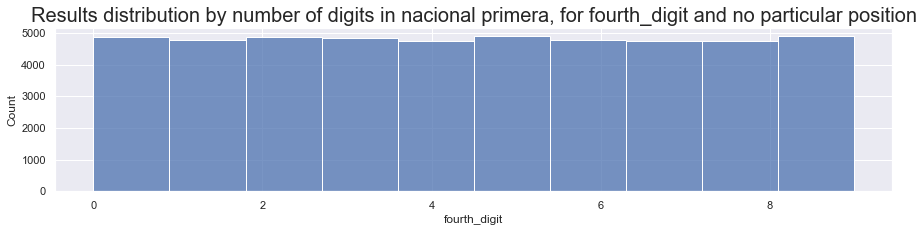

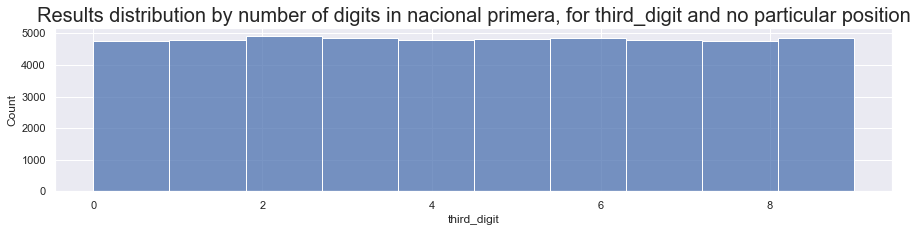

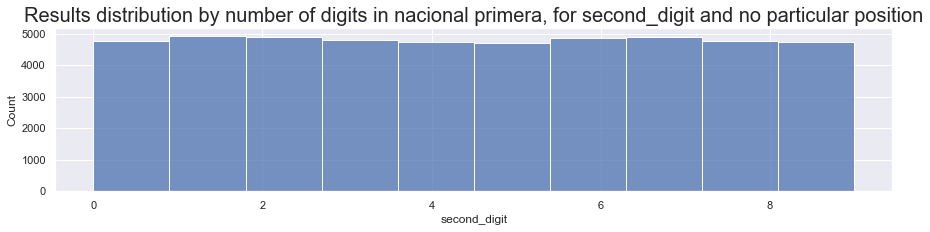

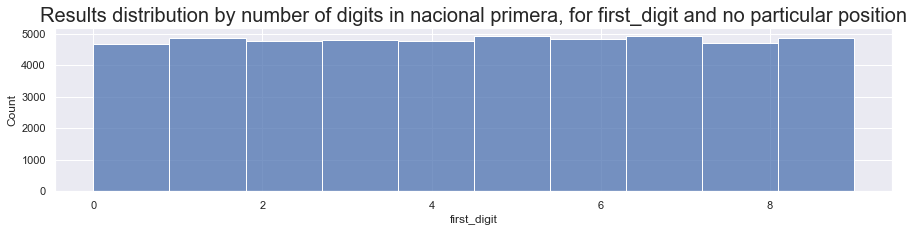

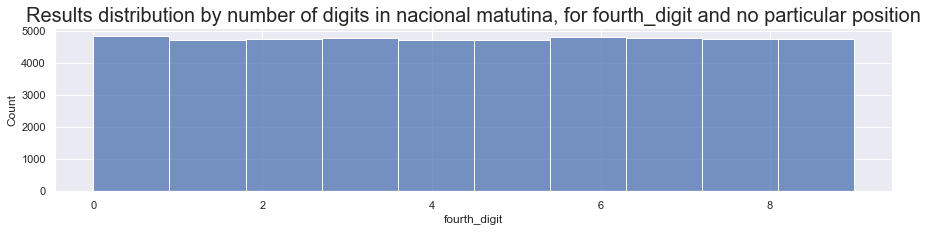

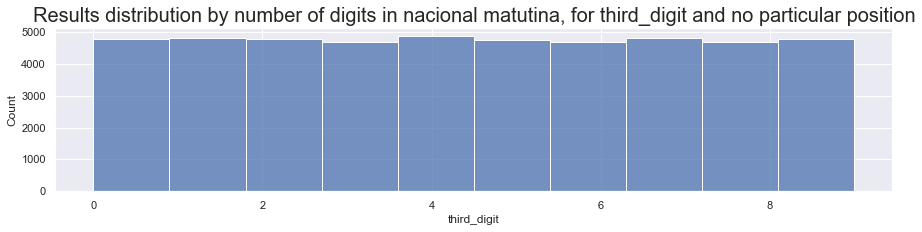

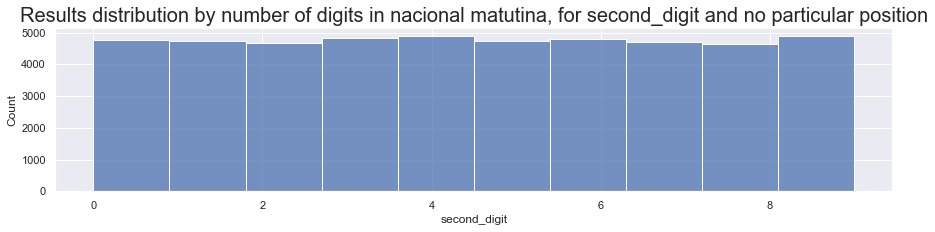

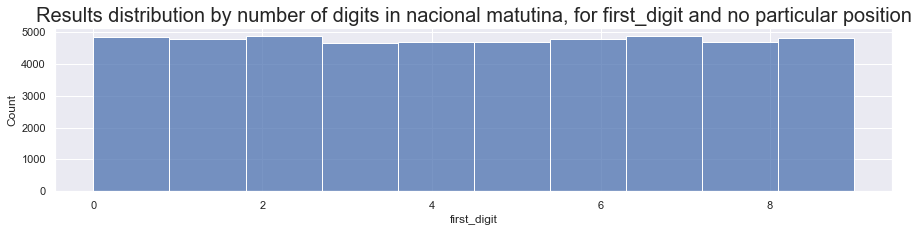

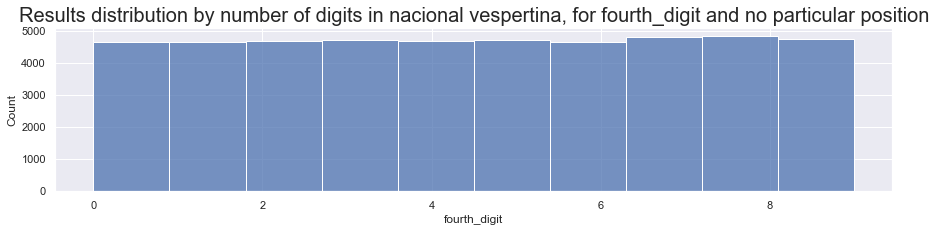

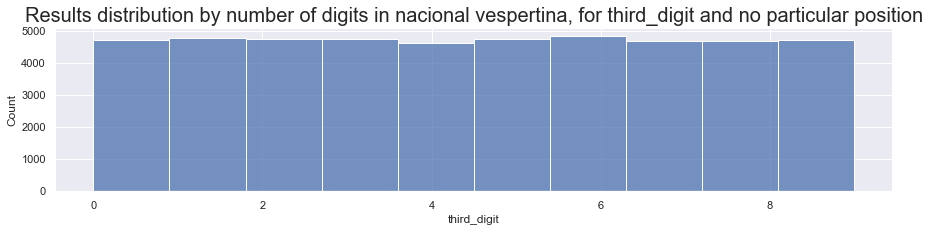

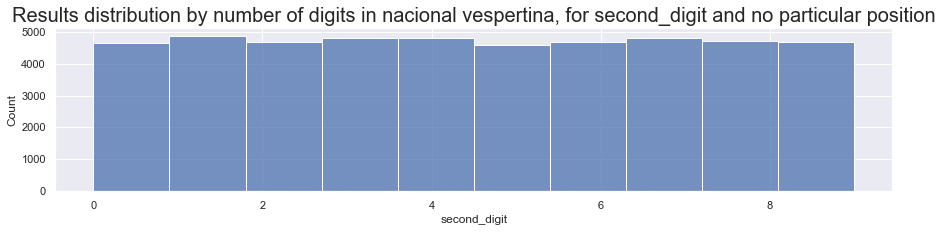

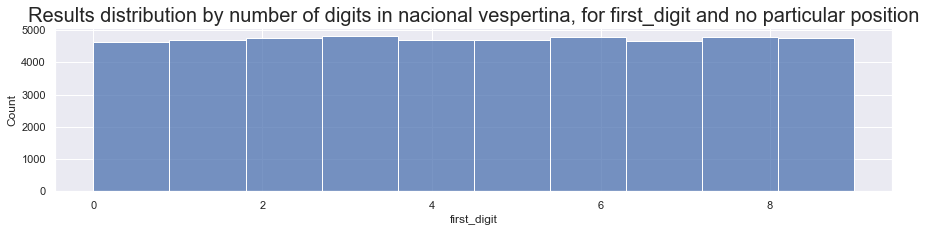

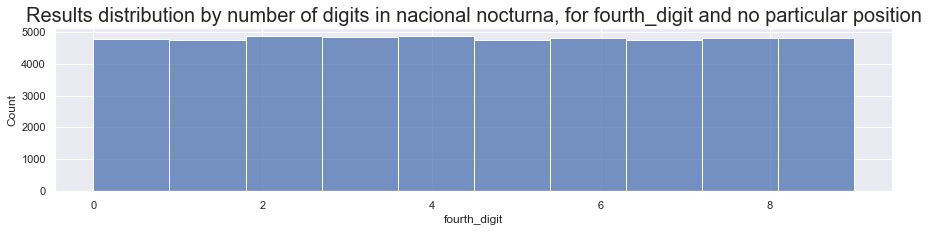

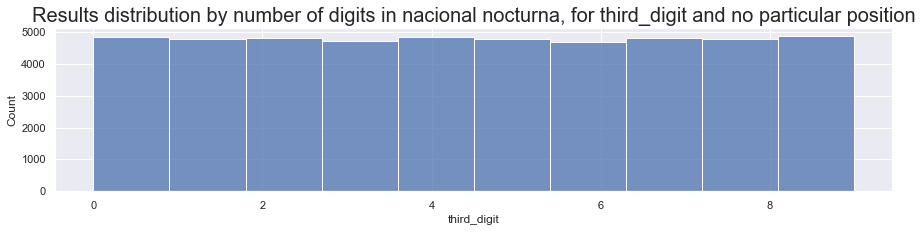

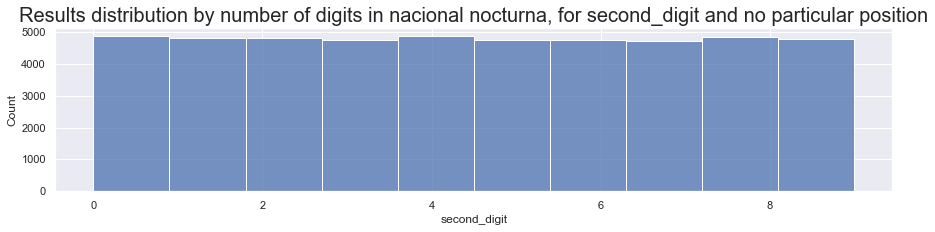

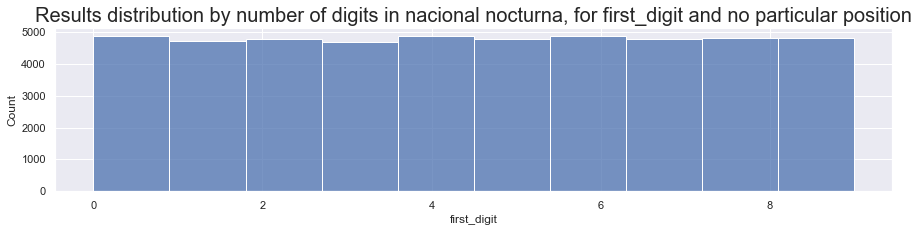

In [96]:
# Check the Quiniela's results distribution by periods
plot_period = 'primera'
display_distribution(plot_period, 'fourth_digit') # Total, no specific position
display_distribution(plot_period, 'third_digit') # Total, no specific position
display_distribution(plot_period, 'second_digit') # Total, no specific position
display_distribution(plot_period, 'first_digit') # Total, no specific position

plot_period = 'matutina'
display_distribution(plot_period, 'fourth_digit') # Total, no specific position
display_distribution(plot_period, 'third_digit') # Total, no specific position
display_distribution(plot_period, 'second_digit') # Total, no specific position
display_distribution(plot_period, 'first_digit') # Total, no specific position

plot_period = 'vespertina'
display_distribution(plot_period, 'fourth_digit') # Total, no specific position
display_distribution(plot_period, 'third_digit') # Total, no specific position
display_distribution(plot_period, 'second_digit') # Total, no specific position
display_distribution(plot_period, 'first_digit') # Total, no specific position

plot_period = 'nocturna'
display_distribution(plot_period, 'fourth_digit') # Total, no specific position
display_distribution(plot_period, 'third_digit') # Total, no specific position
display_distribution(plot_period, 'second_digit') # Total, no specific position
display_distribution(plot_period, 'first_digit') # Total, no specific position

In [97]:
# Get count of all values for each column (each of the digits), and stack the results in a single colum
column_totals = df_quiniela[['first_digit', 'second_digit', 'third_digit', 'fourth_digit']].apply(pd.Series.value_counts).stack()
# Get maximum and minimum amongst all value counts for all digits, and calculate the variance in percentage
max_variance = (column_totals.max() - column_totals.min()) / column_totals.min()
# Print the result in a nice format
print('Maximum variance between peaks for single digits occurrences is: {:.0%}'.format(max_variance)) 

Maximum variance between peaks for single digits occurrences is: 3%


<a id='individual_modes'>Check individual modes</a>

In [98]:
# Create a table, grouping by period and calculating the mode for each digit
df_quiniela.groupby(['period']).agg(
    digit_1_mode=('first_digit', lambda x: x.mode()),
    digit_2_mode=('second_digit', lambda x: x.mode()),
    digit_3_mode=('third_digit', lambda x: x.mode()),
    digit_4_mode=('fourth_digit', lambda x: x.mode())
)

digit_1_mode  digit_2_mode  digit_3_mode  digit_4_mode
period                                                            
matutina               2             4             4             0
nocturna               0             4             9             4
primera                5             1             2             9
vespertina             3             1             6             8

> *No clear dominant occurrence of a particular digit in different digit positions or periods.*<br>
> *(Largest occurrence is 4, representing 25% of the total occurrences)*

Addressing the following questions:

>- *What is the distribution of the results by digit groups, for the first two position groups, taking as example the 'primera' period?*<br>
>&emsp;Looking at more than one digit, distributions are multimodal, with larger variations for results in the first position.<br>
>
>- *What are the modes for the digits in each period, by position group?*<br>
>&emsp;See [position groups modes](#position_groups_modes).<br>

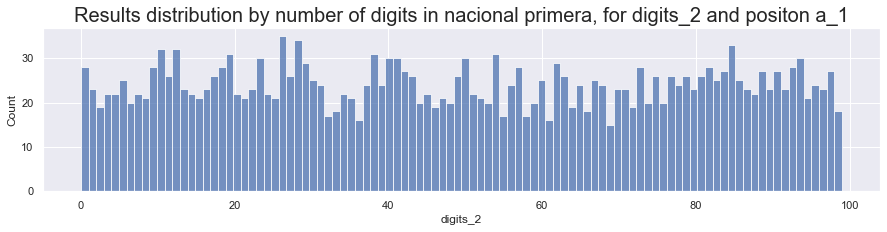

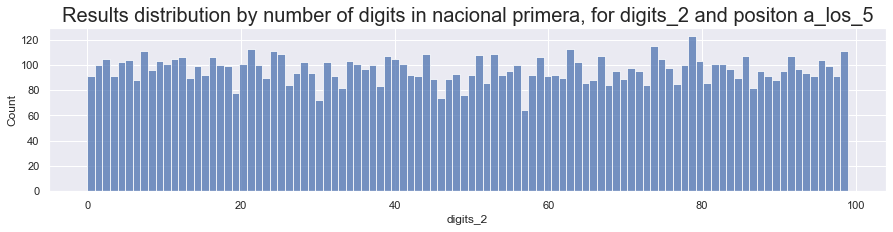

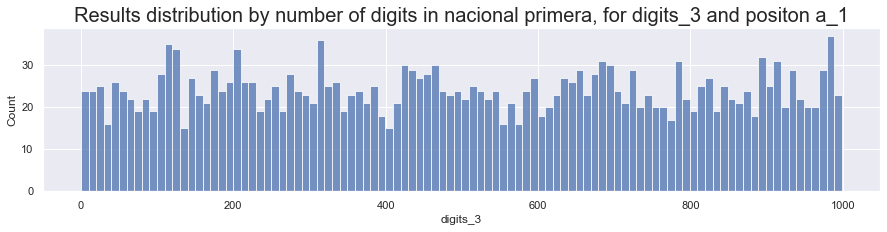

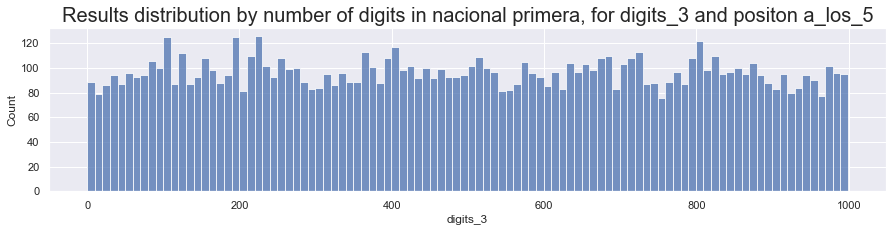

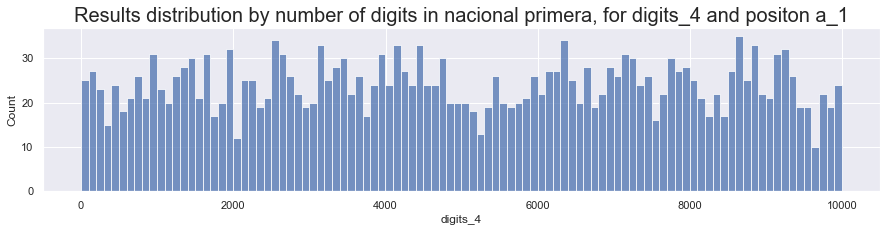

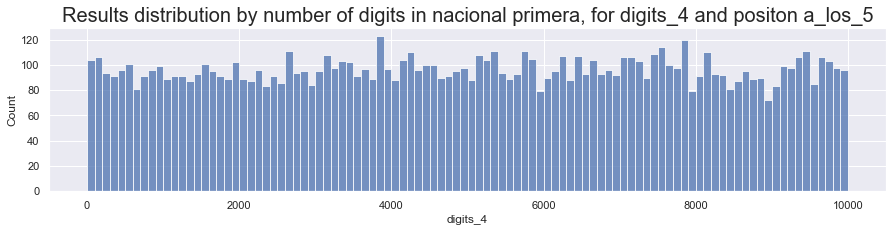

In [99]:
# Check the Quiniela's results distribution by position groups
plot_period = 'primera'
display_distribution(plot_period, 'digits_2', 'a_1')
display_distribution(plot_period, 'digits_2', 'a_los_5')
display_distribution(plot_period, 'digits_3', 'a_1')
display_distribution(plot_period, 'digits_3', 'a_los_5')
display_distribution(plot_period, 'digits_4', 'a_1')
display_distribution(plot_period, 'digits_4', 'a_los_5')

<a id='position_groups_modes'>Check modes by position group</a>

In [100]:
# Set width of columns to fit all values
pd.set_option('max_colwidth', None)
# Create a table, grouping by period and calculating the mode for each grouped digits, for the first position
df_quiniela[df_quiniela['position_group'] == 'a_1'].groupby(['position_group', 'period']).agg(
    # list() is used to avoid errors. Arrays are not supported as a response
    digit_2_mode=('digits_2', lambda x: list(x.mode())), 
    digit_3_mode=('digits_3', lambda x: list(x.mode())),
    digit_4_mode=('digits_4', lambda x: list(x.mode()))
)

digit_2_mode     digit_3_mode  \
position_group period                                     
a_1            matutina       [11, 44]       [544, 711]   
               nocturna           [41]       [427, 702]   
               primera            [26]  [585, 894, 931]   
               vespertina         [32]            [611]   

                                                                                                                                          digit_4_mode  
position_group period                                                                                                                                   
a_1            matutina    [231, 305, 738, 1334, 1754, 2179, 2188, 2344, 2946, 3699, 3959, 4371, 5126, 5470, 5546, 6140, 6307, 6934, 9458, 9711, 9782]  
               nocturna                                                                                                                         [1858]  
               primera                                                                                                                          [1674]  
               vespertina                                                                                                                 [6602, 8899]

> *Since results are always a 4 digit 'number' for each position, and modes are not repeated in groups with lesser digits, we can assume that there is no one result that has been drawned significantly more than the others.*
>
> *For example, if '1234' would have been the most drawn number overall, mode for 3 digits should have been '234' and mode for 2 digits, '34'.*

### Add day, day of the week, and month
This new features will allow us to analyze occurrences by calendar day, the day of the week, and also by month

In [101]:
# Add -calendar- day
df_quiniela['calendar_day'] = df_quiniela['lottery_date'].apply(lambda x: int(x.strftime('%d')))
# Add day of the week - Monday is 0 and Sunday is 6
df_quiniela['day_of_week'] = df_quiniela['lottery_date'].apply(lambda x: int(x.weekday()))
# Add month
df_quiniela['month'] = df_quiniela['lottery_date'].apply(lambda x: int(x.strftime('%m')))

df_quiniela.head()

lottery_date  quiniela   period  position result  digits_4  digits_3  \
0   2014-11-01  nacional  primera         1   3940      3940       940   
1   2014-11-01  nacional  primera         2   6857      6857       857   
2   2014-11-01  nacional  primera         3   0609       609       609   
3   2014-11-01  nacional  primera         4   8018      8018        18   
4   2014-11-01  nacional  primera         5   3232      3232       232   

   digits_2  first_digit  second_digit  third_digit  fourth_digit  \
0        40            3             9            4             0   
1        57            6             8            5             7   
2         9            0             6            0             9   
3        18            8             0            1             8   
4        32            3             2            3             2   

  position_group  calendar_day  day_of_week  month  
0            a_1             1            5     11  
1        a_los_5             1            5     11  
2        a_los_5             1            5     11  
3        a_los_5             1            5     11  
4        a_los_5             1            5     11

### Check distributions and statistics

In [102]:
# Create a function to display distributions by the different days of the week, taking the dataframe, the number column, period (optional), and position (optional) as input
def display_occurrences_in_time(df_in, number_in, period_in='', position_in=''):

    # Determine the title text to be displayed, depending on what -if any- position group and period are passed as an argument
    position_string = ('positon ' + position_in) if position_in != '' else 'no particular position'
    period_string = period_in if period_in != '' else 'for all periods'

    # Create 6 subplots (3 rows by 2 columns), one for each day of the week
    fig, ax = plt.subplots(3,2, figsize=(30,15))
    plt.subplots_adjust(top=1.1)

    # Define the title of the chart, based on the selections, to make it descriptive of what you are looking at
    plt.suptitle('Results distribution by number of digits in {} {}, for {} and {}'.format(quiniela_name, period_string, number_in, position_string), fontsize=20, y=1.2)

    # Create a temporary dataframe, filtering by the period and position group passed as an argument to the function -if any-
    df_temp = (
        df_in[
            (df_in['period'] == period_in if period_in != '' else df_in['period']) 
            & (df_in['position_group'] == position_in if position_in != '' else df_in['position_group'])
            ].sort_values(by=number_in)
        ) if ((period_in != '') & (position_in != '')) else df_in

    # Change the number of bins based on number of digits: 100 if it is more than 1, 10 if it is one digit
    bin_number = 100 if 'digits' in number_in else 10

    # Filter and create dataframes for each day of the week
    df_mon = df_temp[df_temp['day_of_week'] == 0]
    df_tue = df_temp[df_temp['day_of_week'] == 1]
    df_wed = df_temp[df_temp['day_of_week'] == 2]
    df_thu = df_temp[df_temp['day_of_week'] == 3]
    df_fri = df_temp[df_temp['day_of_week'] == 4]
    df_sat = df_temp[df_temp['day_of_week'] == 5]

    # Create the histograms for the selections and for each day
    sns.histplot(data=df_mon, x=df_mon[number_in], bins=bin_number, ax=ax[0,0]).set(title='Monday', xlabel=None)
    sns.histplot(data=df_tue, x=df_tue[number_in], bins=bin_number, ax=ax[0,1]).set(title='Tuesday', xlabel=None)
    sns.histplot(data=df_wed, x=df_wed[number_in], bins=bin_number, ax=ax[1,0]).set(title='Wednesday', xlabel=None)
    sns.histplot(data=df_thu, x=df_thu[number_in], bins=bin_number, ax=ax[1,1]).set(title='Thursday', xlabel=None)
    sns.histplot(data=df_fri, x=df_fri[number_in], bins=bin_number, ax=ax[2,0]).set(title='Friday', xlabel=None)
    sns.histplot(data=df_sat, x=df_sat[number_in], bins=bin_number, ax=ax[2,1]).set(title='Saturday', xlabel=None)

    return plt.show()

Addressing the following questions:

>- *What is the distribution, by day of the week, of the results by digit groups (2 and 3 digits), for the first position, taking as example the 'primera' period?*<br>
>&emsp;Distributions are multimodal.<br>
>
>- *What are the modes for the digits in each period, by position group and day of the week?*<br>
>&emsp;See [modes by the day of the week](#day_of_week_modes).<br>

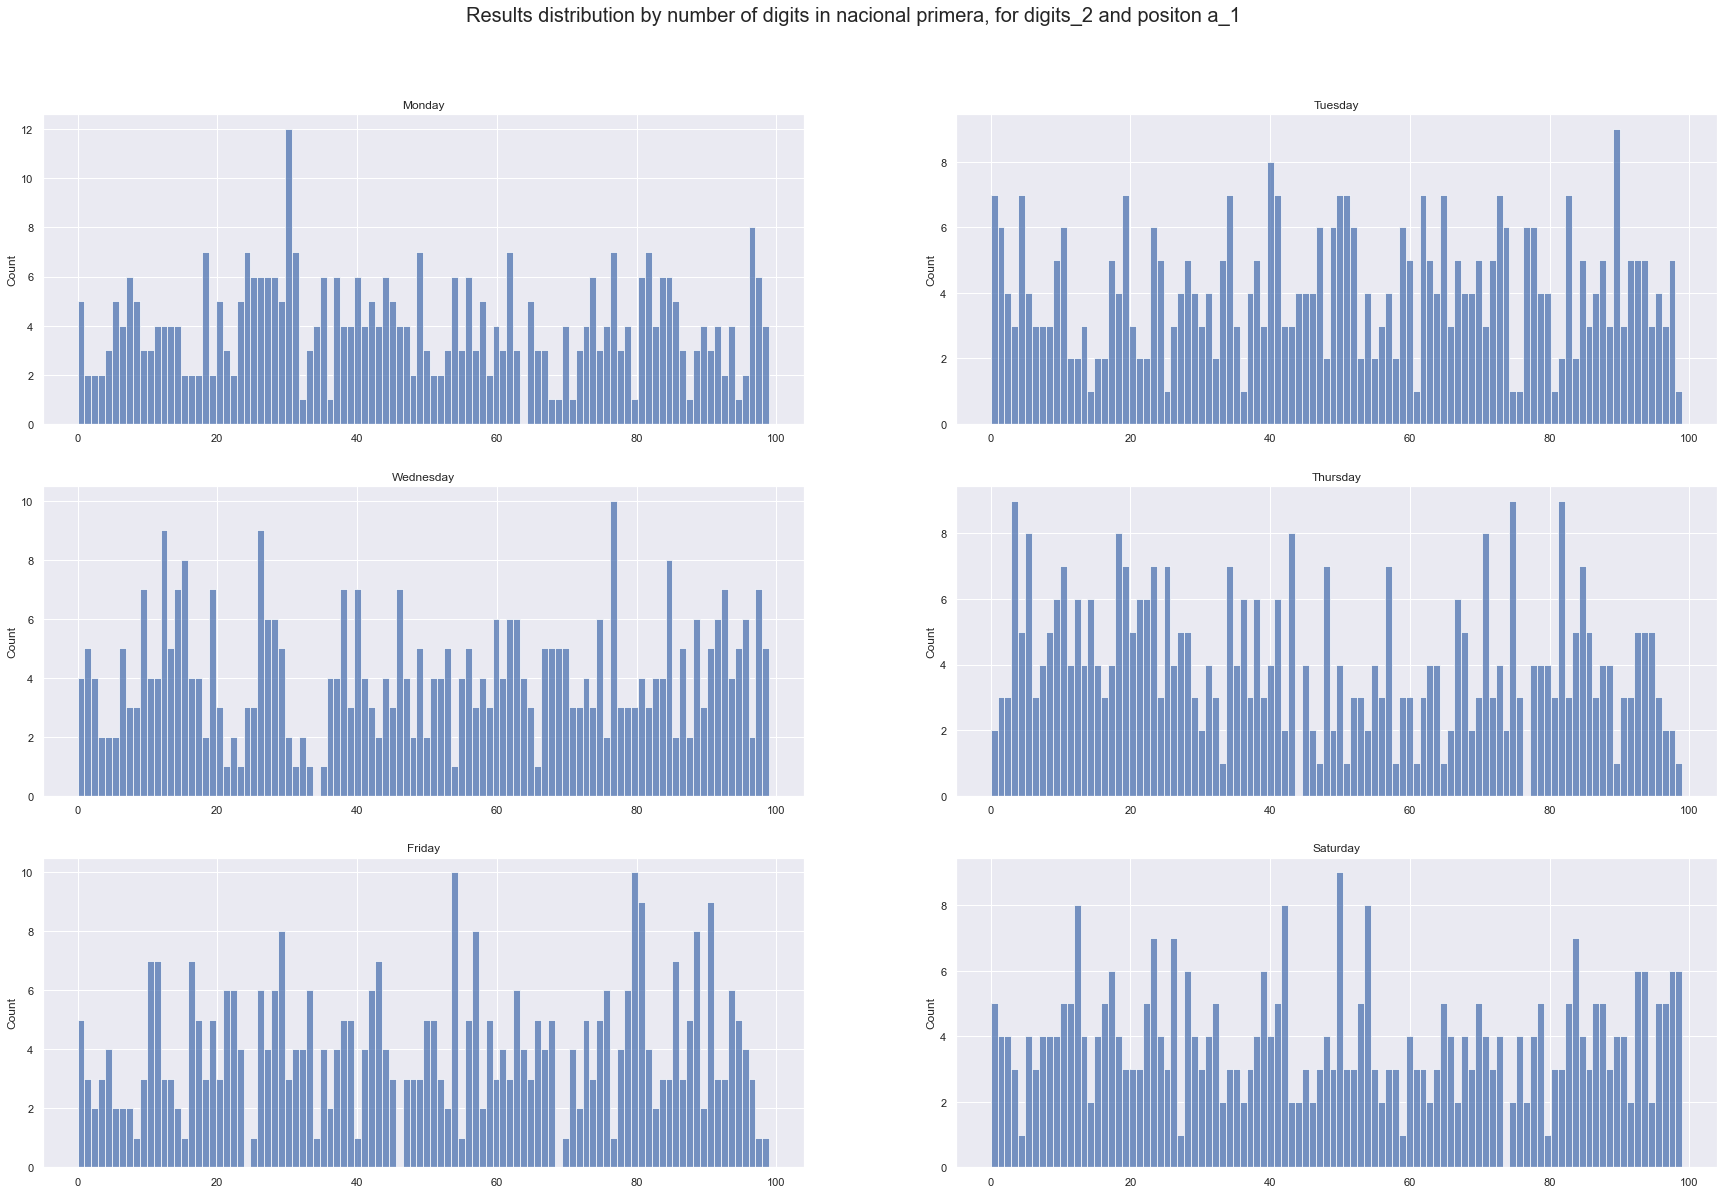

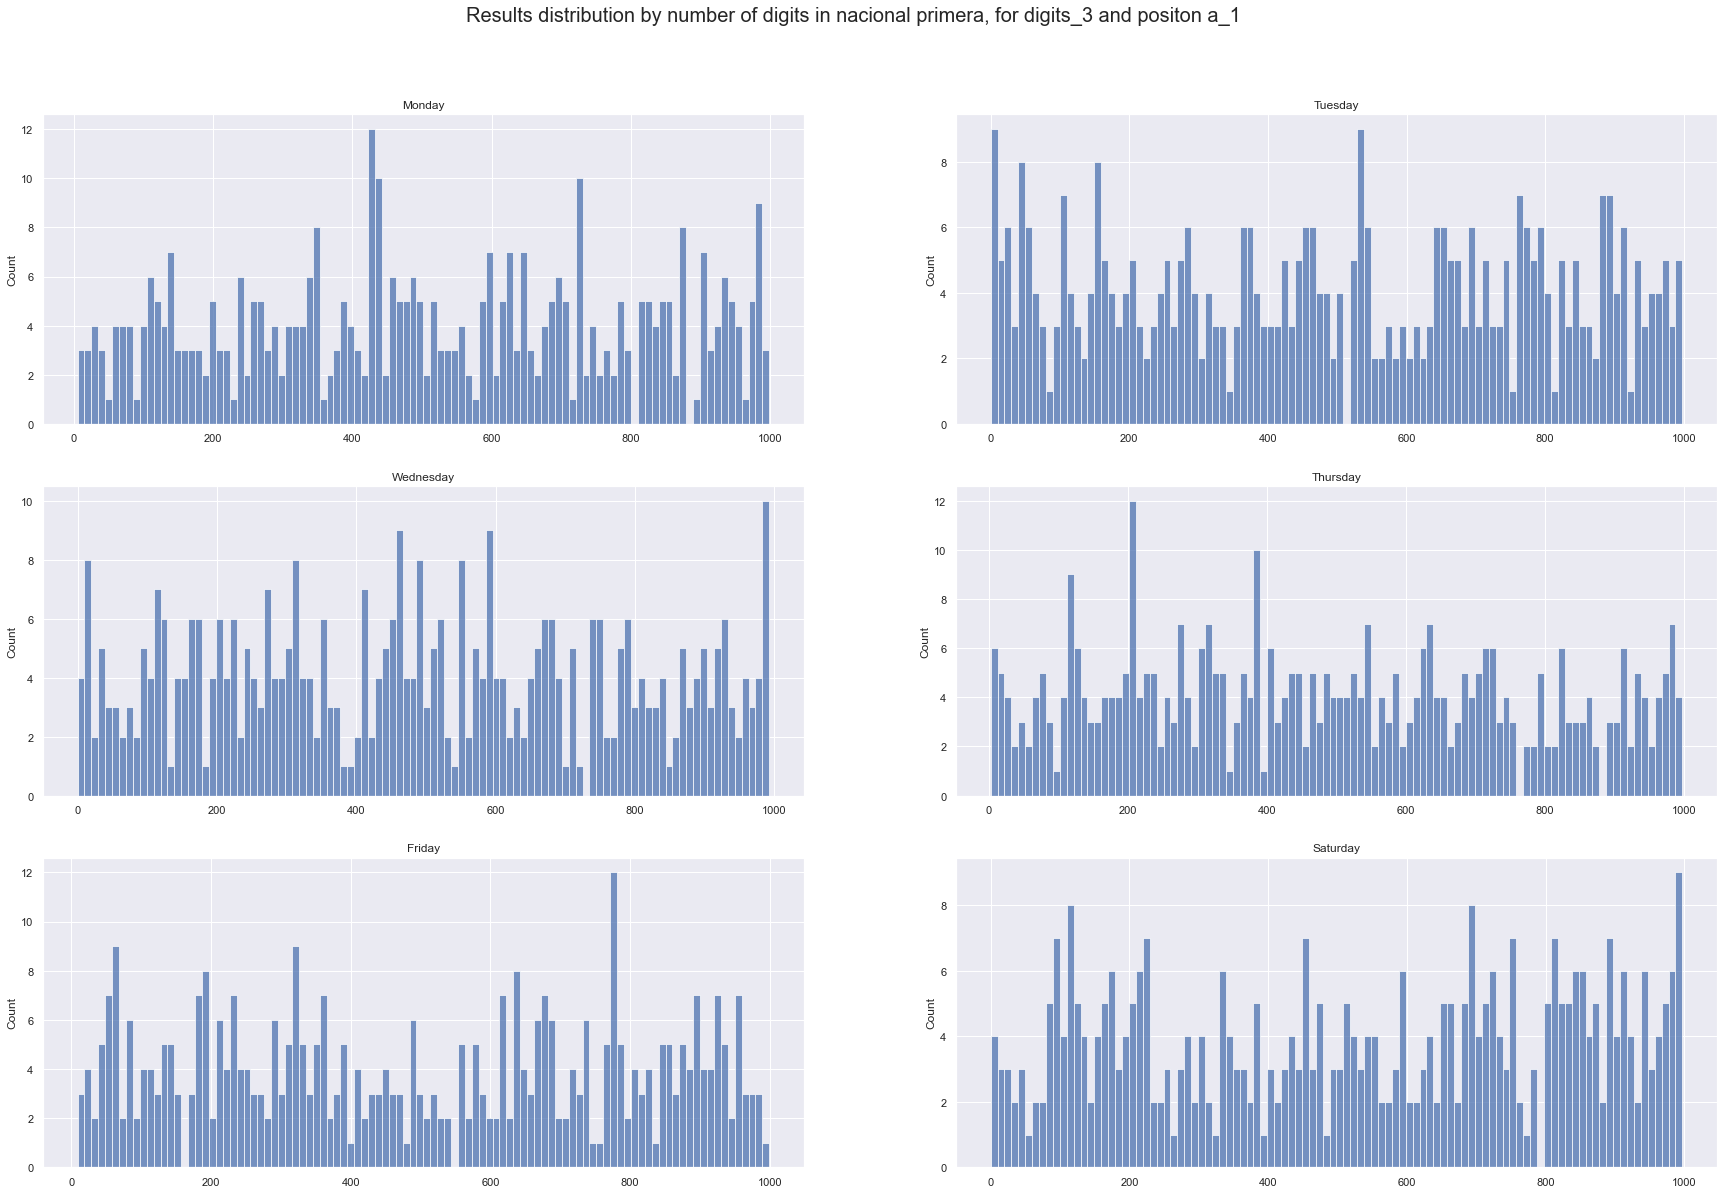

In [103]:
# Check distributions for 2 and 3 digits, at the first position, by the day of the week
display_occurrences_in_time(df_quiniela, 'digits_2', 'primera', 'a_1')
display_occurrences_in_time(df_quiniela, 'digits_3', 'primera', 'a_1')

Addressing the following question:

>- *What is the distribution of the results by digit groups (2 digits), for the first position, taking as example the 'vespertina' period?*<br>
>&emsp;Distributions are multimodal.<br>

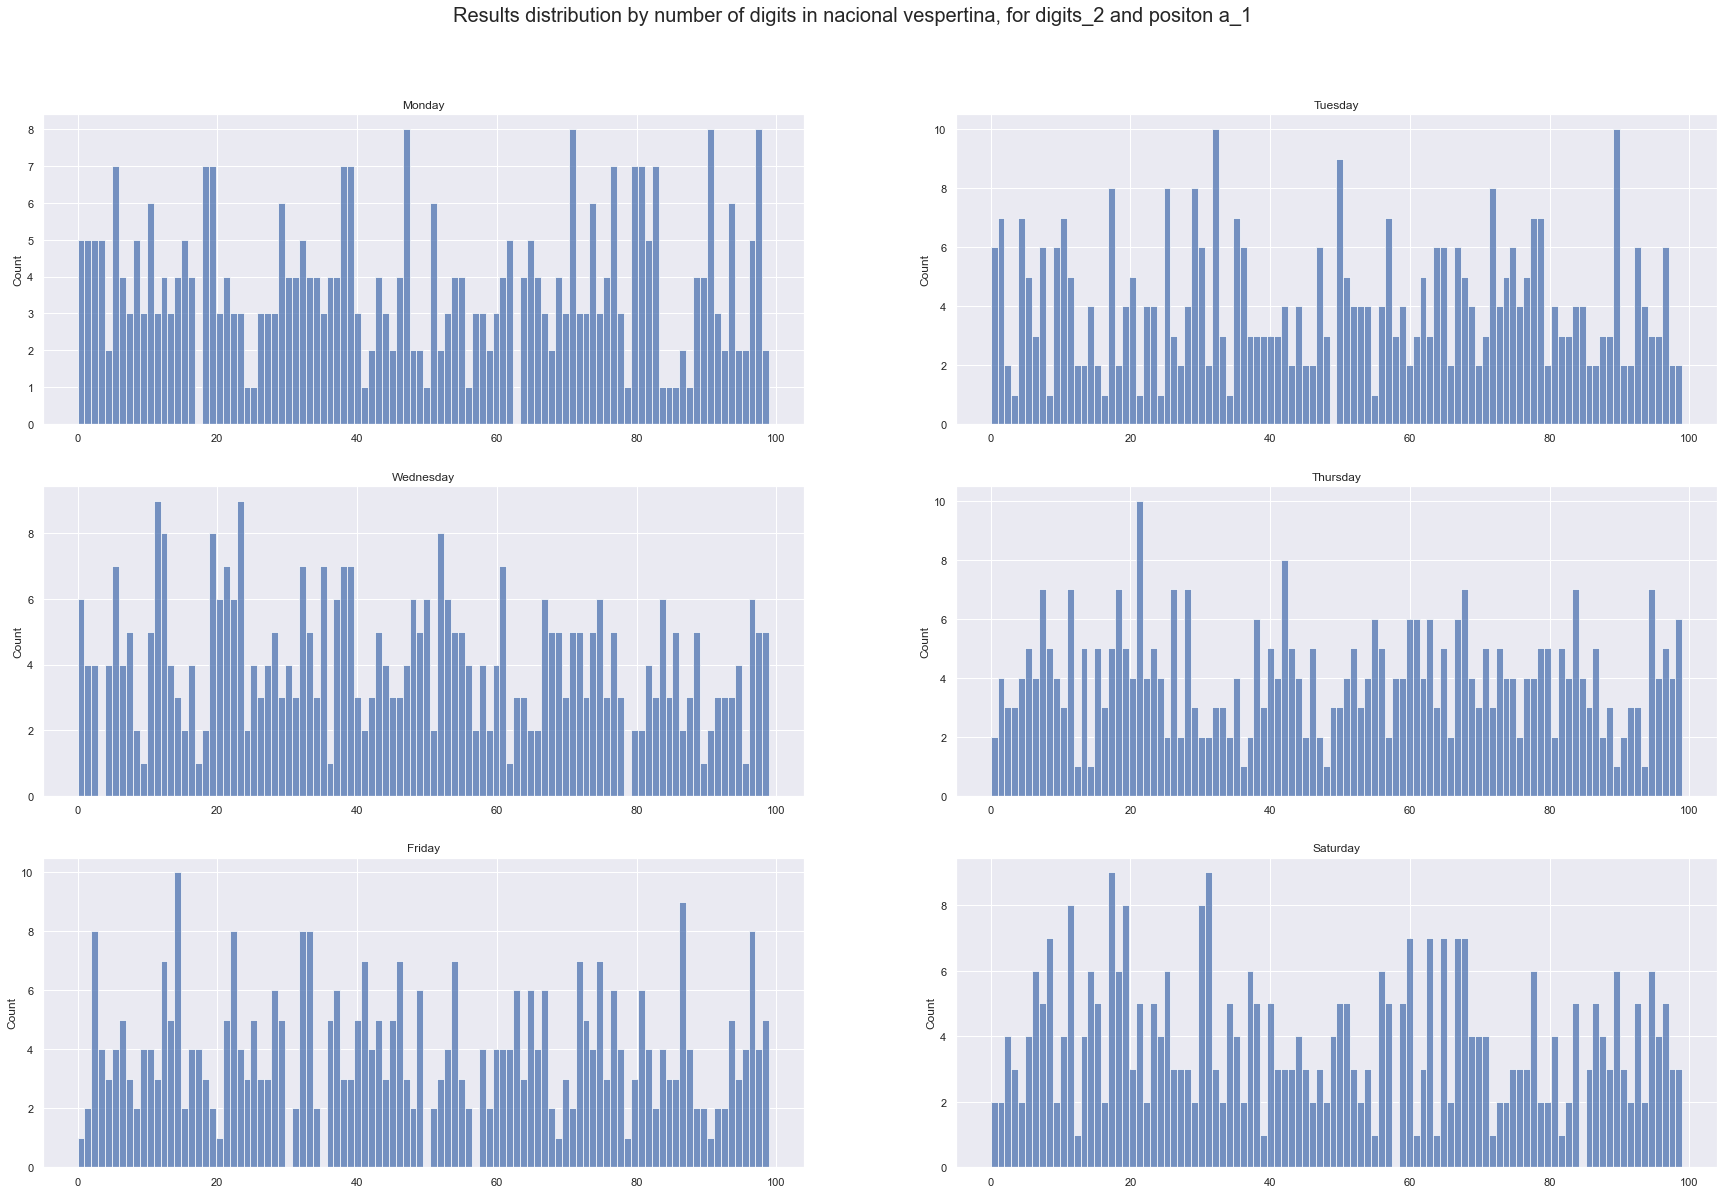

In [104]:
# Check distributions for 2 digits, at the first position, by the day of the week
display_occurrences_in_time(df_quiniela, 'digits_2', 'vespertina', 'a_1')

<a id='day_of_week_modes'>Check modes by the day of the week</a>

In [105]:
# Create a function to compare if modes from a certain group of digits, are also included in the following group (i.e., 2 digits in the 3 digits columns, and so on)
def check_modes(df_in, digit_2_mode_in, digit_3_mode_in, digit_4_mode_in):

    # Iterate through all the rows in the dataframe
    for index, row in df_in.iterrows():

        # Set counters to record occurrences of matches between the different columns
        count_2_3 = 0
        count_2_3_4 = 0
        count_3_4 = 0

        # If a number is also contained in the next digit column, add 1. For example, if 51 (2 digits) is contained in 251 (3 digits); and, if 251 (3 digits) is contained in 4251 (4 digits).
        for d_2 in row[digit_2_mode_in]:
            for d_3 in row[digit_3_mode_in]:
                if str(d_2) == str(d_3)[-2:]:
                    count_2_3 += 1 # Add 1, stating that the 2 digit number, was found in the 3 digit column, as the most right figures
                    for d_4 in row[digit_4_mode_in]:
                        if str(d_3) == str(d_4)[-3:]:
                            count_2_3_4 += 1 # Add 1, stating that the 2 digit number, was found in the 3 digit column and, also, that this 3 digit number, was found in the 4 digit column, as the most right figures
        
        for d_3 in row[digit_3_mode_in]:
            for d_4 in row[digit_4_mode_in]:
                        if str(d_3) == str(d_4)[-3:]:
                            count_3_4 += 1 # Add 1, stating that the 3 digit number, was found in the 4 digit column, as the most right figures
        
        # Add total matches found to the respective columns
        df_in.loc[index, '2&3'] = count_2_3
        df_in.loc[index, '2&3&4'] = count_2_3_4
        df_in.loc[index, '3&4'] = count_3_4

    return df_in

In [106]:
# Set width of columns to fit all values
pd.set_option('max_colwidth', None)
# Create a table, grouping by period and calculating the mode for each grouped digits, for the first position
df_modes = df_quiniela[df_quiniela['position_group'] == 'a_1'].groupby(['position_group', 'period', 'day_of_week']).agg(
    # list() is used to avoid errors. Arrays are not supported as a response
    digit_2_mode=('digits_2', lambda x: list(x.mode())), 
    digit_3_mode=('digits_3', lambda x: list(x.mode())),
    digit_4_mode=('digits_4', lambda x: list(x.mode()))
)

In [107]:
# Create a table, displaying the modes for each of the digit groups, and the matches found between these modes, in the different columns of the table
check_modes(df_modes, 'digit_2_mode', 'digit_3_mode', 'digit_4_mode')

digit_2_mode  \
position_group period     day_of_week                     
a_1            matutina   0                        [71]   
                          1                        [11]   
                          2                        [18]   
                          3                    [44, 58]   
                          4                     [3, 11]   
                          5                        [12]   
               nocturna   0              [3, 5, 32, 71]   
                          1                        [96]   
                          2                        [64]   
                          3                        [29]   
                          4                    [41, 98]   
                          5                    [41, 59]   
               primera    0                        [30]   
                          1                        [90]   
                          2                        [77]   
                          3                 [3, 75, 82]   
                          4                    [54, 80]   
                          5                        [50]   
               vespertina 0            [47, 71, 91, 98]   
                          1                    [32, 90]   
                          2                    [11, 23]   
                          3                        [21]   
                          4                        [14]   
                          5                    [17, 31]   

                                                                       digit_3_mode  \
position_group period     day_of_week                                                 
a_1            matutina   0                                                   [171]   
                          1                                                   [496]   
                          2                                         [204, 612, 946]   
                          3             [5, 172, 188, 348, 439, 458, 511, 709, 980]   
                          4            [93, 217, 218, 308, 348, 544, 636, 654, 737]   
                          5                [189, 453, 565, 610, 694, 706, 725, 810]   
               nocturna   0                                                   [703]   
                          1                                                   [294]   
                          2                                                   [711]   
                          3                                                   [215]   
                          4                           [86, 155, 204, 331, 441, 869]   
                          5                                                   [259]   
               primera    0                                         [430, 877, 908]   
                          1                                [17, 200, 250, 460, 952]   
                          2                [226, 315, 328, 455, 496, 592, 785, 993]   
                          3                     [194, 203, 314, 323, 585, 696, 967]   
                          4                                              [781, 894]   
                          5                                                   [750]   
               vespertina 0                                                   [283]   
                          1                      [57, 336, 517, 647, 690, 917, 978]   
                          2                                                    [11]   
                          3                                                   [555]   
                          4                                               [45, 614]   
                          5                                                   [425]   

                                                                                                 digit_4_mode  \
position_group period     day_of_week                                                                           
a_1            matu

> *There are certain days in which a particular mode is predominant as the result, however, these are few, not significant occurrences.<br>*
>
> *No clear conclusion can be drawn as to whether or not there is a pattern in the occurrence of certain results.*

Addressing the following question:

> - *Focusing on 2 digit results, what is the distribution of modes, for the first position, between days of the week?*<br>
> Monday and Tuesday are modal, and the rest of the days uniform. Seems like there is a higher probability of obtaining a 71 on Mondays and a 90 on Tuesday, than the rest of the numbers.

In [108]:
# Create a temporary dataframe to include all modes for 2 digit values occurring at a specific day of the week
df_temp_2_digits = pd.DataFrame(columns=['day_of_week', 'digits_2_mode'])

# Create an index counter to generate autoincremental values for each row index
index_number = 0

# Iterate through the 'modes dataframe'
for index, row in df_modes.iterrows():

    # Add all modes and the day of the week to the new dataframe
    for number in row['digit_2_mode']:
        df_temp_2_digits.loc[index_number] = [index[2], number]
        index_number += 1

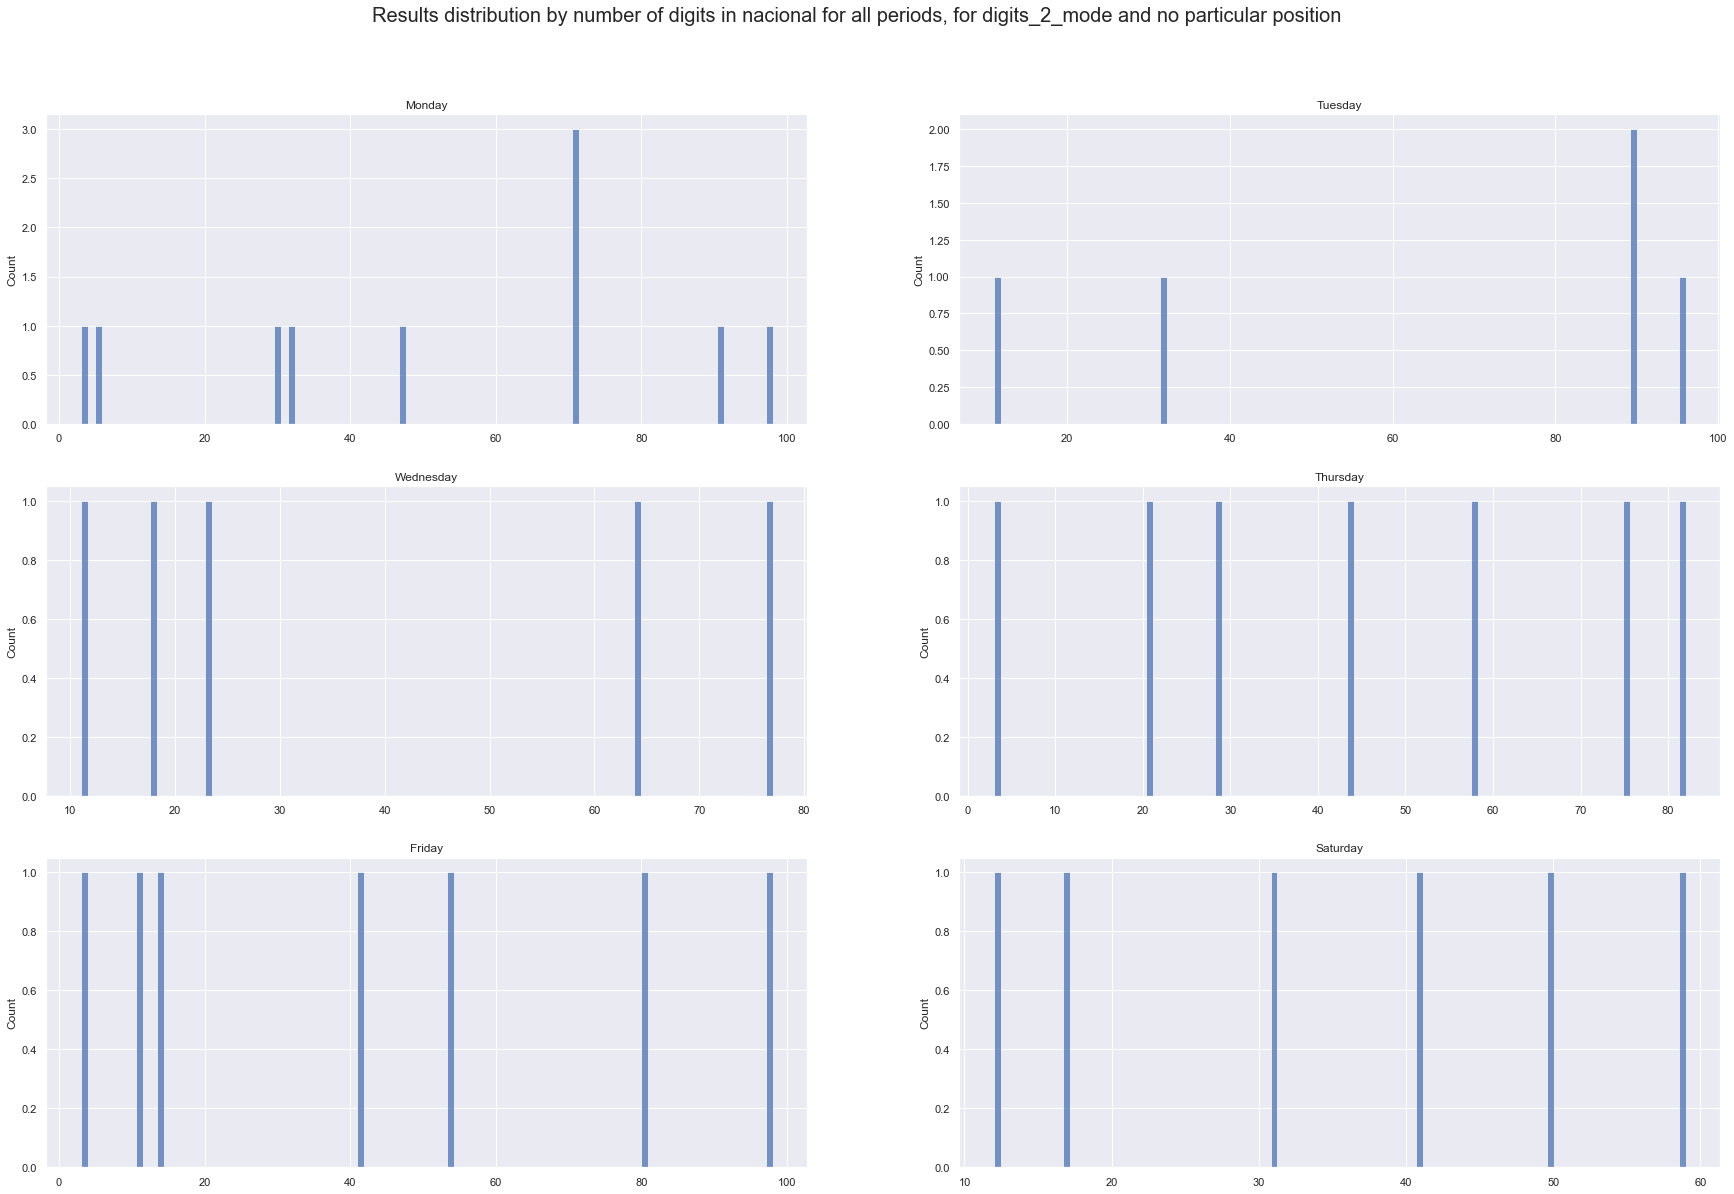

In [109]:
# Check distributions for 2 digit modes by the day of the week
display_occurrences_in_time(df_temp_2_digits, 'digits_2_mode')

Addressing the following questions:

>- *What is the frequency of the 2 digits results, by different periods, focusing only in the first position group?*<br>
>&emsp;No pattern can be visually identified, frequency variation is not significant between different numbers.<br>

In [110]:
# Create a function to plot in a scatter plot, time on the X axis and results on the Y axis, modifying the size of markers according to the results frequency
# The function is created to filter by the first position group
def plot_scatter(df_in, x_axis_in, y_axis_in, period_in=''):

    # Filter dataframe based on period -if any-
    if period_in != '':
        df_temp = df_quiniela[
            (df_quiniela['period'] == period_in) & 
            (df_quiniela['position_group'] == "a_1")
            ]
    else:
        df_temp = df_quiniela[df_quiniela['position_group'] == "a_1"]

    # Count and store the number of occurrences of each 2 digit number
    digits_count = df_temp.groupby([y_axis_in, x_axis_in]).size().reset_index(name='frequency')

    # Create a scatter plot for the data
    sns.relplot(x=x_axis_in, y=y_axis_in, size=digits_count['frequency'], sizes=(50,1000), data=digits_count, height=20, aspect=2, alpha=0.5)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

    return plt.show()


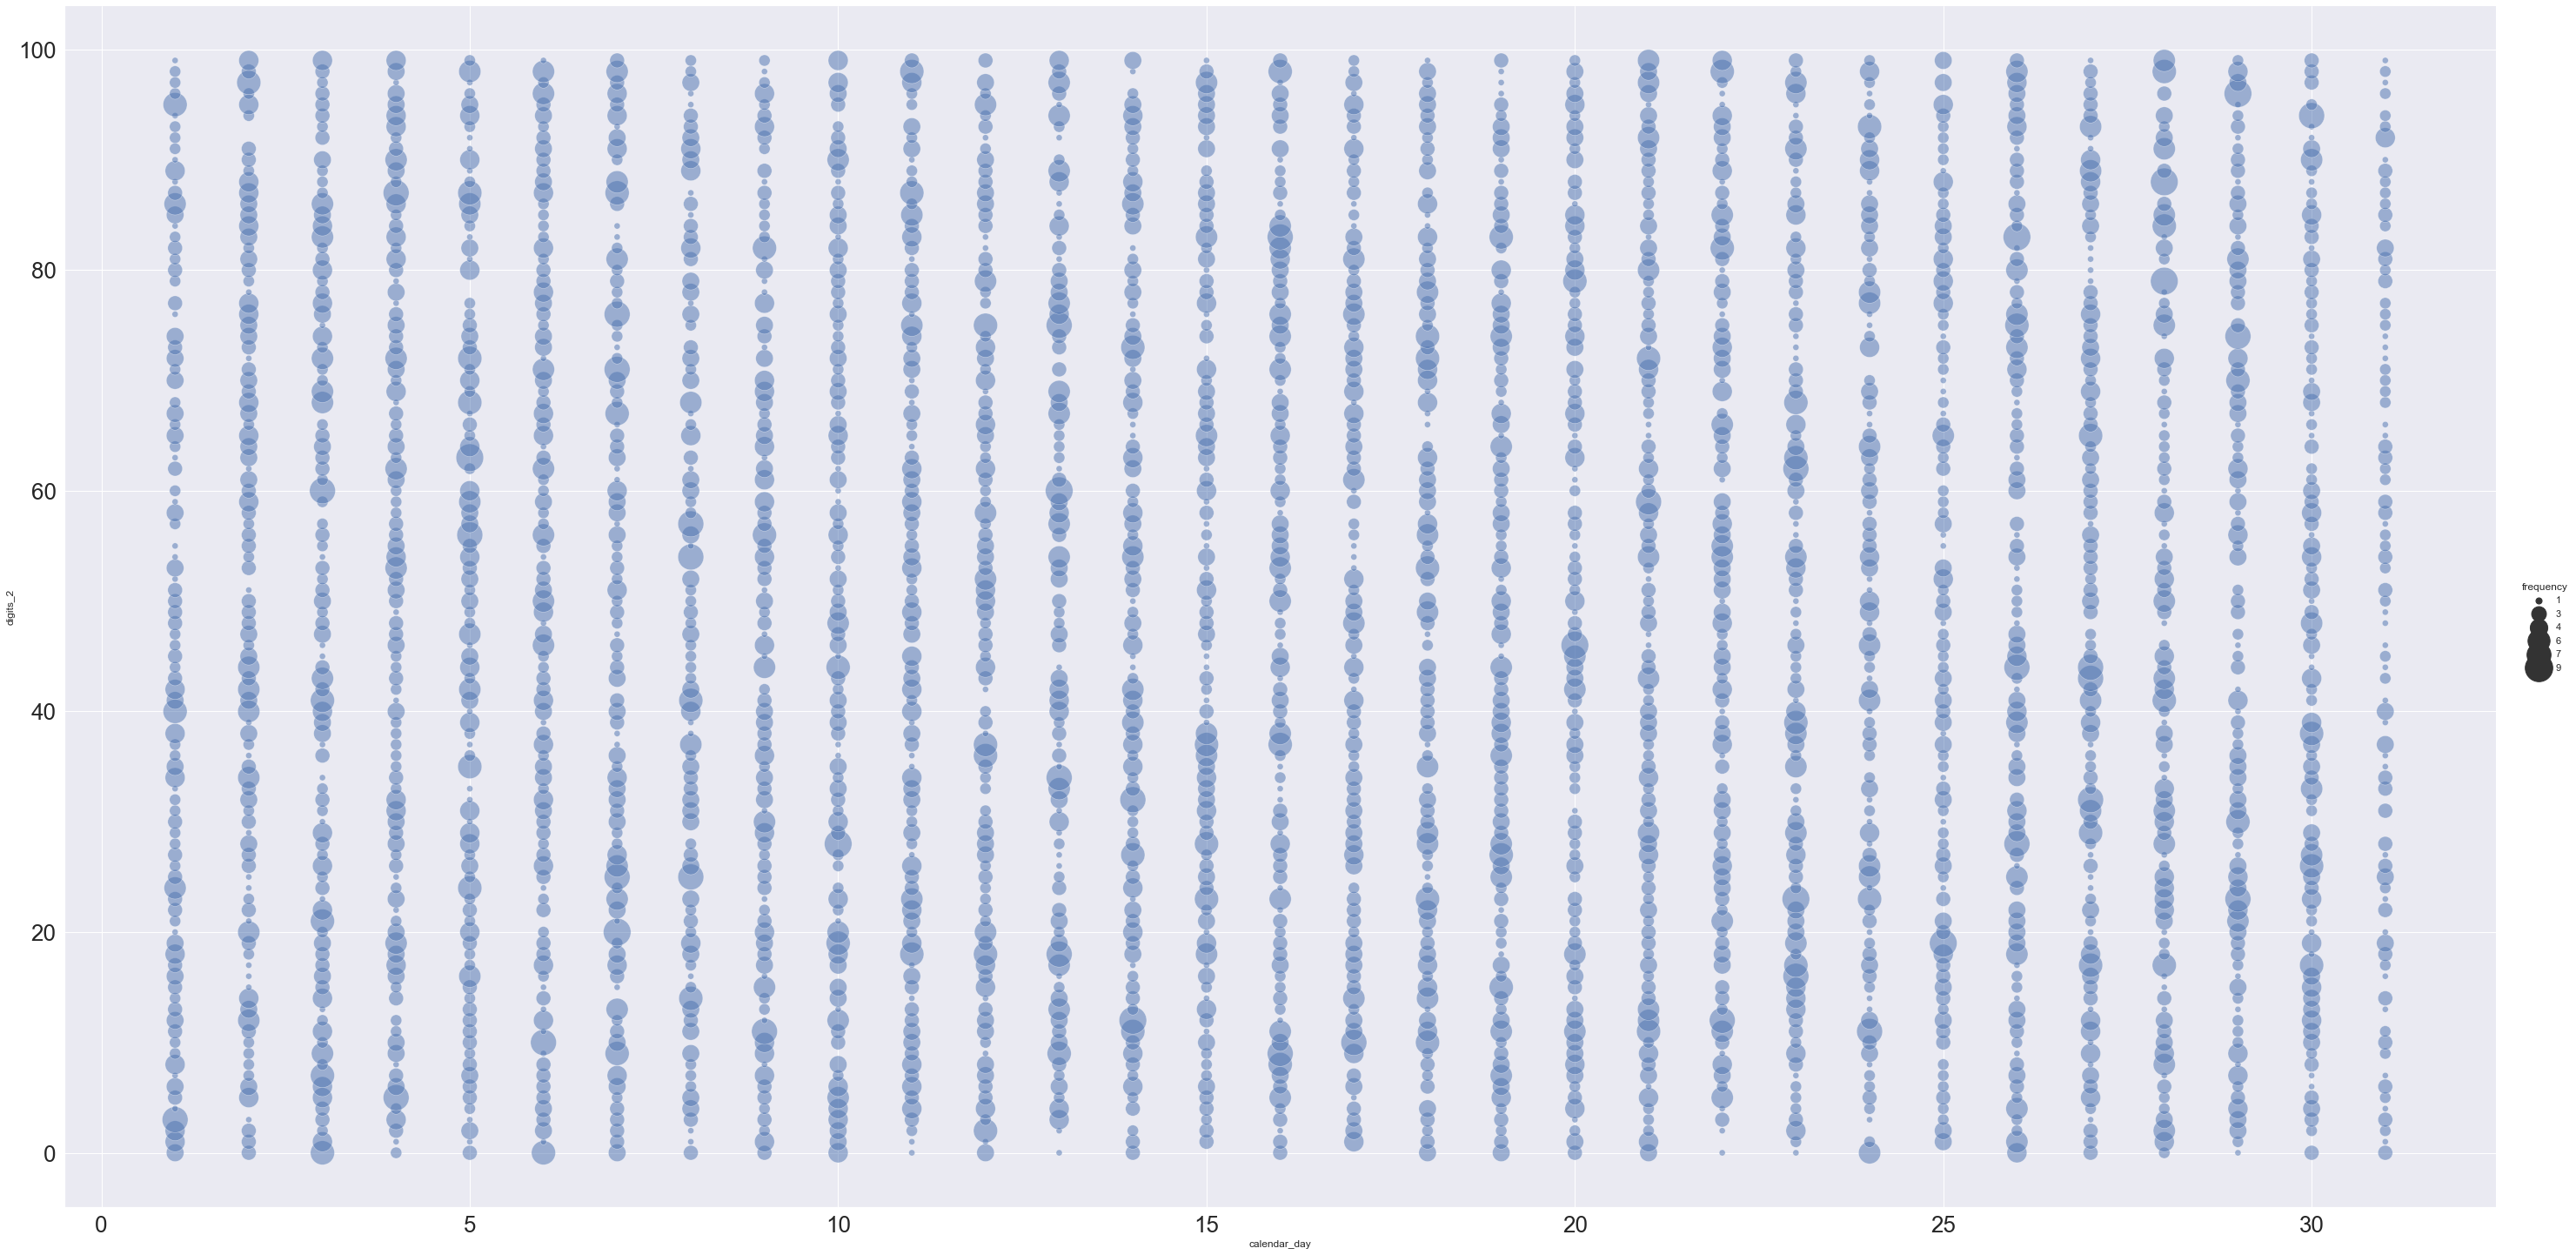

In [111]:
plot_scatter(df_quiniela, 'calendar_day', 'digits_2')

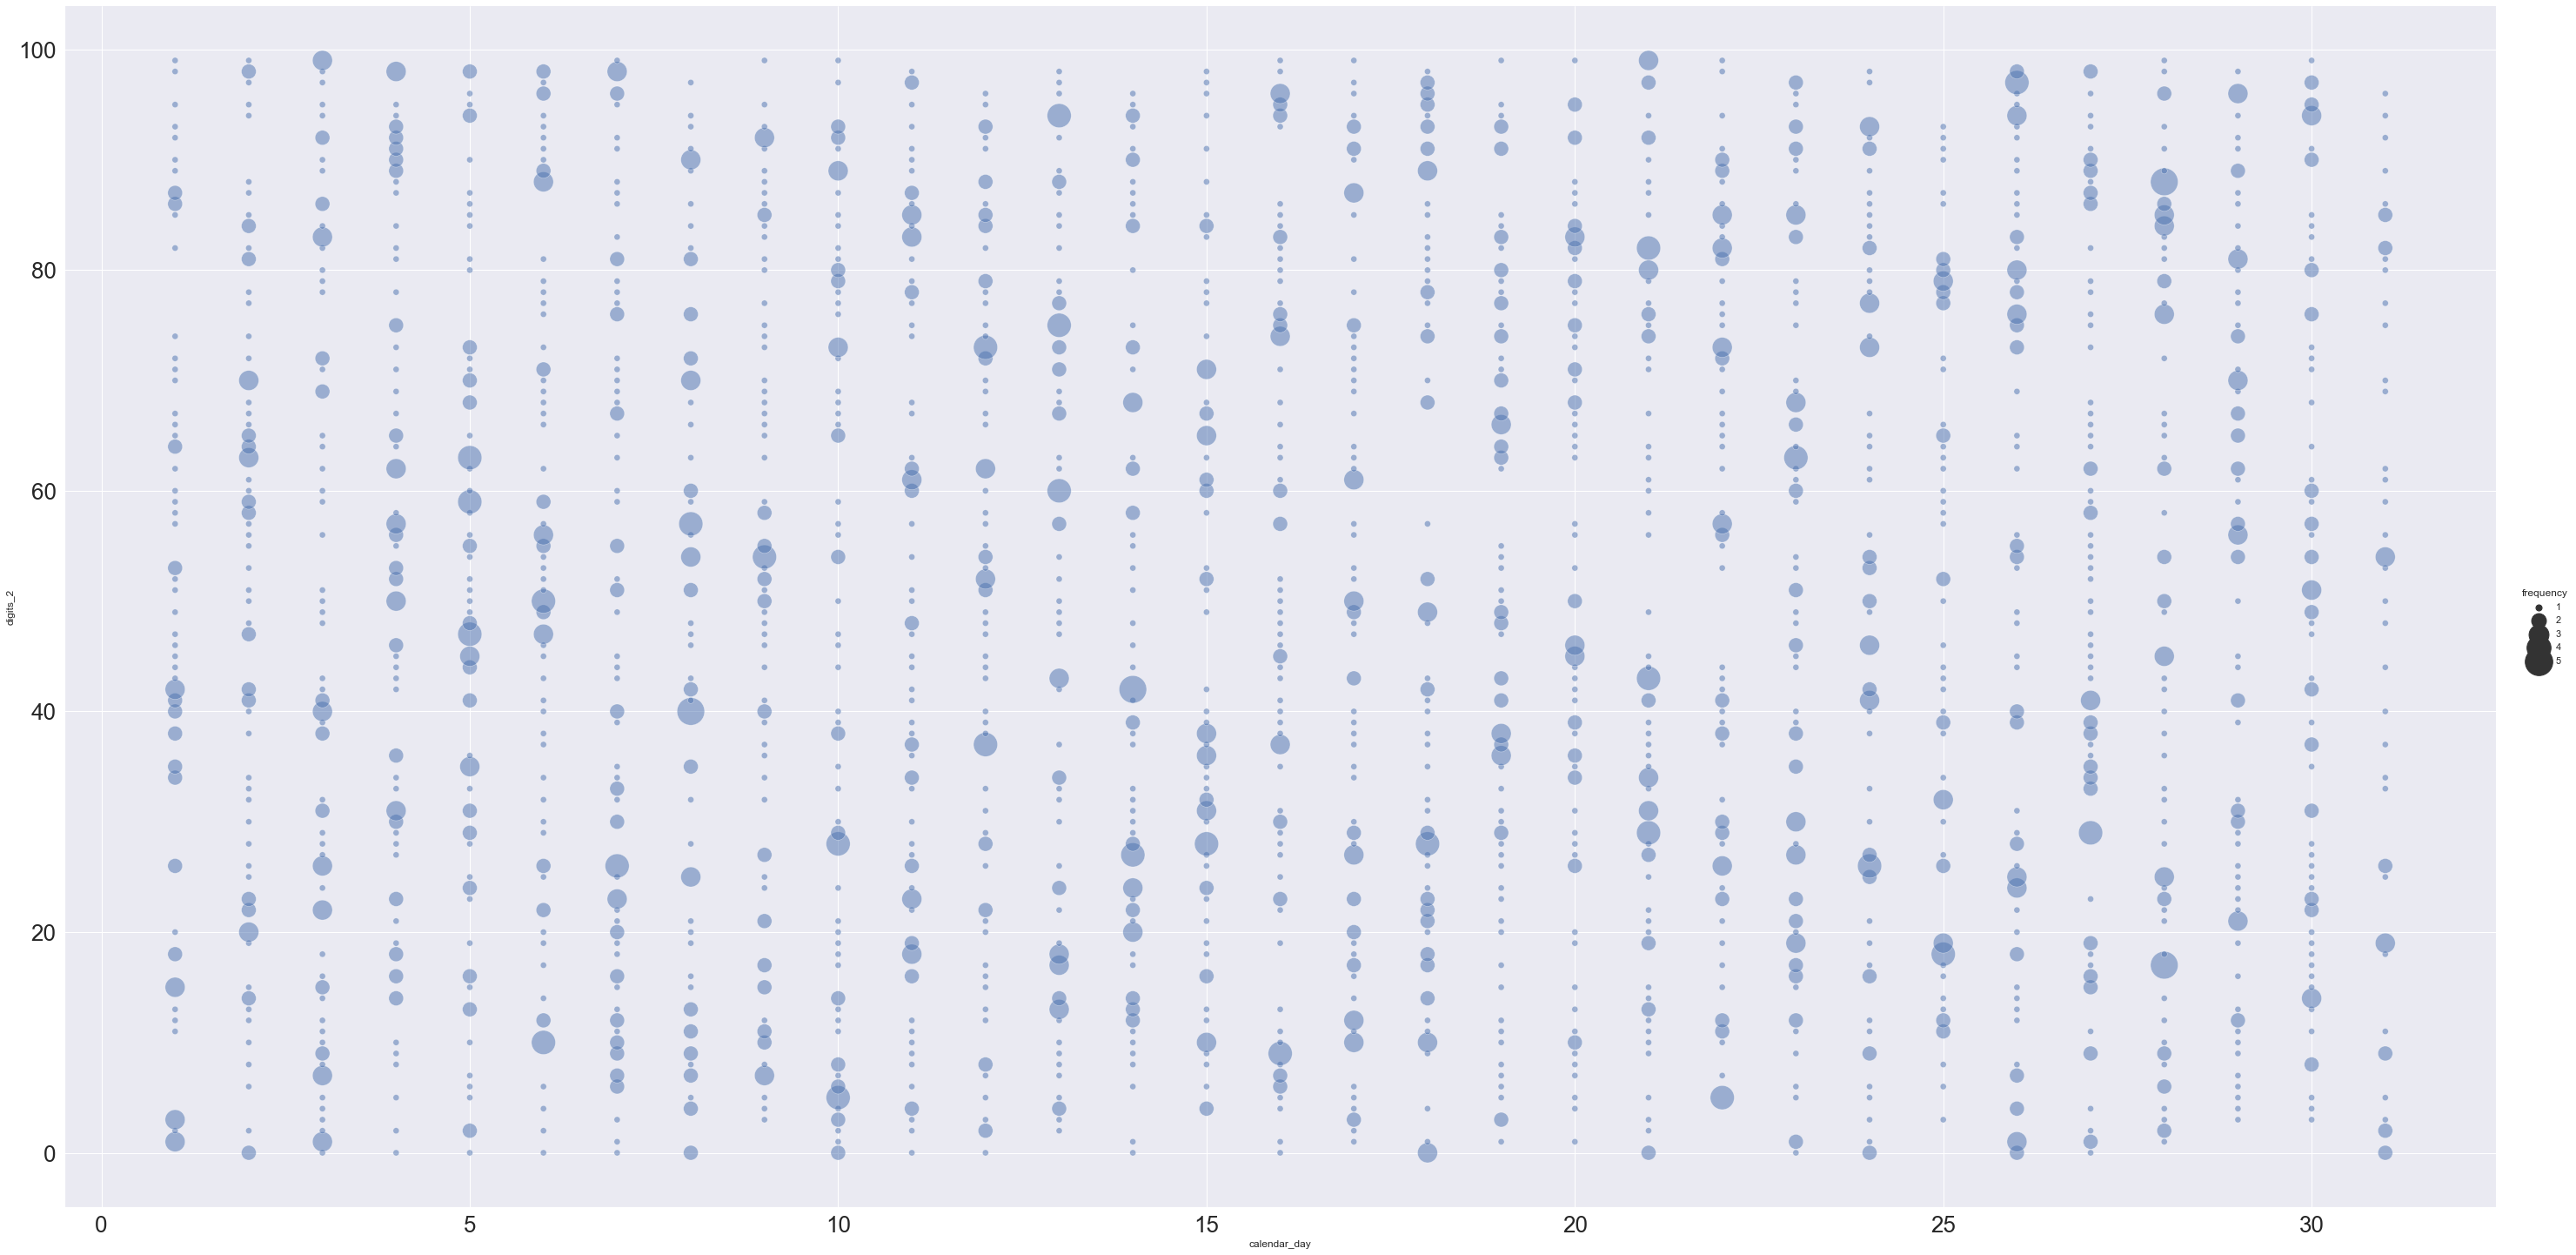

In [112]:
plot_scatter(df_quiniela, 'calendar_day', 'digits_2', 'primera')

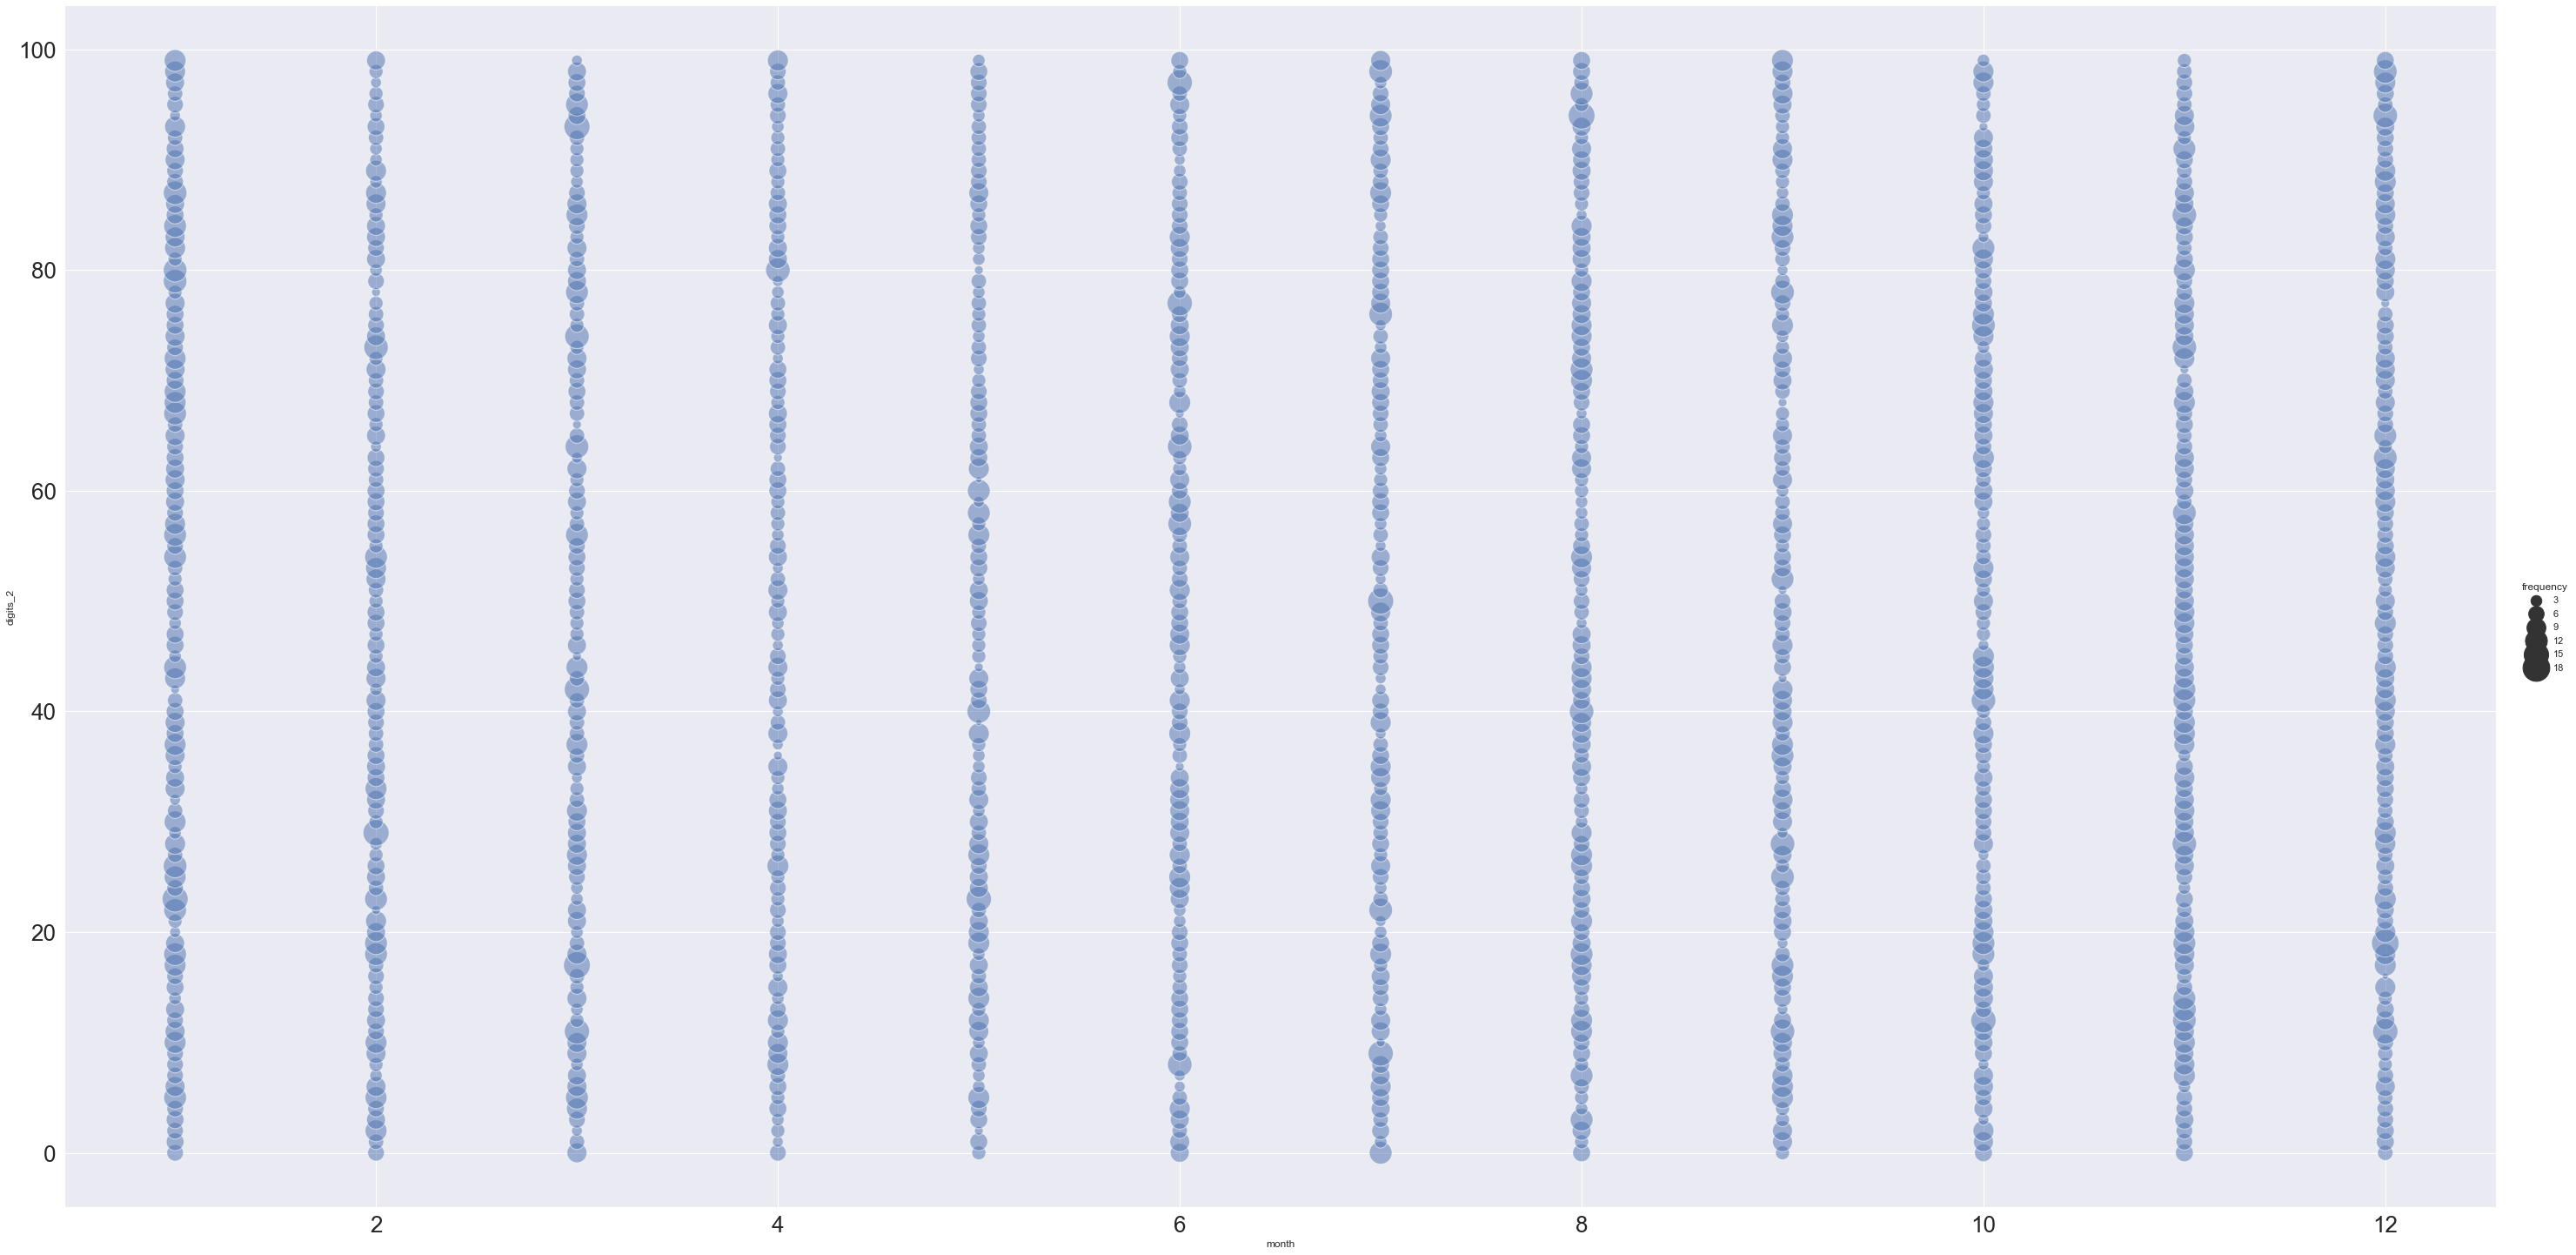

In [113]:
plot_scatter(df_quiniela, 'month', 'digits_2')

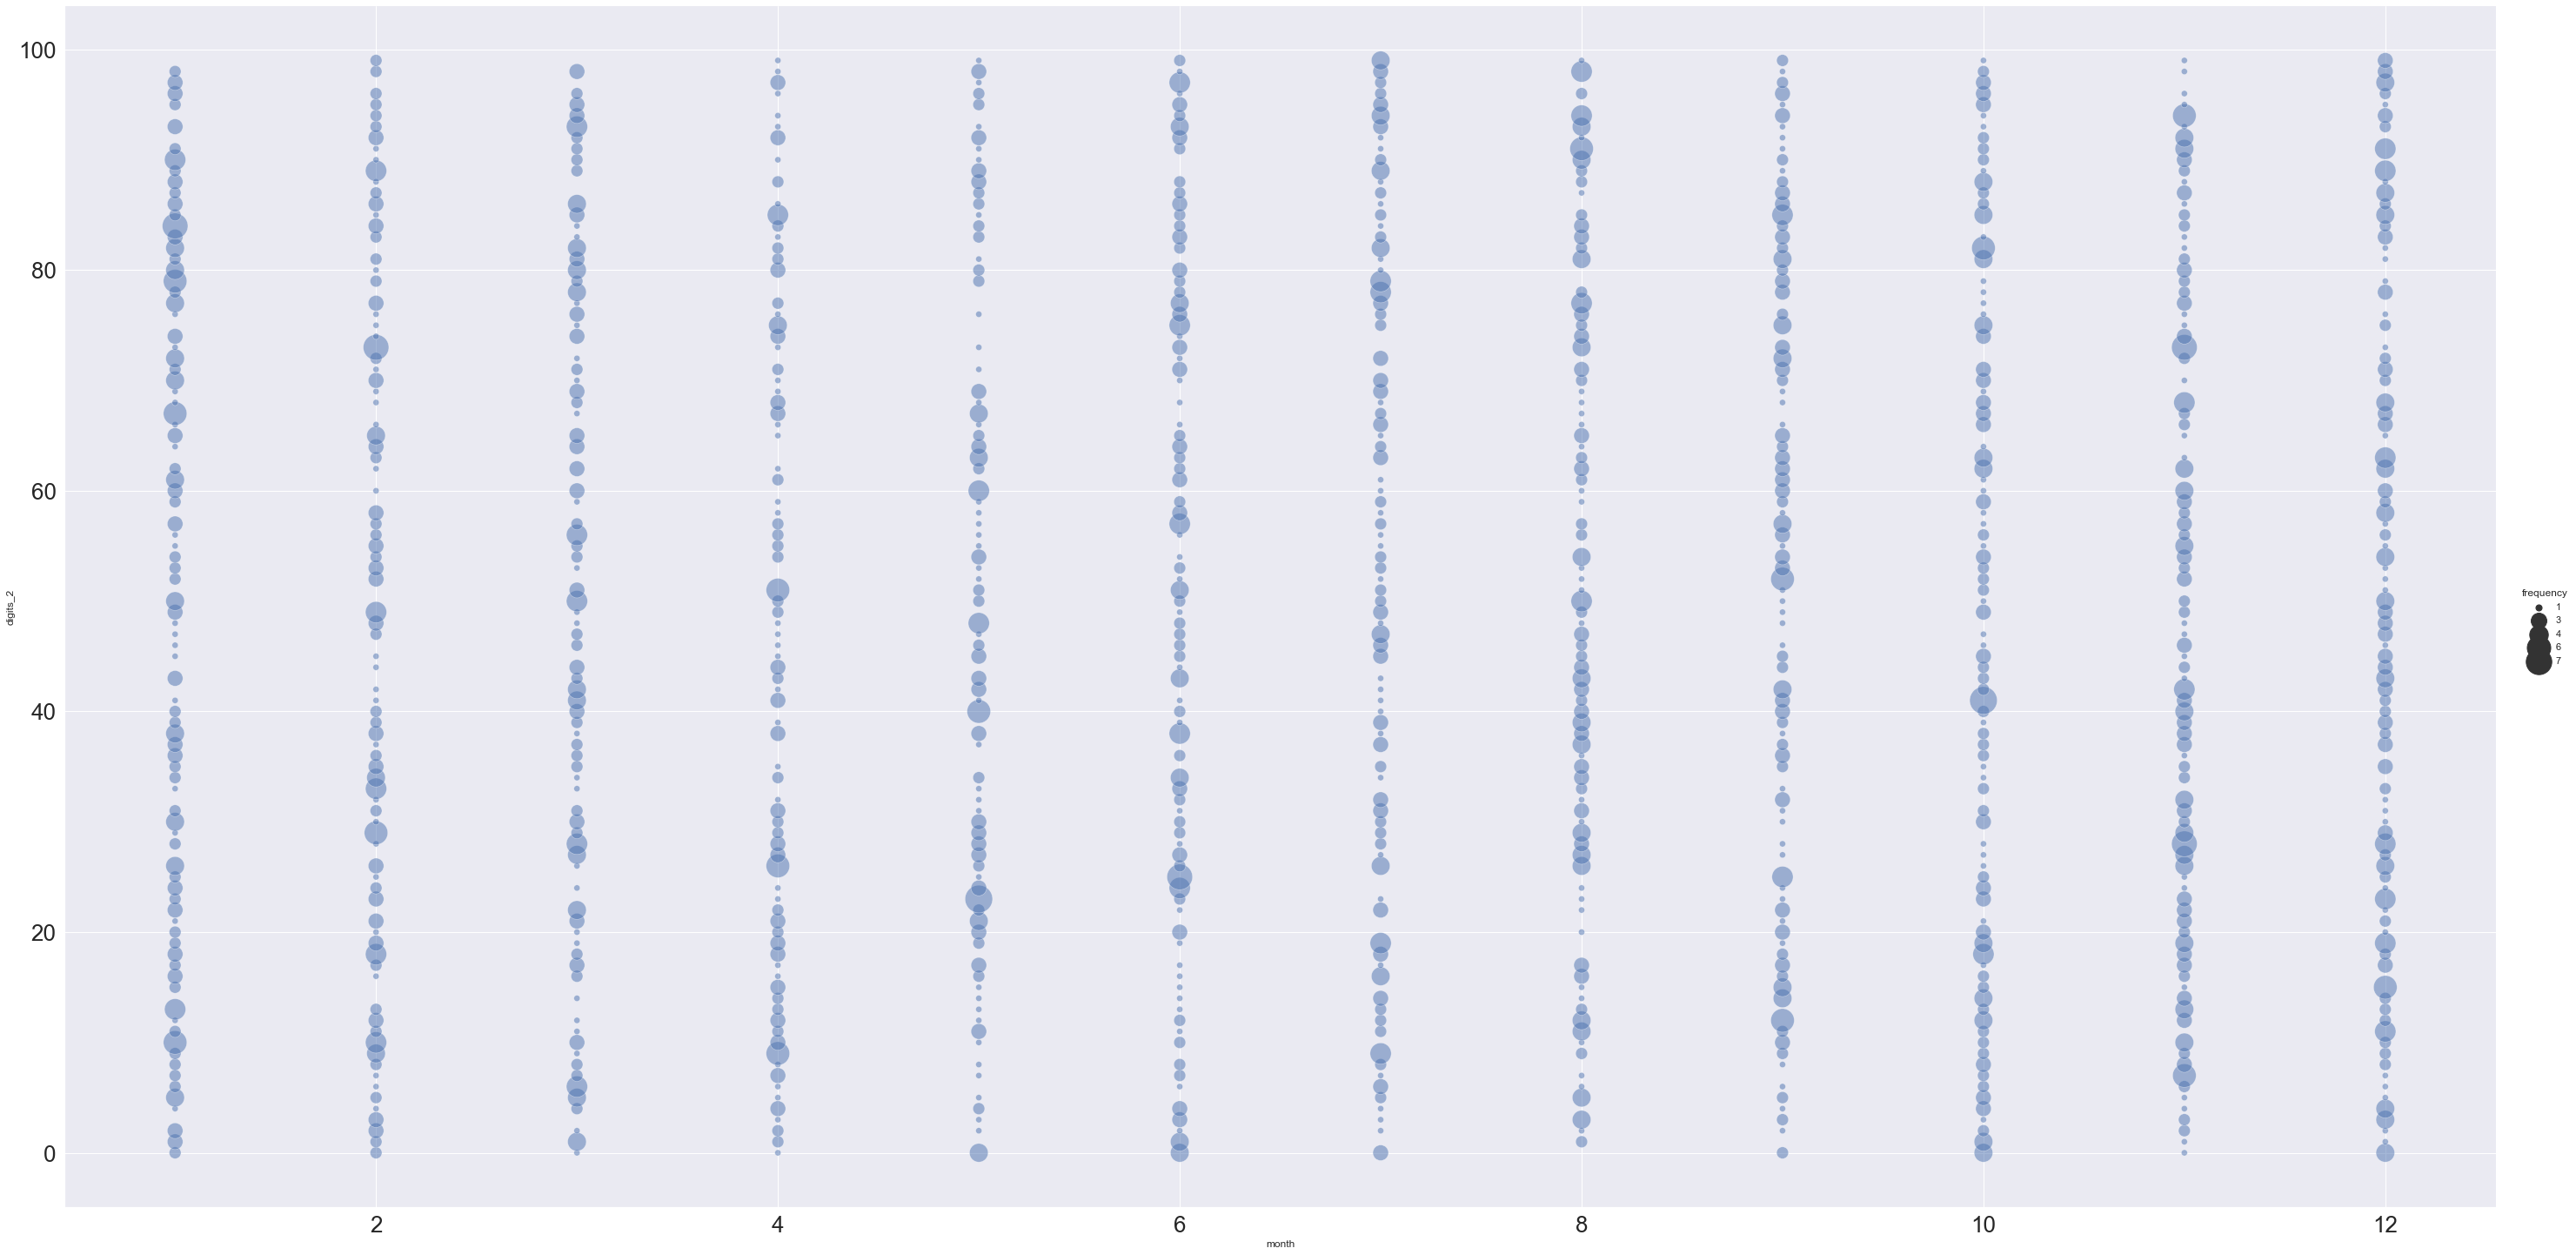

In [114]:
plot_scatter(df_quiniela, 'month', 'digits_2', 'primera')

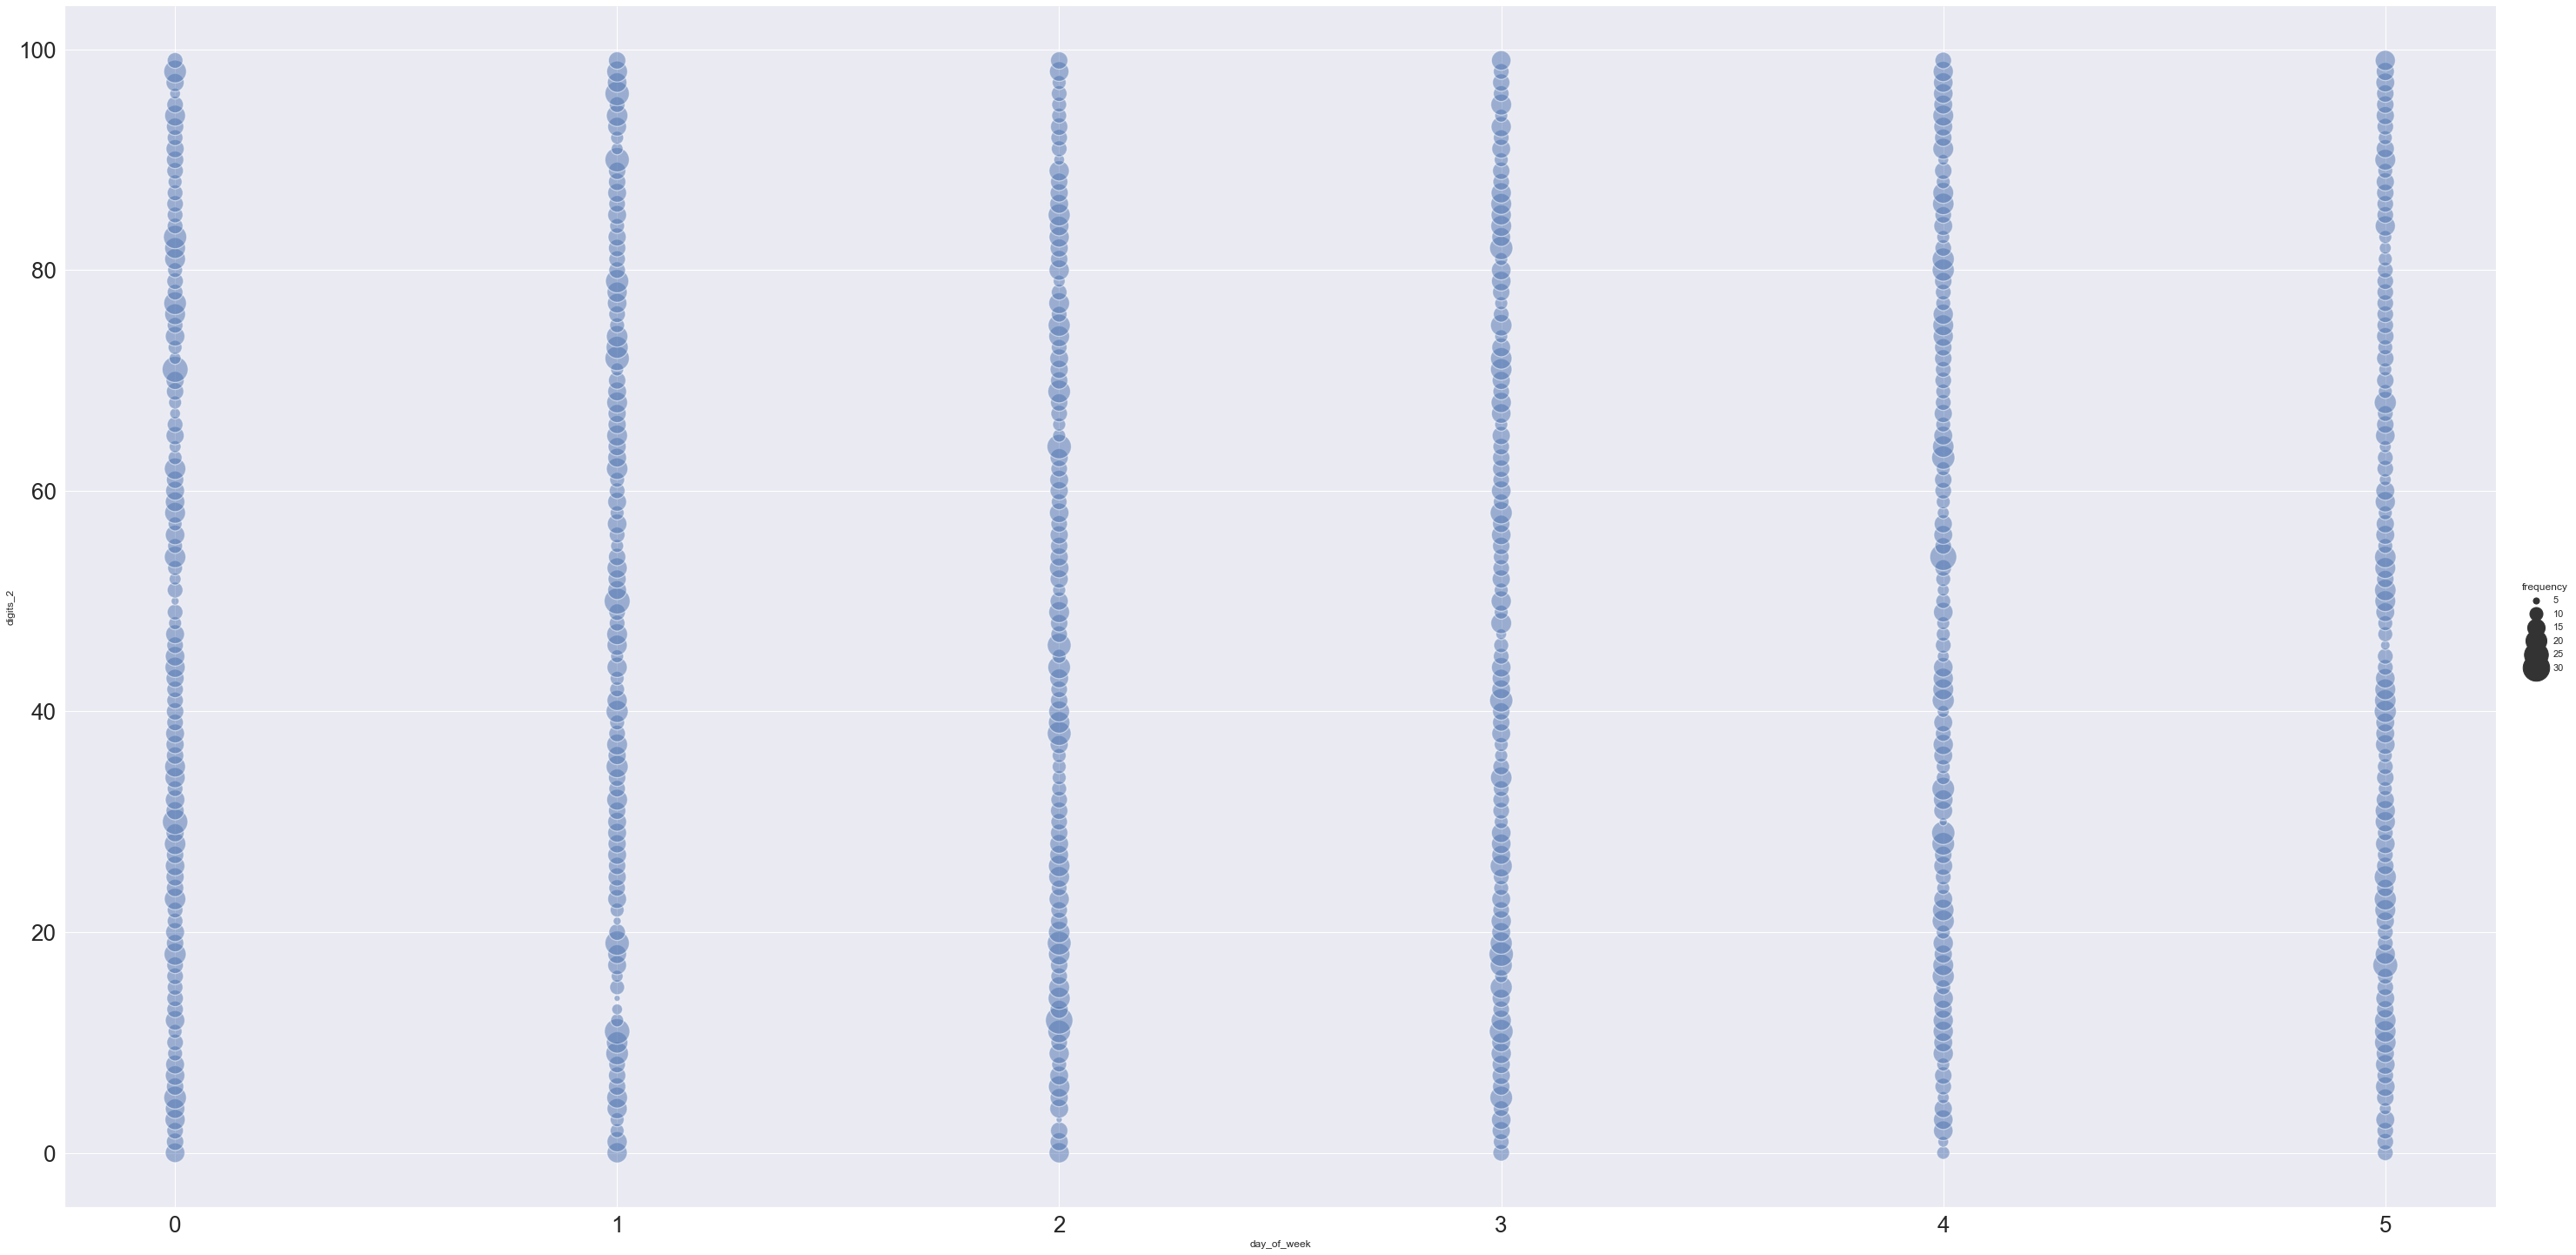

In [115]:
plot_scatter(df_quiniela, 'day_of_week', 'digits_2')

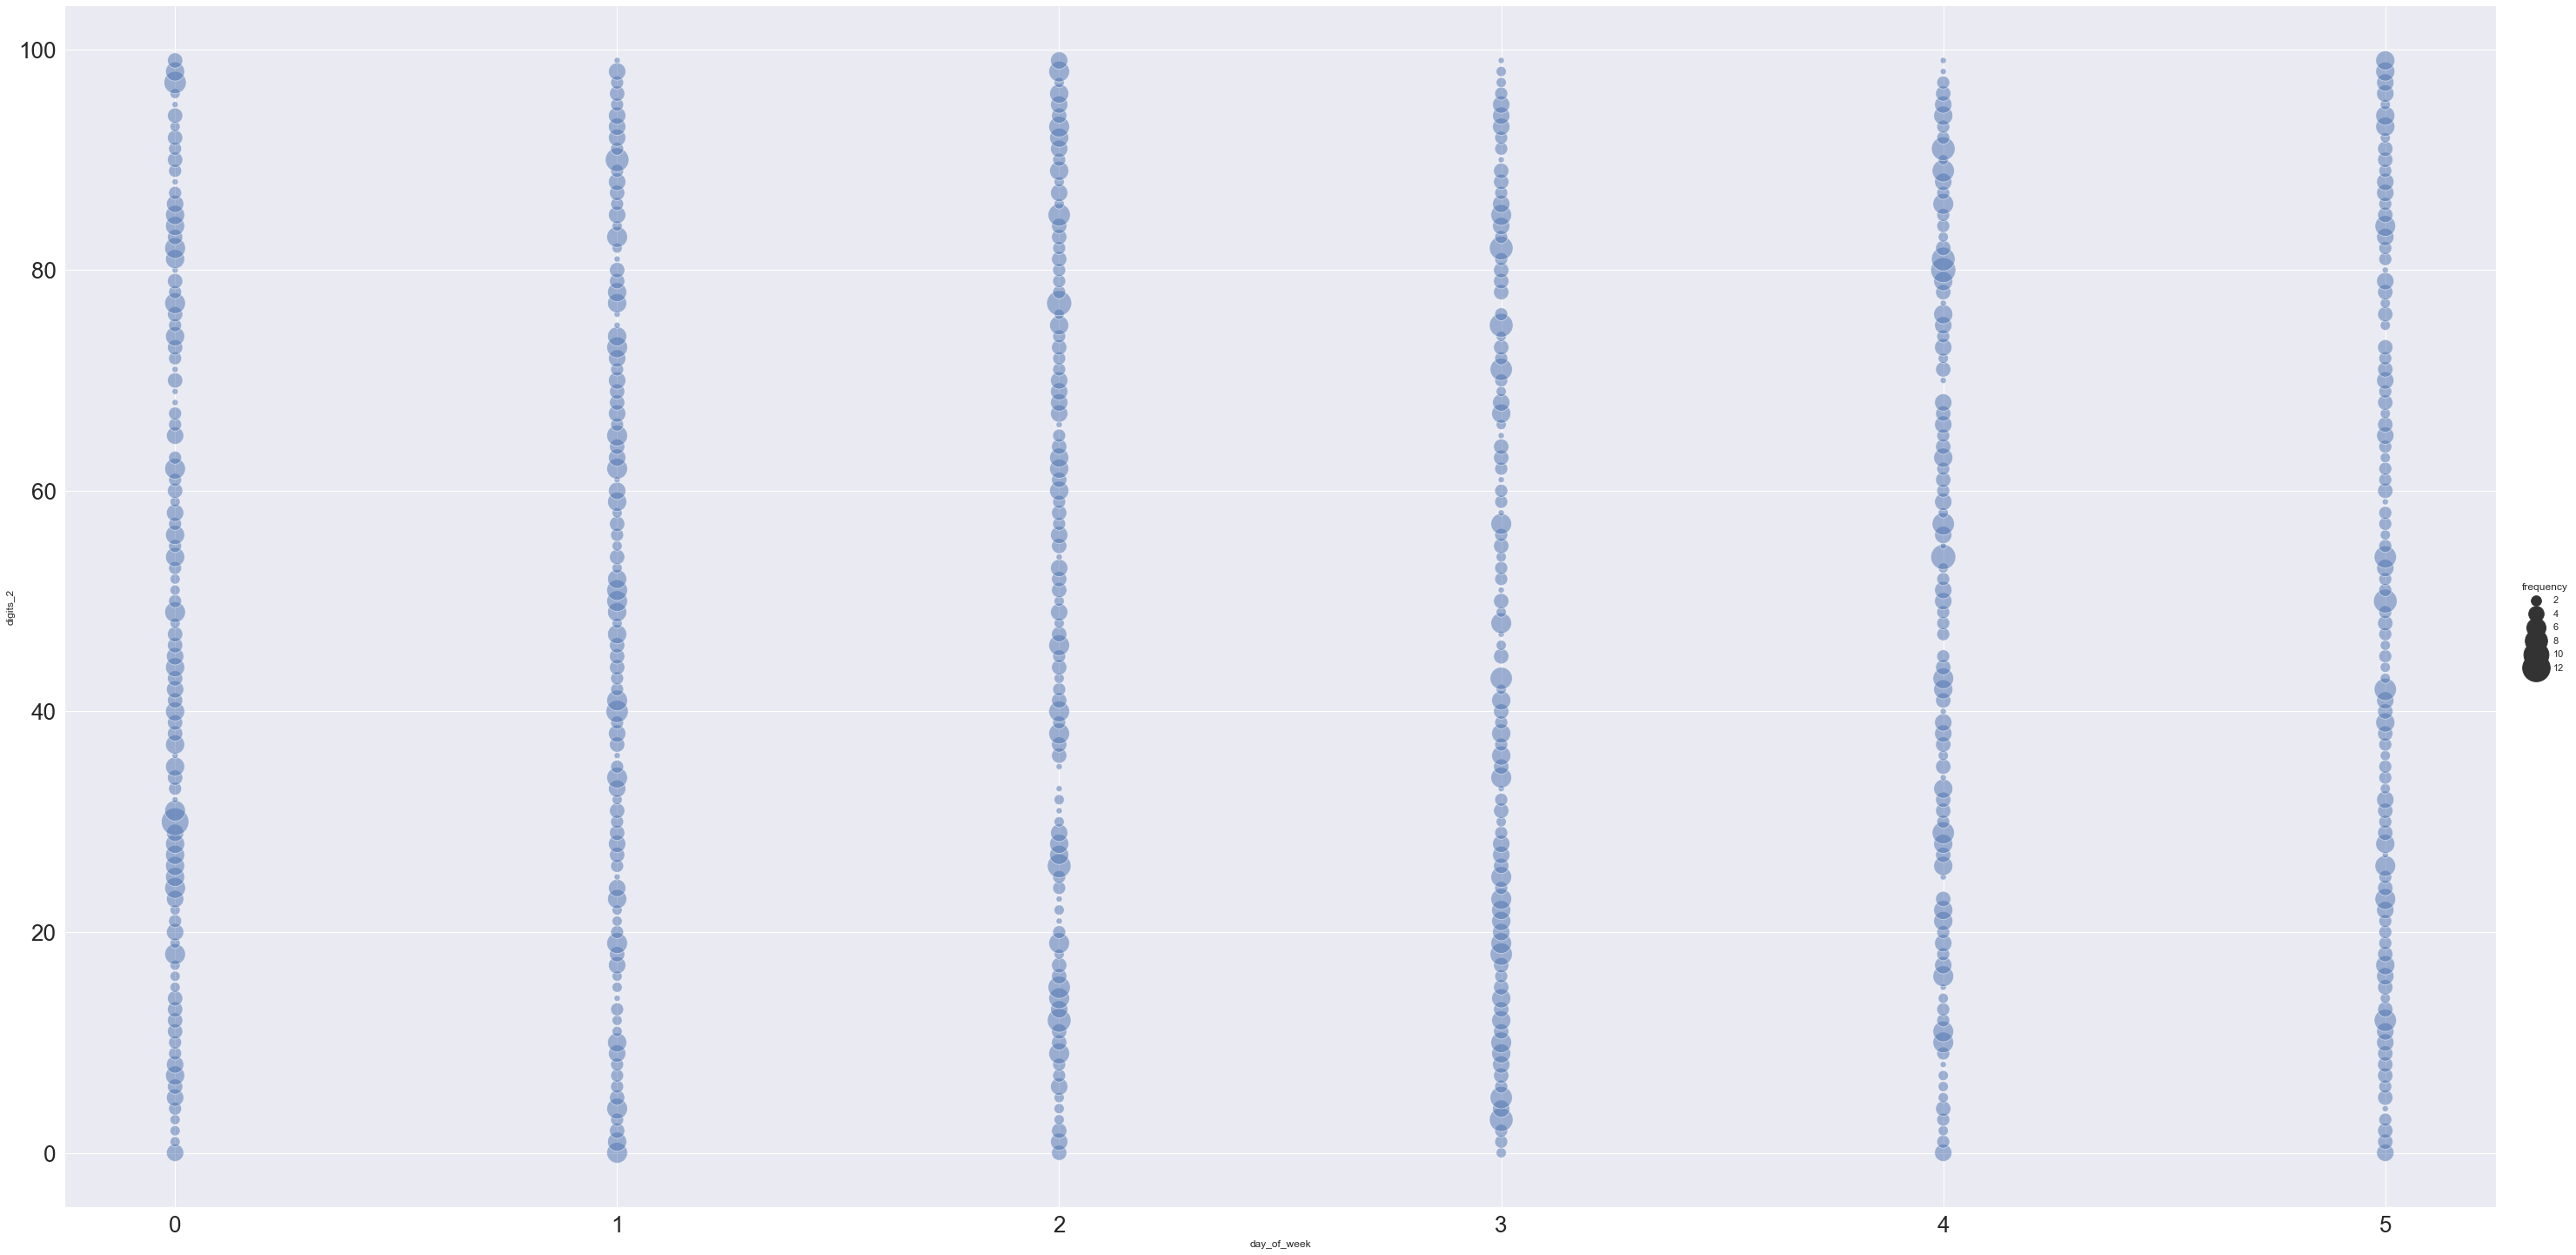

In [116]:
plot_scatter(df_quiniela, 'day_of_week', 'digits_2', 'primera')

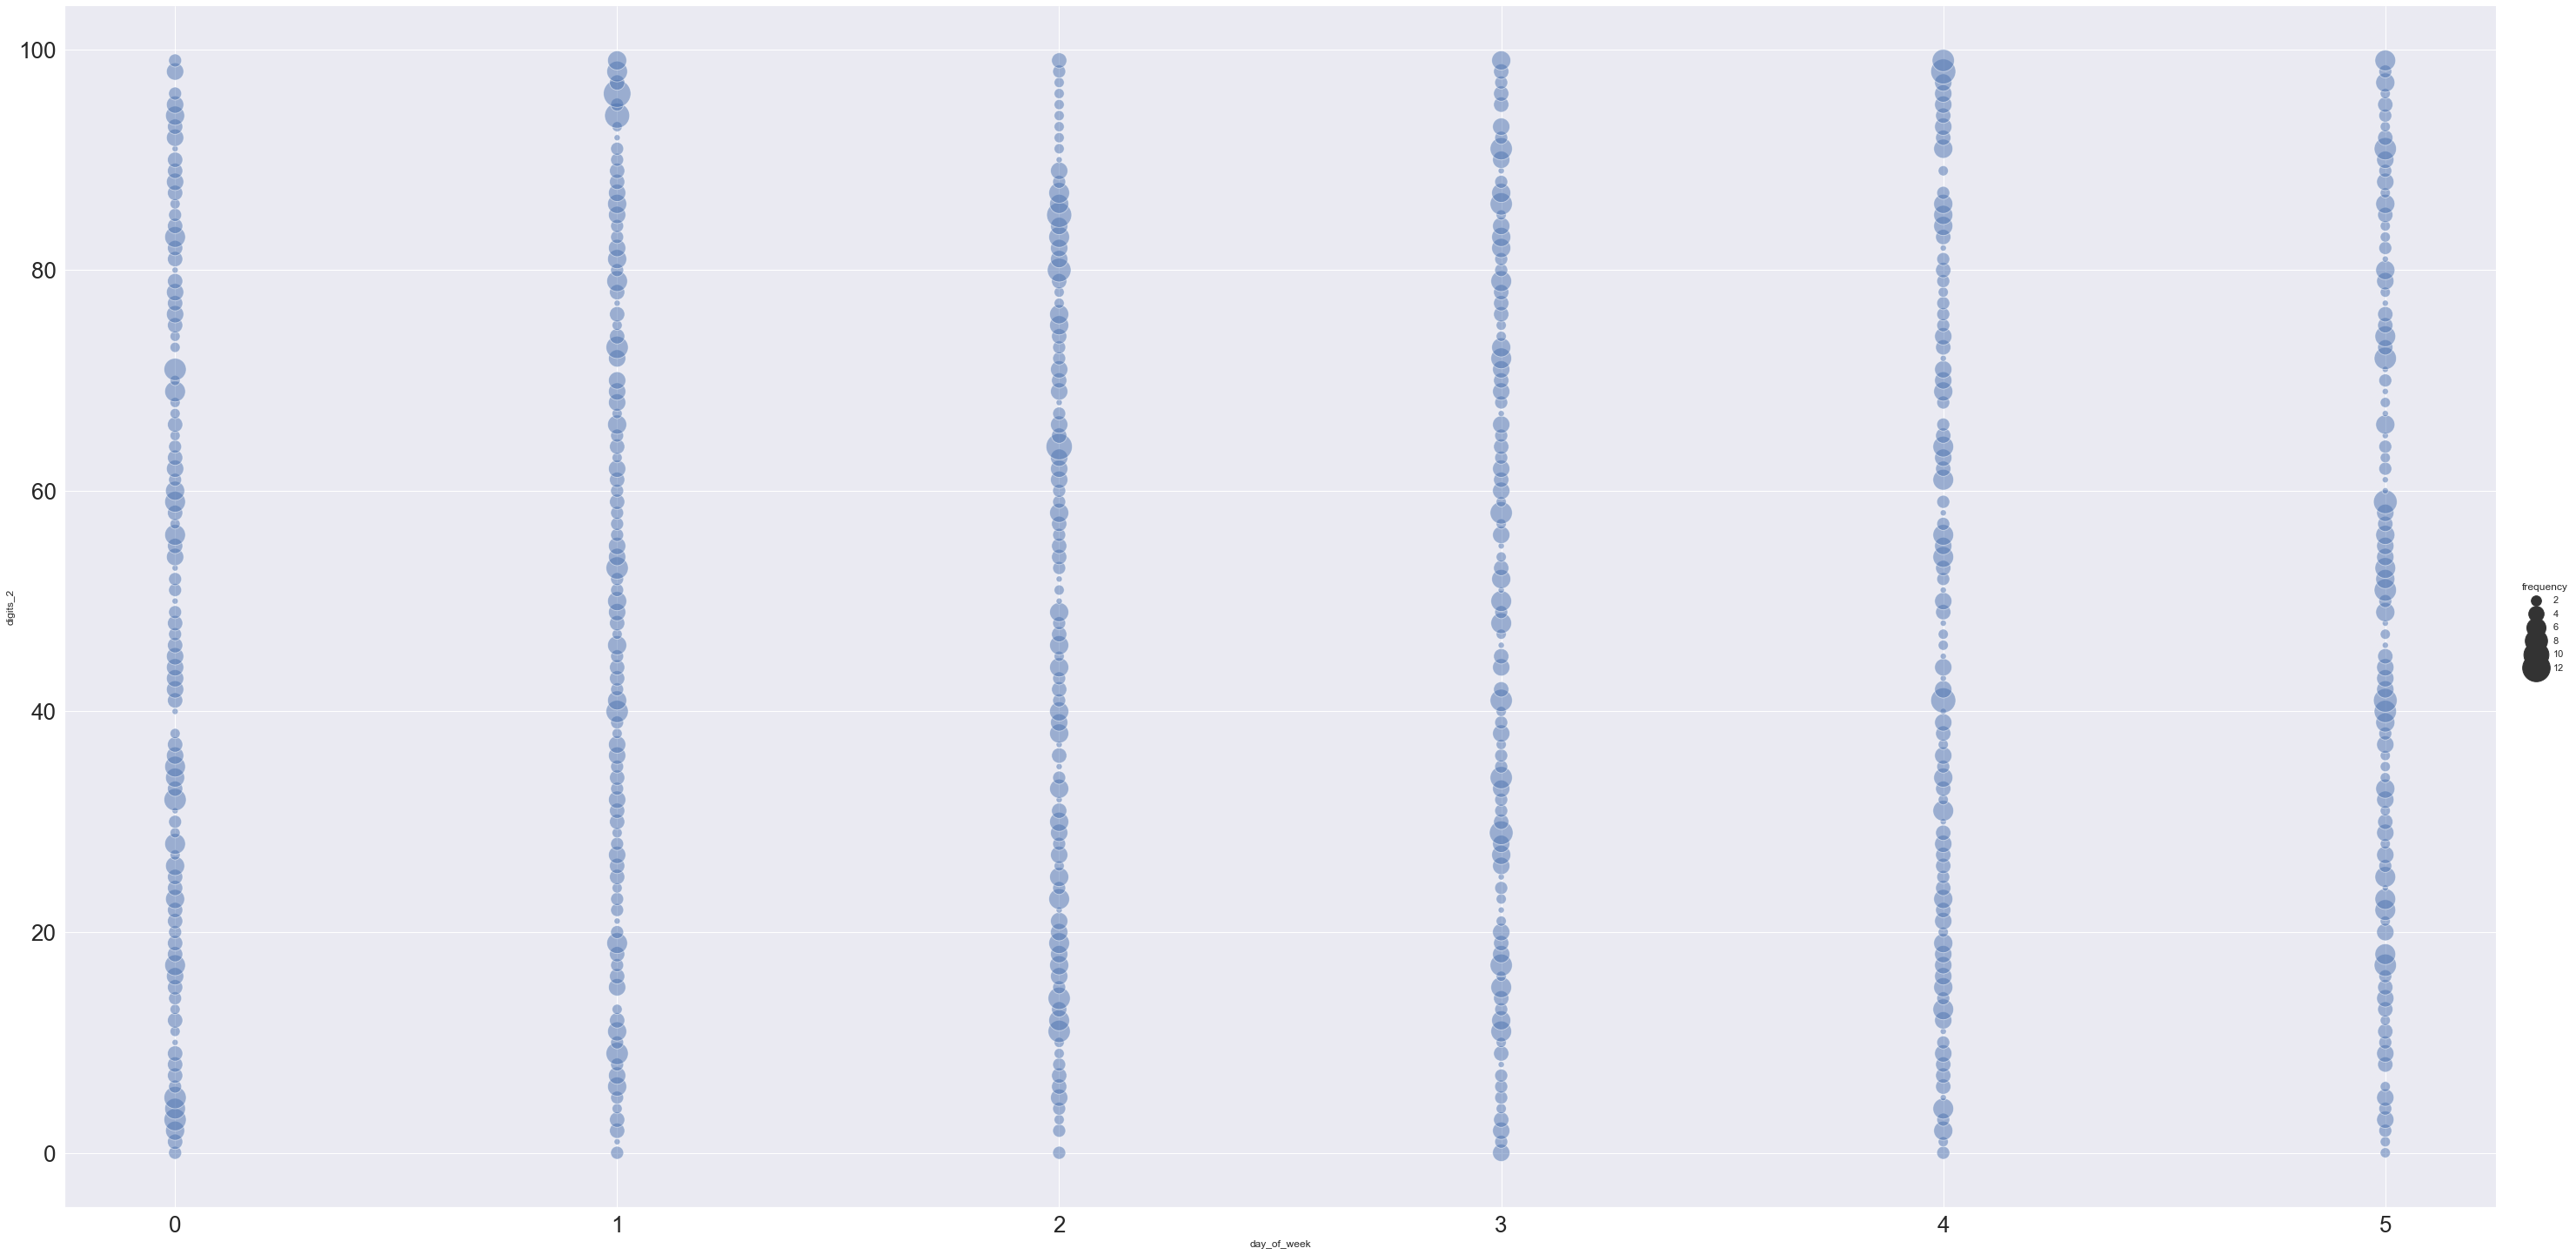

In [117]:
plot_scatter(df_quiniela, 'day_of_week', 'digits_2', 'nocturna')

> *No major tendency or pattern visually identifiable.*

### Add the number of days the 2 digit results have not been drawn for, prior to winning

This new feature will allow us to analyze if there are patterns in the intervals between a certain number is drawn for a specific period and position group.

In [118]:
# Create a function that takes the dataframe rows and returns the number of days that have elapsed, for each of the numbers, between they have been drawned for a certain position.
def calculate_days_without_prize(result_in, position_in, period_in, date_in):

    # Create a temporary dataframe, that takes the arguments passed to the function, and filters all previous dates, for that same number, period and position group
    df_result_temp = df_quiniela[
        (df_quiniela['digits_2'] == result_in) &
        (df_quiniela['position_group'] == position_in) &
        (df_quiniela['period'] == period_in) &
        (df_quiniela['lottery_date'] < date_in)
        ]

    # Removes all records that do not contain an appropriate date
    df_result_temp = df_result_temp[df_result_temp['lottery_date'] != pd.NaT]

    # Stores the latest date with the drawn number
    last_result_date = '' if (df_result_temp.empty) else df_result_temp['lottery_date'].max()

    # If there is a date, compares it against the actual row date, to calculate the number of days that have elapsed between these dates
    if (last_result_date != pd.NaT) & (last_result_date != ''):
        days_without_prize = date_in - last_result_date
    else:
        days_without_prize = 0

    # Returns the total number of days
    return days_without_prize

In [119]:
# Add the column 'days_without_prize' to the dataframe, containing the number of days elapsed between a certain number is drawn once, and again
df_quiniela['days_without_prize'] = df_quiniela.apply(lambda x: calculate_days_without_prize(x['digits_2'], x['position_group'], x['period'], x['lottery_date']), axis=1)

In [120]:
# Check latest records
df_quiniela.head()

lottery_date  quiniela   period  position result  digits_4  digits_3  \
0   2014-11-01  nacional  primera         1   3940      3940       940   
1   2014-11-01  nacional  primera         2   6857      6857       857   
2   2014-11-01  nacional  primera         3   0609       609       609   
3   2014-11-01  nacional  primera         4   8018      8018        18   
4   2014-11-01  nacional  primera         5   3232      3232       232   

   digits_2  first_digit  second_digit  third_digit  fourth_digit  \
0        40            3             9            4             0   
1        57            6             8            5             7   
2         9            0             6            0             9   
3        18            8             0            1             8   
4        32            3             2            3             2   

  position_group  calendar_day  day_of_week  month days_without_prize  
0            a_1             1            5     11                  0  
1        a_los_5             1            5     11                  0  
2        a_los_5             1            5     11                  0  
3        a_los_5             1            5     11                  0  
4        a_los_5             1            5     11                  0

In [121]:
# Check latest records
df_quiniela.tail(10)

lottery_date  quiniela    period  position result  digits_4  digits_3  \
191050   2023-01-20  nacional  nocturna        11   4568      4568       568   
191051   2023-01-20  nacional  nocturna        12   0051        51        51   
191052   2023-01-20  nacional  nocturna        13   7893      7893       893   
191053   2023-01-20  nacional  nocturna        14   7301      7301       301   
191054   2023-01-20  nacional  nocturna        15   4572      4572       572   
191055   2023-01-20  nacional  nocturna        16   4247      4247       247   
191056   2023-01-20  nacional  nocturna        17   6183      6183       183   
191057   2023-01-20  nacional  nocturna        18   1553      1553       553   
191058   2023-01-20  nacional  nocturna        19   4451      4451       451   
191059   2023-01-20  nacional  nocturna        20   4718      4718       718   

        digits_2  first_digit  second_digit  third_digit  fourth_digit  \
191050        68            4             5            6             8   
191051        51            0             0            5             1   
191052        93            7             8            9             3   
191053         1            7             3            0             1   
191054        72            4             5            7             2   
191055        47            4             2            4             7   
191056        83            6             1            8             3   
191057        53            1             5            5             3   
191058        51            4             4            5             1   
191059        18            4             7            1             8   

       position_group  calendar_day  day_of_week  month days_without_prize  
191050       a_los_15            20            4      1   15 days 00:00:00  
191051       a_los_15            20            4      1   70 days 00:00:00  
191052       a_los_15            20            4      1   23 days 00:00:00  
191053       a_los_15            20            4      1    1 days 00:00:00  
191054       a_los_15            20            4      1   31 days 00:00:00  
191055       a_los_20            20            4      1   41 days 00:00:00  
191056       a_los_20            20            4      1   10 days 00:00:00  
191057       a_los_20            20            4      1   27 days 00:00:00  
191058       a_los_20            20            4      1    7 days 00:00:00  
191059       a_los_20            20            4      1   15 days 00:00:00

In [122]:
# Get info on new column
df_quiniela['days_without_prize'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 191060 entries, 0 to 191059
Series name: days_without_prize
Non-Null Count   Dtype 
--------------   ----- 
191060 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [123]:
# Check basic stats about the new column
df_quiniela['days_without_prize'].describe()

count              191060
unique                597
top       1 days 00:00:00
freq                 7010
Name: days_without_prize, dtype: object

In [124]:
# Look at unique values in the new column
df_quiniela['days_without_prize'].unique()

array([0, Timedelta('3 days 00:00:00'), Timedelta('2 days 00:00:00'),
       Timedelta('5 days 00:00:00'), Timedelta('1 days 00:00:00'),
       Timedelta('4 days 00:00:00'), Timedelta('6 days 00:00:00'),
       Timedelta('7 days 00:00:00'), Timedelta('9 days 00:00:00'),
       Timedelta('8 days 00:00:00'), Timedelta('10 days 00:00:00'),
       Timedelta('14 days 00:00:00'), Timedelta('13 days 00:00:00'),
       Timedelta('12 days 00:00:00'), Timedelta('16 days 00:00:00'),
       Timedelta('17 days 00:00:00'), Timedelta('15 days 00:00:00'),
       Timedelta('21 days 00:00:00'), Timedelta('11 days 00:00:00'),
       Timedelta('19 days 00:00:00'), Timedelta('18 days 00:00:00'),
       Timedelta('22 days 00:00:00'), Timedelta('23 days 00:00:00'),
       Timedelta('24 days 00:00:00'), Timedelta('20 days 00:00:00'),
       Timedelta('26 days 00:00:00'), Timedelta('25 days 00:00:00'),
       Timedelta('27 days 00:00:00'), Timedelta('28 days 00:00:00'),
       Timedelta('32 days 00:00:00'), Ti

In [125]:
# First rows have 0 values, and despite it returns type 'Object', these values are recognized as int64
# Convert the entire column to type TEXT
df_quiniela['days_without_prize'] = df_quiniela['days_without_prize'].astype(str)
# Look at unique values that do not contain the word 'day' in them
df_quiniela[df_quiniela['days_without_prize'].str.contains('day') == False]['days_without_prize'].unique()

array(['0'], dtype=object)

In [126]:
# Count unique values that do not contain the word 'day' in them
df_quiniela[df_quiniela['days_without_prize'].str.contains('day') == False]['days_without_prize'].count()

2030

In [127]:
# Check basic stats about the rows that do not contain the word 'day' in the 'days_without_prize' column
df_quiniela[df_quiniela['days_without_prize'].str.contains('day') == False].describe()

position     digits_4     digits_3     digits_2  first_digit  \
count  2030.000000  2030.000000  2030.000000  2030.000000  2030.000000   
mean      8.752709  4925.038916   501.886207    49.423153     4.423153   
std       6.334750  2834.117351   287.998317    28.843791     2.823676   
min       1.000000    16.000000     1.000000     0.000000     0.000000   
25%       3.000000  2512.500000   248.250000    24.000000     2.000000   
50%       8.000000  4855.500000   503.500000    49.000000     4.000000   
75%      14.000000  7317.000000   747.000000    74.000000     7.000000   
max      20.000000  9994.000000   999.000000    99.000000     9.000000   

       second_digit  third_digit  fourth_digit  calendar_day  day_of_week  \
count   2030.000000  2030.000000   2030.000000   2030.000000  2030.000000   
mean       4.524631     4.492611      4.497044     13.268473     2.547291   
std        2.868248     2.870233      2.873845      8.455860     1.760550   
min        0.000000     0.000000      0.000000      1.000000     0.000000   
25%        2.000000     2.000000      2.000000      6.000000     1.000000   
50%        5.000000     4.000000      4.000000     12.000000     2.000000   
75%        7.000000     7.000000      7.000000     20.000000     4.000000   
max        9.000000     9.000000      9.000000     31.000000     5.000000   

             month  
count  2030.000000  
mean      9.505911  
std       3.597233  
min       1.000000  
25%      11.000000  
50%      11.000000  
75%      11.000000  
max      12.000000

> *Based on the digits_2 column, values seems reasonable, in terms of min, max, percentiles, mean and median.*

In [128]:
# Remove all strings from this column -leave numbers-, to later convert numbers to integers
df_quiniela['days_without_prize'] = df_quiniela['days_without_prize'].apply(lambda x: 0 if x == '0' else x.split(' days')[0])

In [129]:
# Convert columns values to integers
df_quiniela['days_without_prize'] = df_quiniela['days_without_prize'].astype(int)
# Check basic stats
df_quiniela['days_without_prize'].describe()

count    191060.000000
mean         30.980378
std          42.710555
min           0.000000
25%           8.000000
50%          19.000000
75%          39.000000
max        1416.000000
Name: days_without_prize, dtype: float64

In [130]:
# Visually check the last rows of the dataframe
df_quiniela.tail()

lottery_date  quiniela    period  position result  digits_4  digits_3  \
191055   2023-01-20  nacional  nocturna        16   4247      4247       247   
191056   2023-01-20  nacional  nocturna        17   6183      6183       183   
191057   2023-01-20  nacional  nocturna        18   1553      1553       553   
191058   2023-01-20  nacional  nocturna        19   4451      4451       451   
191059   2023-01-20  nacional  nocturna        20   4718      4718       718   

        digits_2  first_digit  second_digit  third_digit  fourth_digit  \
191055        47            4             2            4             7   
191056        83            6             1            8             3   
191057        53            1             5            5             3   
191058        51            4             4            5             1   
191059        18            4             7            1             8   

       position_group  calendar_day  day_of_week  month  days_without_prize  
191055       a_los_20            20            4      1                  41  
191056       a_los_20            20            4      1                  10  
191057       a_los_20            20            4      1                  27  
191058       a_los_20            20            4      1                   7  
191059       a_los_20            20            4      1                  15

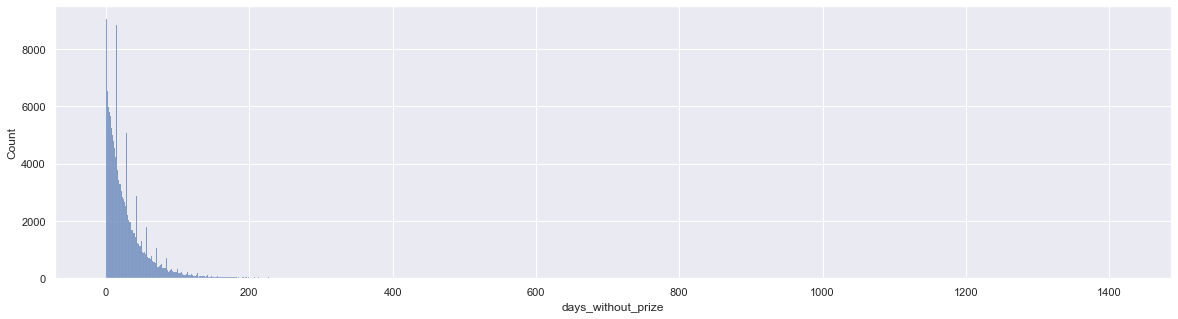

In [131]:
# Check distribution of days without being drawn for prizes
plt.figure(figsize=(20,5))
sns.histplot(x=df_quiniela['days_without_prize'],data=df_quiniela)
plt.show()

> *The distribution is right skewed and seems to have large outliers.*

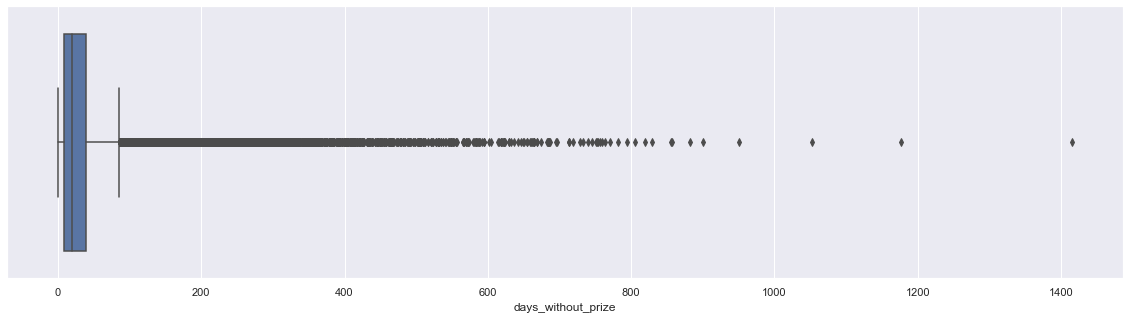

In [132]:
# Check outliers with a boxplot
plt.figure(figsize=(20,5))
sns.boxplot(x=df_quiniela['days_without_prize'], data=df_quiniela)
plt.show()

In [133]:
# Calculate the whisker position at the 1.5*IQR
q1 = df_quiniela['days_without_prize'].quantile(0.25)
q3 = df_quiniela['days_without_prize'].quantile(0.75)
IQR = q3 - q1
upper_whisker = q3 + (1.5 * IQR)
print('Upper bound for considering outliers is: {}'.format(upper_whisker))

Upper bound for considering outliers is: 85.5


> *Visually, there seems to be a change above 800, so it will be analyzed separately.*

In [134]:
# Check basic stats about possible outliers (all values above the upper bound and below 800)
df_quiniela[(df_quiniela['days_without_prize'] > 85.5) & (df_quiniela['days_without_prize'] < 800)].describe()

position      digits_4      digits_3      digits_2   first_digit  \
count  11977.000000  11977.000000  11977.000000  11977.000000  11977.000000   
mean       6.555732   5038.299491    497.262503     49.854972      4.541037   
std        6.258255   2884.260236    288.347233     28.909666      2.869985   
min        1.000000      1.000000      0.000000      0.000000      0.000000   
25%        1.000000   2566.000000    247.000000     25.000000      2.000000   
50%        4.000000   5073.000000    493.000000     50.000000      5.000000   
75%       12.000000   7541.000000    745.000000     75.000000      7.000000   
max       20.000000   9999.000000    999.000000     99.000000      9.000000   

       second_digit   third_digit  fourth_digit  calendar_day   day_of_week  \
count  11977.000000  11977.000000  11977.000000  11977.000000  11977.000000   
mean       4.474075      4.537948      4.475495     15.878183      2.462303   
std        2.867309      2.879235      2.865544      8.778738      1.682636   
min        0.000000      0.000000      0.000000      1.000000      0.000000   
25%        2.000000      2.000000      2.000000      8.000000      1.000000   
50%        4.000000      5.000000      4.000000     16.000000      2.000000   
75%        7.000000      7.000000      7.000000     23.000000      4.000000   
max        9.000000      9.000000      9.000000     31.000000      5.000000   

              month  days_without_prize  
count  11977.000000        11977.000000  
mean       6.602739          148.782917  
std        3.294418           87.171292  
min        1.000000           86.000000  
25%        4.000000           97.000000  
50%        7.000000          117.000000  
75%        9.000000          162.000000  
max       12.000000          794.000000

In [135]:
# Check basic stats about possible outliers (above 800)
df_quiniela[df_quiniela['days_without_prize'] > 800].describe()

position     digits_4    digits_3   digits_2  first_digit  \
count      11.0    11.000000   11.000000  11.000000    11.000000   
mean        1.0  3529.454545  438.545455  47.636364     3.090909   
std         0.0  2796.086099  332.411601  29.591461     2.948035   
min         1.0    46.000000   46.000000   1.000000     0.000000   
25%         1.0  1271.000000  137.500000  27.000000     0.500000   
50%         1.0  3269.000000  301.000000  50.000000     3.000000   
75%         1.0  5497.500000  723.500000  71.000000     5.000000   
max         1.0  8301.000000  950.000000  92.000000     8.000000   

       second_digit  third_digit  fourth_digit  calendar_day  day_of_week  \
count     11.000000    11.000000     11.000000     11.000000    11.000000   
mean       3.909091     4.272727      4.909091     18.272727     2.090909   
std        3.207945     3.003029      3.048099      6.558825     1.513575   
min        0.000000     0.000000      0.000000      7.000000     0.000000   
25%        1.000000     2.000000      2.500000     14.500000     1.000000   
50%        3.000000     5.000000      6.000000     20.000000     2.000000   
75%        6.500000     6.500000      7.000000     23.000000     3.000000   
max        9.000000     9.000000      9.000000     27.000000     5.000000   

           month  days_without_prize  
count  11.000000           11.000000  
mean    7.545455          958.727273  
std     2.876235          188.548185  
min     3.000000          806.000000  
25%     5.000000          842.500000  
50%     9.000000          882.000000  
75%    10.000000         1001.500000  
max    11.000000         1416.000000

> *Very few occurrences above 800, so they will be included in the dataset.*

Check distribution of days without a prize, only for the first position

In [136]:
# Filter dataframe for records at position 1 only
df_days_without_first_position = df_quiniela[df_quiniela['position_group'] == 'a_1']
df_days_without_first_position.describe()

position     digits_4     digits_3     digits_2  first_digit  \
count    9553.0  9553.000000  9553.000000  9553.000000  9553.000000   
mean        1.0  5018.599079   495.726683    48.976971     4.522872   
std         0.0  2893.302950   287.951147    28.940267     2.879657   
min         1.0     1.000000     0.000000     0.000000     0.000000   
25%         1.0  2529.000000   242.000000    24.000000     2.000000   
50%         1.0  5015.000000   490.000000    49.000000     5.000000   
75%         1.0  7546.000000   741.000000    74.000000     7.000000   
max         1.0  9999.000000   999.000000    99.000000     9.000000   

       second_digit  third_digit  fourth_digit  calendar_day  day_of_week  \
count   9553.000000  9553.000000   9553.000000   9553.000000  9553.000000   
mean       4.467497     4.446980      4.507171     15.748456     2.489480   
std        2.864035     2.881913      2.886493      8.752725     1.694446   
min        0.000000     0.000000      0.000000      1.000000     0.000000   
25%        2.000000     2.000000      2.000000      8.000000     1.000000   
50%        4.000000     4.000000      4.000000     16.000000     2.000000   
75%        7.000000     7.000000      7.000000     23.000000     4.000000   
max        9.000000     9.000000      9.000000     31.000000     5.000000   

             month  days_without_prize  
count  9553.000000         9553.000000  
mean      6.640008          115.553857  
std       3.530541          121.844425  
min       1.000000            0.000000  
25%       3.000000           29.000000  
50%       7.000000           78.000000  
75%      10.000000          162.000000  
max      12.000000         1416.000000

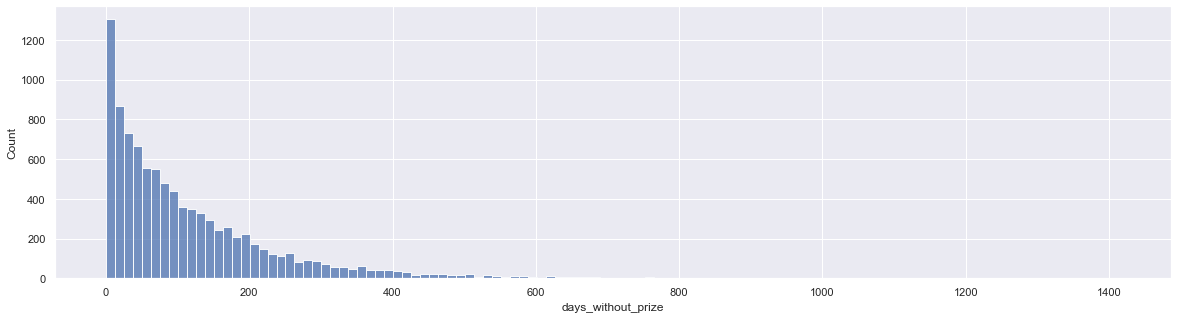

In [137]:
# Check distribution of days without being drawn for prizes, at the first position
plt.figure(figsize=(20,5))
sns.histplot(x=df_days_without_first_position['days_without_prize'],data=df_days_without_first_position)
plt.show()

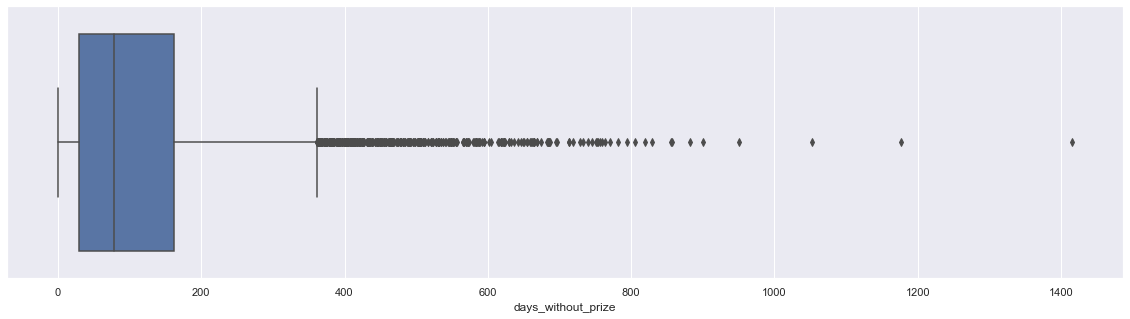

In [138]:
# Check outliers with a boxplot
plt.figure(figsize=(20,5))
sns.boxplot(x=df_days_without_first_position['days_without_prize'], data=df_days_without_first_position)
plt.show()

In [139]:
# Calculate the whisker position at the 1.5*IQR
q1 = df_days_without_first_position['days_without_prize'].quantile(0.25)
q3 = df_days_without_first_position['days_without_prize'].quantile(0.75)
IQR = q3 - q1
upper_whisker = q3 + (1.5 * IQR)
print('Upper bound for considering outliers is: {}'.format(upper_whisker))

Upper bound for considering outliers is: 361.5


In [140]:
# Check basic stats about possible outliers (all values above the upper bound and below 800)
df_days_without_first_position[(df_days_without_first_position['days_without_prize'] > 361.5) & (df_days_without_first_position['days_without_prize'] < 800)].describe()

position     digits_4    digits_3    digits_2  first_digit  \
count     465.0   465.000000  465.000000  465.000000   465.000000   
mean        1.0  4846.391398  500.154839   49.832258     4.346237   
std         0.0  2968.684507  293.318692   28.373088     2.975205   
min         1.0     7.000000    0.000000    0.000000     0.000000   
25%         1.0  2119.000000  250.000000   26.000000     2.000000   
50%         1.0  4802.000000  491.000000   50.000000     4.000000   
75%         1.0  7556.000000  757.000000   74.000000     7.000000   
max         1.0  9995.000000  999.000000   99.000000     9.000000   

       second_digit  third_digit  fourth_digit  calendar_day  day_of_week  \
count    465.000000   465.000000    465.000000    465.000000   465.000000   
mean       4.503226     4.539785      4.434409     15.894624     2.602151   
std        2.896284     2.810661      2.863357      9.015054     1.734163   
min        0.000000     0.000000      0.000000      1.000000     0.000000   
25%        2.000000     2.000000      2.000000      8.000000     1.000000   
50%        4.000000     5.000000      5.000000     16.000000     3.000000   
75%        7.000000     7.000000      7.000000     24.000000     4.000000   
max        9.000000     9.000000      9.000000     31.000000     5.000000   

            month  days_without_prize  
count  465.000000          465.000000  
mean     6.845161          472.098925  
std      3.549785           99.012728  
min      1.000000          362.000000  
25%      4.000000          392.000000  
50%      7.000000          444.000000  
75%     10.000000          527.000000  
max     12.000000          794.000000

In [141]:
# Check basic stats about possible outliers (above 800)
df_days_without_first_position[df_days_without_first_position['days_without_prize'] > 800].describe()

position     digits_4    digits_3   digits_2  first_digit  \
count      11.0    11.000000   11.000000  11.000000    11.000000   
mean        1.0  3529.454545  438.545455  47.636364     3.090909   
std         0.0  2796.086099  332.411601  29.591461     2.948035   
min         1.0    46.000000   46.000000   1.000000     0.000000   
25%         1.0  1271.000000  137.500000  27.000000     0.500000   
50%         1.0  3269.000000  301.000000  50.000000     3.000000   
75%         1.0  5497.500000  723.500000  71.000000     5.000000   
max         1.0  8301.000000  950.000000  92.000000     8.000000   

       second_digit  third_digit  fourth_digit  calendar_day  day_of_week  \
count     11.000000    11.000000     11.000000     11.000000    11.000000   
mean       3.909091     4.272727      4.909091     18.272727     2.090909   
std        3.207945     3.003029      3.048099      6.558825     1.513575   
min        0.000000     0.000000      0.000000      7.000000     0.000000   
25%        1.000000     2.000000      2.500000     14.500000     1.000000   
50%        3.000000     5.000000      6.000000     20.000000     2.000000   
75%        6.500000     6.500000      7.000000     23.000000     3.000000   
max        9.000000     9.000000      9.000000     27.000000     5.000000   

           month  days_without_prize  
count  11.000000           11.000000  
mean    7.545455          958.727273  
std     2.876235          188.548185  
min     3.000000          806.000000  
25%     5.000000          842.500000  
50%     9.000000          882.000000  
75%    10.000000         1001.500000  
max    11.000000         1416.000000

In [142]:
# Calculate distributions and basic stats, removing first instances of the occurrences, where numbers have 0 days of being drawn
df_days_without_first_position_drawn_before = df_days_without_first_position[df_days_without_first_position['days_without_prize'] != 0]

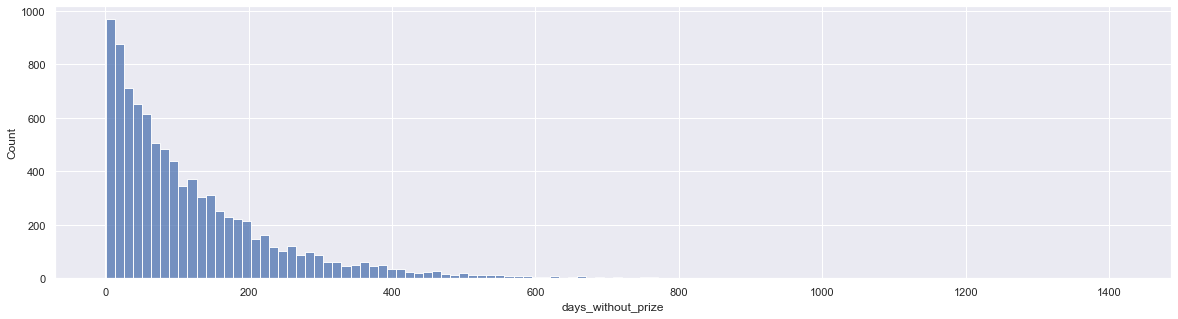

In [143]:
# Check distribution of days without being drawn for prizes, except for the first occurrences of each, wich are determine by '0' in the new feature
plt.figure(figsize=(20,5))
sns.histplot(x=df_days_without_first_position_drawn_before['days_without_prize'],data=df_days_without_first_position_drawn_before)
plt.show()

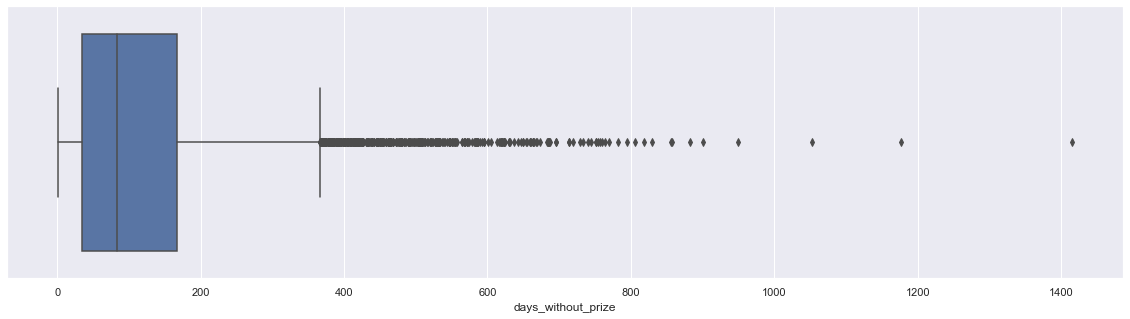

In [144]:
# Check outliers with a boxplot
plt.figure(figsize=(20,5))
sns.boxplot(x=df_days_without_first_position_drawn_before['days_without_prize'], data=df_days_without_first_position_drawn_before)
plt.show()

In [145]:
# Calculate the whisker position at the 1.5*IQR
q1 = df_days_without_first_position_drawn_before['days_without_prize'].quantile(0.25)
q3 = df_days_without_first_position_drawn_before['days_without_prize'].quantile(0.75)
IQR = q3 - q1
upper_whisker = q3 + (1.5 * IQR)
print('Upper bound for considering outliers is: {}'.format(upper_whisker))

Upper bound for considering outliers is: 366.5


> *Leaving out zero days without a prize, does not have a significant impact, neither in the number of records, nor the outliers bound, therefore, records will be kept*<br>
> *Records over the upper limit for outliers, only represent 0.05% approximately. All records will be maintained in the dataset.*

### ***(Create checkpoint)***

In [154]:
# Create a copy of the dataframe, in case it changes and we need to go back to it without re-running all steps
df_checkpoint_1 = df_quiniela.copy()

In [153]:
# Export a copy of the dataframe, in case we close the notebook and have to continue working with it, without re=running all steps
df_quiniela.to_csv('./df_checkpoint_1.csv', index=False)

In [296]:
# Re-upload information from stored CSV checkpoint
df_quiniela = pd.read_csv('./df_checkpoint_1.csv')

## **Feature engineering**

### Add difference between positions
This new feature will allow us to analyze if there is a pattern or relationship between the numbers drawn, and their arithmetic difference with the previous result

In [297]:
# Add index to dataframe
df_quiniela = df_quiniela.reset_index()

In [304]:
# Create a function that takes the dataframe rows and returns the arithmetic difference between the drawn number -only applicable to 2 digits-, and the number drawn, for the same period and at the same position.
def difference_from_previous_number(df_in, position_in, period_in, index_in):

    # Define variables to store result values to be compared
    current_number = 0
    previous_number = 0

    # Create a temporary dataframe, that takes the arguments passed to the function, and pulls all previous rows, for the period and position
    df_result_temp = df_in[:(index_in+1)]
    df_result_temp = df_result_temp[
        (df_result_temp['position'] == position_in) &
        (df_result_temp['period'] == period_in)
        ]

    # Get the index number of the previous number drawn for the same period and position, and calculate the difference between them
    # First 20 indexes will not have a value to compare against, therefore, the difference defaults to '0'
    try:
        previous_number = df_result_temp['digits_2'].iloc[-2]
        current_number = df_result_temp['digits_2'].iloc[-1]
        difference = current_number - previous_number
    except:
        difference = 0

    # Returns the difference with the previous drawn number
    return difference

In [305]:
# Add new column, applying the above function to the entire dataset, focused only on 2 digits results
df_quiniela['difference_with_previous_number'] = df_quiniela.apply(lambda x: difference_from_previous_number(df_quiniela, x['position'], x['period'], x['index']), axis=1)

### ***(Create checkpoint)***

In [306]:
# Create a copy of the dataframe, in case it changes and we need to go back to it without re-running all steps
df_checkpoint_2 = df_quiniela.copy()

In [307]:
# Export a copy of the dataframe, in case we close the notebook and have to continue working with it, without re=running all steps
df_quiniela.to_csv('./df_checkpoint_2.csv', index=False)

In [ ]:
# Re-upload information from stored CSV checkpoint
df_quiniela = pd.read_csv('./df_checkpoint_2.csv')

### Add mean for each position, and the deviation for each data point
This new features will allow us to analyze if there is a pattern or relationship between the mean of the drawn numbers for each position and period, and the deviation for each data point from that mean

In [317]:
# Create a function that takes the dataframe rows and returns the mean of the numbers drawn for a specific position and period, and deviation from that mean for each data point.
def calculate_mean_and_deviation(df_in, position_in, period_in, result_in):

    # Create a temporary dataframe, that takes the arguments passed to the function, and pulls all rows, for the period and position
    df_result_temp = df_in[
        (df_in['position'] == position_in) &
        (df_in['period'] == period_in)
        ]

    position_period_mean = df_result_temp['digits_2'].mean()
    deviation_from_mean = position_period_mean - result_in

    # Returns the mean and deviation
    return position_period_mean, deviation_from_mean

In [318]:
# Add new columns, applying the above function to the entire dataset, focused only on 2 digits results
df_quiniela[['position_mean', 'deviation_from_position_mean']] = df_quiniela.apply(lambda x: calculate_mean_and_deviation(df_quiniela, x['position'], x['period'], x['digits_2']), axis=1, result_type='expand')

### ***(Create checkpoint)***

In [319]:
# Create a copy of the dataframe, in case it changes and we need to go back to it without re-running all steps
df_checkpoint_3 = df_quiniela.copy()

In [320]:
# Export a copy of the dataframe, in case we close the notebook and have to continue working with it, without re=running all steps
df_quiniela.to_csv('./df_checkpoint_3.csv', index=False)

In [322]:
# Re-upload information from stored CSV checkpoint
df_quiniela = pd.read_csv('./df_checkpoint_3.csv')

### Add mean for each week and calendar day, by position group, and the deviation for each data point from this mean
This new features will allow us to analyze if there is a pattern or relationship between the mean of the drawn numbers for each position group, by week and calendar day, as well as by period, and the deviation for each data point from that mean

In [347]:
# Create a function that takes the dataframe rows and returns the mean of the numbers drawn for a specific weekday, position group and period, and the  deviation from that mean for each data point.
def calculate_mean_and_deviation_weekday_and_position_group(df_in, position_group_in, period_in, weekday_in, result_in):

    # Create a temporary dataframe, that takes the arguments passed to the function, and pulls all rows, for the period and position group
    df_result_temp = df_in[
        (df_in['position_group'] == position_group_in) &
        (df_in['period'] == period_in) &
        (df_in['day_of_week'] == weekday_in)
        ]

    weekday_mean = df_result_temp['digits_2'].mean()
    deviation_from_weekday_mean = weekday_mean - result_in

    # Returns the mean and deviation
    return weekday_mean, deviation_from_weekday_mean

In [348]:
# Create a function that takes the dataframe rows and returns the mean of the numbers drawn for a specific calendar day, position group and period, and the  deviation from that mean for each data point.
def calculate_mean_and_deviation_calendar_day_and_position_group(df_in, position_group_in, period_in, calendar_day_in, result_in):

    # Create a temporary dataframe, that takes the arguments passed to the function, and pulls all rows, for the period and position group
    df_result_temp = df_in[
        (df_in['position_group'] == position_group_in) &
        (df_in['period'] == period_in) &
        (df_in['calendar_day'] == calendar_day_in)
        ]

    calendar_day_mean = df_result_temp['digits_2'].mean()
    deviation_from_calendar_day_mean = calendar_day_in - result_in

    # Returns the mean and deviation
    return calendar_day_mean, deviation_from_calendar_day_mean

In [349]:
# Add new columns, applying the above function to the entire dataset, focused only on 2 digits results
# For weekdays
df_quiniela[['weekday_mean', 'deviation_from_weekday_mean']] = df_quiniela.apply(lambda x: calculate_mean_and_deviation_weekday_and_position_group(df_quiniela, x['position_group'], x['period'], x['day_of_week'], x['digits_2']), axis=1, result_type='expand')
# For calendar days
df_quiniela[['calendar_day_mean', 'deviation_from_calendar_day_mean']] = df_quiniela.apply(lambda x: calculate_mean_and_deviation_calendar_day_and_position_group(df_quiniela, x['position_group'], x['period'], x['calendar_day'], x['digits_2']), axis=1, result_type='expand')

### ***(Create checkpoint)***

In [350]:
# Create a copy of the dataframe, in case it changes and we need to go back to it without re-running all steps
df_checkpoint_4 = df_quiniela.copy()

In [351]:
# Export a copy of the dataframe, in case we close the notebook and have to continue working with it, without re=running all steps
df_quiniela.to_csv('./df_checkpoint_4.csv', index=False)

In [353]:
# Re-upload information from stored CSV checkpoint
df_quiniela = pd.read_csv('./df_checkpoint_4.csv')

### Drop all digits columns, except for the 2 digits feature
Based on data gathered and analyzed up to this point, I will only focus on building a model to predict a 2 digits result

In [355]:
# Get array with column names in the 'df_quiniela' dataframe
df_quiniela.columns

Index(['index', 'lottery_date', 'quiniela', 'period', 'position', 'result',
       'digits_4', 'digits_3', 'digits_2', 'first_digit', 'second_digit',
       'third_digit', 'fourth_digit', 'position_group', 'calendar_day',
       'day_of_week', 'month', 'days_without_prize',
       'difference_with_previous_number', 'position_mean',
       'deviation_from_position_mean', 'weekday_mean',
       'deviation_from_weekday_mean', 'calendar_day_mean',
       'deviation_from_calendar_day_mean'],
      dtype='object')

In [359]:
# Copy the dataframe, omitting all digit columns, except for 2 digit results
df_quiniela_2_digits = df_quiniela[['index', 'lottery_date', 'quiniela', 'period', 'position','digits_2', 'position_group', 'calendar_day',
       'day_of_week', 'month', 'days_without_prize', 'difference_with_previous_number', 'position_mean','deviation_from_position_mean', 'weekday_mean',
       'deviation_from_weekday_mean', 'calendar_day_mean',
       'deviation_from_calendar_day_mean']]

In [360]:
# Check new dataframe
df_quiniela_2_digits.head()

index lottery_date  quiniela   period  position  digits_2 position_group  \
0      0   2014-11-01  nacional  primera         1        40            a_1   
1      1   2014-11-01  nacional  primera         2        57        a_los_5   
2      2   2014-11-01  nacional  primera         3         9        a_los_5   
3      3   2014-11-01  nacional  primera         4        18        a_los_5   
4      4   2014-11-01  nacional  primera         5        32        a_los_5   

   calendar_day  day_of_week  month  days_without_prize  \
0             1            5     11                   0   
1             1            5     11                   0   
2             1            5     11                   0   
3             1            5     11                   0   
4             1            5     11                   0   

   difference_with_previous_number  position_mean  \
0                                0      49.343711   
1                                0      48.471980   
2                                0      49.190951   
3                                0      49.975924   
4                                0      49.760482   

   deviation_from_position_mean  weekday_mean  deviation_from_weekday_mean  \
0                      9.343711     49.273902                     9.273902   
1                     -8.528020     49.206718                    -7.793282   
2                     40.190951     49.206718                    40.206718   
3                     31.975924     49.206718                    31.206718   
4                     17.760482     49.206718                    17.206718   

   calendar_day_mean  deviation_from_calendar_day_mean  
0          48.029412                             -39.0  
1          48.915441                             -56.0  
2          48.915441                              -8.0  
3          48.915441                             -17.0  
4          48.915441                             -31.0

### Add mean for each day of a particular month, by position group, and the deviation for each data point from this mean
This new features will allow us to analyze if there is a pattern or relationship between the mean of the drawn numbers for a specific day in a particular month, by position group and period, and the deviation for each data point from that mean

In [362]:
# Create a function that takes the dataframe rows and returns the mean of the numbers drawn for a specific day of the month, position group and period, and the  deviation from that mean for each data point.
def calculate_mean_and_deviation_day_of_month(df_in, position_group_in, period_in, calendar_day_in, month_in, result_in):

    # Create a temporary dataframe, that takes the arguments passed to the function, and pulls all rows, for the period, position group and day of the month
    df_result_temp = df_in[
        (df_in['position_group'] == position_group_in) &
        (df_in['period'] == period_in) &
        (df_in['calendar_day'] == calendar_day_in) &
        (df_in['month'] == month_in)
        ]

    day_of_month_mean = df_result_temp['digits_2'].mean()
    deviation_from_day_of_month_mean = day_of_month_mean - result_in

    # Returns the mean and deviation
    return day_of_month_mean, deviation_from_day_of_month_mean

In [364]:
# Add new columns, applying the above function to the entire dataset
df_quiniela_2_digits[['day_of_month_mean', 'deviation_from_day_of_month_mean']] = df_quiniela_2_digits.apply(lambda x: calculate_mean_and_deviation_day_of_month(df_quiniela_2_digits, x['position_group'], x['period'], x['calendar_day'], x['month'], x['digits_2']), axis=1, result_type='expand')

C:\Users\Martin\AppData\Local\Temp\ipykernel_2312\629805477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quiniela_2_digits[['day_of_month_mean', 'deviation_from_day_of_month_mean']] = df_quiniela_2_digits.apply(lambda x: calculate_mean_and_deviation_day_of_month(df_quiniela_2_digits, x['position_group'], x['period'], x['calendar_day'], x['month'], x['digits_2']), axis=1, result_type='expand')
C:\Users\Martin\AppData\Local\Temp\ipykernel_2312\629805477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

### ***(Create checkpoint)***

In [368]:
# Create a copy of the dataframe, in case it changes and we need to go back to it without re-running all steps
df_checkpoint_5 = df_quiniela_2_digits.copy()

In [369]:
# Export a copy of the dataframe, in case we close the notebook and have to continue working with it, without re=running all steps
df_quiniela_2_digits.to_csv('./df_checkpoint_5.csv', index=False)

In [93]:
# Re-upload information from stored CSV checkpoint
df_quiniela_2_digits = pd.read_csv('./df_checkpoint_5.csv')

In [94]:
df_quiniela_2_digits.head()

index lottery_date  quiniela   period  position  digits_2 position_group  \
0      0   2014-11-01  nacional  primera         1        40            a_1   
1      1   2014-11-01  nacional  primera         2        57        a_los_5   
2      2   2014-11-01  nacional  primera         3         9        a_los_5   
3      3   2014-11-01  nacional  primera         4        18        a_los_5   
4      4   2014-11-01  nacional  primera         5        32        a_los_5   

   calendar_day  day_of_week  month  days_without_prize  \
0             1            5     11                   0   
1             1            5     11                   0   
2             1            5     11                   0   
3             1            5     11                   0   
4             1            5     11                   0   

   difference_with_previous_number  position_mean  \
0                                0      49.343711   
1                                0      48.471980   
2                                0      49.190951   
3                                0      49.975924   
4                                0      49.760482   

   deviation_from_position_mean  weekday_mean  deviation_from_weekday_mean  \
0                      9.343711     49.273902                     9.273902   
1                     -8.528020     49.206718                    -7.793282   
2                     40.190951     49.206718                    40.206718   
3                     31.975924     49.206718                    31.206718   
4                     17.760482     49.206718                    17.206718   

   calendar_day_mean  deviation_from_calendar_day_mean  day_of_month_mean  \
0          48.029412                             -39.0          56.285714   
1          48.915441                             -56.0          36.250000   
2          48.915441                              -8.0          36.250000   
3          48.915441                             -17.0          36.250000   
4          48.915441                             -31.0          36.250000   

   deviation_from_day_of_month_mean  
0                         16.285714  
1                        -20.750000  
2                         27.250000  
3                         18.250000  
4                          4.250000

In [95]:
# Check count of rows
df_quiniela_2_digits.describe()

index       position       digits_2   calendar_day  \
count  191060.000000  191060.000000  191060.000000  191060.000000   
mean    95529.500000      10.500000      49.463415      15.748456   
std     55154.415553       5.766296      28.864417       8.752290   
min         0.000000       1.000000       0.000000       1.000000   
25%     47764.750000       5.750000      24.000000       8.000000   
50%     95529.500000      10.500000      49.000000      16.000000   
75%    143294.250000      15.250000      74.000000      23.000000   
max    191059.000000      20.000000      99.000000      31.000000   

         day_of_week          month  days_without_prize  \
count  191060.000000  191060.000000       191060.000000   
mean        2.489480       6.640008           30.980378   
std         1.694362       3.530365           42.710555   
min         0.000000       1.000000            0.000000   
25%         1.000000       3.000000            8.000000   
50%         2.000000       7.000000           19.000000   
75%         4.000000      10.000000           39.000000   
max         5.000000      12.000000         1416.000000   

       difference_with_previous_number  position_mean  \
count                    191060.000000  191060.000000   
mean                          0.001120      49.463415   
std                          40.754426       0.562713   
min                         -99.000000      48.343121   
25%                         -29.000000      49.039020   
50%                           0.000000      49.481651   
75%                          29.000000      49.874062   
max                          99.000000      50.697800   

       deviation_from_position_mean   weekday_mean  \
count                  1.910600e+05  191060.000000   
mean                   2.463433e-16      49.463415   
std                    2.885893e+01       0.730263   
min                   -5.065688e+01      45.124694   
25%                   -2.502265e+01      49.119289   
50%                    5.022831e-02      49.555039   
75%                    2.497592e+01      49.829592   
max                    5.069780e+01      52.164619   

       deviation_from_weekday_mean  calendar_day_mean  \
count                 1.910600e+05      191060.000000   
mean                  9.758527e-17          49.463415   
std                   2.885518e+01           1.583488   
min                  -5.387531e+01          41.666667   
25%                  -2.499936e+01          48.479518   
50%                   3.042636e-02          49.425352   
75%                   2.498209e+01          50.487805   
max                   5.216462e+01          59.822785   

       deviation_from_calendar_day_mean  day_of_month_mean  \
count                     191060.000000      191060.000000   
mean                         -33.714959          49.463415   
std                           30.165632           5.565713   
min                          -98.000000           1.000000   
25%                          -59.000000          45.857143   
50%                          -34.000000          49.541667   
75%                           -9.000000          53.133333   
max                           31.000000          96.000000   

       deviation_from_day_of_month_mean  
count                      1.910600e+05  
mean                       3.570193e-18  
std                        2.832274e+01  
min                       -6.942857e+01  
25%                       -2.400000e+01  
50%                        8.000000e-02  
75%                        2.410000e+01  
max                        7.333333e+01

### Transform categorical features
Categorical features to work on are 'period' and 'position_group'

In [96]:
# Create a dictionary to map values
period_dictionary = {'primera': 1, 'matutina': 2, 'vespertina': 3, 'nocturna': 4}
# Encode 'period' as an ordinal categorical variables
df_quiniela_2_digits['period_dummy'] = df_quiniela_2_digits['period'].map(period_dictionary)
# Create a dictionary to map values
position_dictionary = {'a_1': 1, 'a_los_5': 2, 'a_los_10': 3, 'a_los_15': 4, 'a_los_20': 5}
# Encode 'position' as an ordinal categorical variables
df_quiniela_2_digits['position_dummy'] = df_quiniela_2_digits['position_group'].map(position_dictionary)

# Check dataframe
df_quiniela_2_digits.head(18)

index lottery_date  quiniela   period  position  digits_2 position_group  \
0       0   2014-11-01  nacional  primera         1        40            a_1   
1       1   2014-11-01  nacional  primera         2        57        a_los_5   
2       2   2014-11-01  nacional  primera         3         9        a_los_5   
3       3   2014-11-01  nacional  primera         4        18        a_los_5   
4       4   2014-11-01  nacional  primera         5        32        a_los_5   
5       5   2014-11-01  nacional  primera         6        38       a_los_10   
6       6   2014-11-01  nacional  primera         7        58       a_los_10   
7       7   2014-11-01  nacional  primera         8        22       a_los_10   
8       8   2014-11-01  nacional  primera         9        82       a_los_10   
9       9   2014-11-01  nacional  primera        10        12       a_los_10   
10     10   2014-11-01  nacional  primera        11        75       a_los_15   
11     11   2014-11-01  nacional  primera        12        58       a_los_15   
12     12   2014-11-01  nacional  primera        13        47       a_los_15   
13     13   2014-11-01  nacional  primera        14        43       a_los_15   
14     14   2014-11-01  nacional  primera        15         4       a_los_15   
15     15   2014-11-01  nacional  primera        16        79       a_los_20   
16     16   2014-11-01  nacional  primera        17        64       a_los_20   
17     17   2014-11-01  nacional  primera        18        19       a_los_20   

    calendar_day  day_of_week  month  ...  position_mean  \
0              1            5     11  ...      49.343711   
1              1            5     11  ...      48.471980   
2              1            5     11  ...      49.190951   
3              1            5     11  ...      49.975924   
4              1            5     11  ...      49.760482   
5              1            5     11  ...      50.317559   
6              1            5     11  ...      48.903279   
7              1            5     11  ...      49.167289   
8              1            5     11  ...      50.251557   
9              1            5     11  ...      49.238273   
10             1            5     11  ...      50.501453   
11             1            5     11  ...      49.353259   
12             1            5     11  ...      48.655044   
13             1            5     11  ...      49.591947   
14             1            5     11  ...      48.518057   
15             1            5     11  ...      49.039020   
16             1            5     11  ...      49.892071   
17             1            5     11  ...      50.697800   

    deviation_from_position_mean  weekday_mean  deviation_from_weekday_mean  \
0                       9.343711     49.273902                     9.273902   
1                      -8.528020     49.206718                    -7.793282   
2                      40.190951     49.206718                    40.206718   
3                      31.975924     49.206718                    31.206718   
4                      17.760482     49.206718                    17.206718   
5                      12.317559     49.555039                    11.555039   
6                      -9.096721     49.555039                    -8.444961   
7                      27.167289     49.555039                    27.555039   
8                     -31.748443     49.555039                   -32.444961   
9                      37.238273     49.555039                    37.555039   
10                    -24.498547     48.541602                   -26.458398   
11                     -8.646741     48.541602                    -9.458398   
12                      1.655044     48.541602                     1.541602   
13                      6.591947     48.541602                     5.541602   
14                     44.518057     48.541602                    44.541602   
15                    -29.960980     50.031008                   -28.968992   

### Drop all unnecesary columns
Based on data gathered and analyzed up to this point, only numerical, date, and dummy features, will be kept to continue analysis

In [97]:
# Get array with column names in the 'df_quiniela_2_digits' dataframe
df_quiniela_2_digits.columns

Index(['index', 'lottery_date', 'quiniela', 'period', 'position', 'digits_2',
       'position_group', 'calendar_day', 'day_of_week', 'month',
       'days_without_prize', 'difference_with_previous_number',
       'position_mean', 'deviation_from_position_mean', 'weekday_mean',
       'deviation_from_weekday_mean', 'calendar_day_mean',
       'deviation_from_calendar_day_mean', 'day_of_month_mean',
       'deviation_from_day_of_month_mean', 'period_dummy', 'position_dummy'],
      dtype='object')

In [98]:
# Copy the dataframe, leaving only numerical, date, and dummy features
df_quiniela_2_digits = df_quiniela_2_digits[['lottery_date', 'position', 'digits_2', 'calendar_day', 'day_of_week', 'month', 'days_without_prize', 'difference_with_previous_number','position_mean', 'deviation_from_position_mean', 'weekday_mean', 'deviation_from_weekday_mean', 'calendar_day_mean', 'deviation_from_calendar_day_mean', 'day_of_month_mean', 'deviation_from_day_of_month_mean', 'period_dummy', 'position_dummy']]

In [99]:
# Look at transformed data
df_quiniela_2_digits.head()

lottery_date  position  digits_2  calendar_day  day_of_week  month  \
0   2014-11-01         1        40             1            5     11   
1   2014-11-01         2        57             1            5     11   
2   2014-11-01         3         9             1            5     11   
3   2014-11-01         4        18             1            5     11   
4   2014-11-01         5        32             1            5     11   

   days_without_prize  difference_with_previous_number  position_mean  \
0                   0                                0      49.343711   
1                   0                                0      48.471980   
2                   0                                0      49.190951   
3                   0                                0      49.975924   
4                   0                                0      49.760482   

   deviation_from_position_mean  weekday_mean  deviation_from_weekday_mean  \
0                      9.343711     49.273902                     9.273902   
1                     -8.528020     49.206718                    -7.793282   
2                     40.190951     49.206718                    40.206718   
3                     31.975924     49.206718                    31.206718   
4                     17.760482     49.206718                    17.206718   

   calendar_day_mean  deviation_from_calendar_day_mean  day_of_month_mean  \
0          48.029412                             -39.0          56.285714   
1          48.915441                             -56.0          36.250000   
2          48.915441                              -8.0          36.250000   
3          48.915441                             -17.0          36.250000   
4          48.915441                             -31.0          36.250000   

   deviation_from_day_of_month_mean  period_dummy  position_dummy  
0                         16.285714             1               1  
1                        -20.750000             1               2  
2                         27.250000             1               2  
3                         18.250000             1               2  
4                          4.250000             1               2

In [100]:
# Check number of rows
df_quiniela_2_digits.describe()

position       digits_2   calendar_day    day_of_week  \
count  191060.000000  191060.000000  191060.000000  191060.000000   
mean       10.500000      49.463415      15.748456       2.489480   
std         5.766296      28.864417       8.752290       1.694362   
min         1.000000       0.000000       1.000000       0.000000   
25%         5.750000      24.000000       8.000000       1.000000   
50%        10.500000      49.000000      16.000000       2.000000   
75%        15.250000      74.000000      23.000000       4.000000   
max        20.000000      99.000000      31.000000       5.000000   

               month  days_without_prize  difference_with_previous_number  \
count  191060.000000       191060.000000                    191060.000000   
mean        6.640008           30.980378                         0.001120   
std         3.530365           42.710555                        40.754426   
min         1.000000            0.000000                       -99.000000   
25%         3.000000            8.000000                       -29.000000   
50%         7.000000           19.000000                         0.000000   
75%        10.000000           39.000000                        29.000000   
max        12.000000         1416.000000                        99.000000   

       position_mean  deviation_from_position_mean   weekday_mean  \
count  191060.000000                  1.910600e+05  191060.000000   
mean       49.463415                  2.463433e-16      49.463415   
std         0.562713                  2.885893e+01       0.730263   
min        48.343121                 -5.065688e+01      45.124694   
25%        49.039020                 -2.502265e+01      49.119289   
50%        49.481651                  5.022831e-02      49.555039   
75%        49.874062                  2.497592e+01      49.829592   
max        50.697800                  5.069780e+01      52.164619   

       deviation_from_weekday_mean  calendar_day_mean  \
count                 1.910600e+05      191060.000000   
mean                  9.758527e-17          49.463415   
std                   2.885518e+01           1.583488   
min                  -5.387531e+01          41.666667   
25%                  -2.499936e+01          48.479518   
50%                   3.042636e-02          49.425352   
75%                   2.498209e+01          50.487805   
max                   5.216462e+01          59.822785   

       deviation_from_calendar_day_mean  day_of_month_mean  \
count                     191060.000000      191060.000000   
mean                         -33.714959          49.463415   
std                           30.165632           5.565713   
min                          -98.000000           1.000000   
25%                          -59.000000          45.857143   
50%                          -34.000000          49.541667   
75%                           -9.000000          53.133333   
max                           31.000000          96.000000   

       deviation_from_day_of_month_mean   period_dummy  position_dummy  
count                      1.910600e+05  191060.000000   191060.000000  
mean                       3.570193e-18       2.497121        3.450000  
std                        2.832274e+01       1.120885        1.203124  
min                       -6.942857e+01       1.000000        1.000000  
25%                       -2.400000e+01       1.000000        2.750000  
50%                        8.000000e-02       2.000000        3.500000  
75%                        2.410000e+01       4.000000        4.250000  
max                        7.333333e+01       4.000000        5.000000

### Add rolling statistics of results by period and position group

In [101]:
# Set time window size
window_value = 3

# Set empty dataframe to store rolling mean and standard deviation values
df_rolling = pd.DataFrame()

# Loop through dummy periods ('primera', 'matutina', etc.)
for period in range(1,5):
    # Filter by period and assign the 'df_quiniela_2_digits' dataframe to a new temporary dataframe
    df_rolling_period = df_quiniela_2_digits[df_quiniela_2_digits['period_dummy'] == period]
    
    # Loop through dummy positions ('a_1', 'a_los_5', etc.)
    for position in range (1,6):
    # Filter by position dummy and assign the 'df_quiniela_2_digits' dataframe to a new temporary dataframe
        df_rolling_position = df_rolling_period[df_rolling_period['position_dummy'] == position]

        # Generate 2 new columns with the values from the mean and standard deviation
        df_rolling_position['rolling_mean'] = df_rolling_position['digits_2'].rolling(window=window_value).mean()
        df_rolling_position['rolling_std'] = df_rolling_position['digits_2'].rolling(window=window_value).std()
    
        # Merge new data into the 'final' dataframe
        df_rolling = pd.concat([df_rolling, df_rolling_position], axis=0)

C:\Users\Martin\AppData\Local\Temp\ipykernel_6800\3482736615.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rolling_position['rolling_mean'] = df_rolling_position['digits_2'].rolling(window=window_value).mean()
C:\Users\Martin\AppData\Local\Temp\ipykernel_6800\3482736615.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rolling_position['rolling_std'] = df_rolling_position['digits_2'].rolling(window=window_value).std()
C:\Users\Martin\AppData\Local\Temp\ipykernel_6800\3482736615.py:18: Settin

In [102]:
df_rolling.head()

lottery_date  position  digits_2  calendar_day  day_of_week  month  \
0    2014-11-01         1        40             1            5     11   
20   2014-11-03         1         1             3            0     11   
40   2014-11-04         1        46             4            1     11   
60   2014-11-05         1        44             5            2     11   
80   2014-11-06         1        14             6            3     11   

    days_without_prize  difference_with_previous_number  position_mean  \
0                    0                                0      49.343711   
20                   0                              -39      49.343711   
40                   0                               45      49.343711   
60                   0                               -2      49.343711   
80                   0                              -30      49.343711   

    deviation_from_position_mean  weekday_mean  deviation_from_weekday_mean  \
0                       9.343711     49.273902                     9.273902   
20                     48.343711     48.723192                    47.723192   
40                      3.343711     50.085575                     4.085575   
60                      5.343711     50.889976                     6.889976   
80                     35.343711     45.950739                    31.950739   

    calendar_day_mean  deviation_from_calendar_day_mean  day_of_month_mean  \
0           48.029412                             -39.0          56.285714   
20          45.777778                               2.0          41.625000   
40          53.296296                             -42.0          57.000000   
60          49.617284                             -39.0          49.375000   
80          52.237500                              -8.0          45.285714   

    deviation_from_day_of_month_mean  period_dummy  position_dummy  \
0                          16.285714             1               1   
20                         40.625000             1               1   
40                         11.000000             1               1   
60                          5.375000             1               1   
80                         31.285714             1               1   

    rolling_mean  rolling_std  
0            NaN          NaN  
20           NaN          NaN  
40     29.000000    24.433583  
60     30.333333    25.423087  
80     34.666667    17.925773

In [103]:
# Check count of rows
df_rolling.describe()

position       digits_2   calendar_day    day_of_week  \
count  191060.000000  191060.000000  191060.000000  191060.000000   
mean       10.500000      49.463415      15.748456       2.489480   
std         5.766296      28.864417       8.752290       1.694362   
min         1.000000       0.000000       1.000000       0.000000   
25%         5.750000      24.000000       8.000000       1.000000   
50%        10.500000      49.000000      16.000000       2.000000   
75%        15.250000      74.000000      23.000000       4.000000   
max        20.000000      99.000000      31.000000       5.000000   

               month  days_without_prize  difference_with_previous_number  \
count  191060.000000       191060.000000                    191060.000000   
mean        6.640008           30.980378                         0.001120   
std         3.530365           42.710555                        40.754426   
min         1.000000            0.000000                       -99.000000   
25%         3.000000            8.000000                       -29.000000   
50%         7.000000           19.000000                         0.000000   
75%        10.000000           39.000000                        29.000000   
max        12.000000         1416.000000                        99.000000   

       position_mean  deviation_from_position_mean   weekday_mean  \
count  191060.000000                  1.910600e+05  191060.000000   
mean       49.463415                  1.695842e-16      49.463415   
std         0.562713                  2.885893e+01       0.730263   
min        48.343121                 -5.065688e+01      45.124694   
25%        49.039020                 -2.502265e+01      49.119289   
50%        49.481651                  5.022831e-02      49.555039   
75%        49.874062                  2.497592e+01      49.829592   
max        50.697800                  5.069780e+01      52.164619   

       deviation_from_weekday_mean  calendar_day_mean  \
count                 1.910600e+05      191060.000000   
mean                  1.974019e-16          49.463415   
std                   2.885518e+01           1.583488   
min                  -5.387531e+01          41.666667   
25%                  -2.499936e+01          48.479518   
50%                   3.042636e-02          49.425352   
75%                   2.498209e+01          50.487805   
max                   5.216462e+01          59.822785   

       deviation_from_calendar_day_mean  day_of_month_mean  \
count                     191060.000000      191060.000000   
mean                         -33.714959          49.463415   
std                           30.165632           5.565713   
min                          -98.000000           1.000000   
25%                          -59.000000          45.857143   
50%                          -34.000000          49.541667   
75%                           -9.000000          53.133333   
max                           31.000000          96.000000   

       deviation_from_day_of_month_mean   period_dummy  position_dummy  \
count                      1.910600e+05  191060.000000   191060.000000   
mean                      -1.413201e-17       2.497121        3.450000   
std                        2.832274e+01       1.120885        1.203124   
min                       -6.942857e+01       1.000000        1.000000   
25%                       -2.400000e+01       1.000000        2.750000   
50%                        8.000000e-02       2.000000        3.500000   
75%                        2.410000e+01       4.000000        4.250000   
max                        7.333333e+01       4.000000        5.000000   

        rolling_mean    rolling_std  
count  191020.000000  191020.000000  
mean       49.461896      26.298045  
std        16.679684      11.867049  
min         0.666667       0.000000  
25%        37.666667      17.039171  
50%        49.333333      26.229754  
75%        61.333333      35.501174  
max        98.333333      56.8

In [104]:
# Merge rolling stats columns into df_quiniela_2_digits, by 'lottery_date', 'period_dummy', 'position_dummy', and 'digits_2'
df_quiniela_2_digits = pd.merge(
    df_quiniela_2_digits, 
    df_rolling[['lottery_date', 'position', 'period_dummy', 'position_dummy', 'difference_with_previous_number', 'digits_2', 'rolling_mean', 'rolling_std']], 
    on=['lottery_date', 'position', 'period_dummy', 'position_dummy', 'difference_with_previous_number', 'digits_2'], how='left'
    )

In [105]:
# Check dataframe with new columns
df_quiniela_2_digits.head(15)

lottery_date  position  digits_2  calendar_day  day_of_week  month  \
0    2014-11-01         1        40             1            5     11   
1    2014-11-01         2        57             1            5     11   
2    2014-11-01         3         9             1            5     11   
3    2014-11-01         4        18             1            5     11   
4    2014-11-01         5        32             1            5     11   
5    2014-11-01         6        38             1            5     11   
6    2014-11-01         7        58             1            5     11   
7    2014-11-01         8        22             1            5     11   
8    2014-11-01         9        82             1            5     11   
9    2014-11-01        10        12             1            5     11   
10   2014-11-01        11        75             1            5     11   
11   2014-11-01        12        58             1            5     11   
12   2014-11-01        13        47             1            5     11   
13   2014-11-01        14        43             1            5     11   
14   2014-11-01        15         4             1            5     11   

    days_without_prize  difference_with_previous_number  position_mean  \
0                    0                                0      49.343711   
1                    0                                0      48.471980   
2                    0                                0      49.190951   
3                    0                                0      49.975924   
4                    0                                0      49.760482   
5                    0                                0      50.317559   
6                    0                                0      48.903279   
7                    0                                0      49.167289   
8                    0                                0      50.251557   
9                    0                                0      49.238273   
10                   0                                0      50.501453   
11                   0                                0      49.353259   
12                   0                                0      48.655044   
13                   0                                0      49.591947   
14                   0                                0      48.518057   

    deviation_from_position_mean  weekday_mean  deviation_from_weekday_mean  \
0                       9.343711     49.273902                     9.273902   
1                      -8.528020     49.206718                    -7.793282   
2                      40.190951     49.206718                    40.206718   
3                      31.975924     49.206718                    31.206718   
4                      17.760482     49.206718                    17.206718   
5                      12.317559     49.555039                    11.555039   
6                      -9.096721     49.555039                    -8.444961   
7                      27.167289     49.555039                    27.555039   
8                     -31.748443     49.555039                   -32.444961   
9                      37.238273     49.555039                    37.555039   
10                    -24.498547     48.541602                   -26.458398   
11                     -8.646741     48.541602                    -9.458398   
12                      1.655044     48.541602                     1.541602   
13                      6.591947     48.541602                     5.541602   
14                     44.518057     48.541602                    44.541602   

    calendar_day_mean  deviation_from_calendar_day_mean  day_of_month_mean  \
0           48.029412                             -39.0          56.285714   
1           48.915441                             -56.0          36.250000   
2           48.915441                              -8.0          36.250000   
3           48.915441                             -17.0          36.2500

In [106]:
# Check count of rows
df_quiniela_2_digits.describe()

position       digits_2   calendar_day    day_of_week  \
count  191060.000000  191060.000000  191060.000000  191060.000000   
mean       10.500000      49.463415      15.748456       2.489480   
std         5.766296      28.864417       8.752290       1.694362   
min         1.000000       0.000000       1.000000       0.000000   
25%         5.750000      24.000000       8.000000       1.000000   
50%        10.500000      49.000000      16.000000       2.000000   
75%        15.250000      74.000000      23.000000       4.000000   
max        20.000000      99.000000      31.000000       5.000000   

               month  days_without_prize  difference_with_previous_number  \
count  191060.000000       191060.000000                    191060.000000   
mean        6.640008           30.980378                         0.001120   
std         3.530365           42.710555                        40.754426   
min         1.000000            0.000000                       -99.000000   
25%         3.000000            8.000000                       -29.000000   
50%         7.000000           19.000000                         0.000000   
75%        10.000000           39.000000                        29.000000   
max        12.000000         1416.000000                        99.000000   

       position_mean  deviation_from_position_mean   weekday_mean  \
count  191060.000000                  1.910600e+05  191060.000000   
mean       49.463415                  2.463433e-16      49.463415   
std         0.562713                  2.885893e+01       0.730263   
min        48.343121                 -5.065688e+01      45.124694   
25%        49.039020                 -2.502265e+01      49.119289   
50%        49.481651                  5.022831e-02      49.555039   
75%        49.874062                  2.497592e+01      49.829592   
max        50.697800                  5.069780e+01      52.164619   

       deviation_from_weekday_mean  calendar_day_mean  \
count                 1.910600e+05      191060.000000   
mean                  9.758527e-17          49.463415   
std                   2.885518e+01           1.583488   
min                  -5.387531e+01          41.666667   
25%                  -2.499936e+01          48.479518   
50%                   3.042636e-02          49.425352   
75%                   2.498209e+01          50.487805   
max                   5.216462e+01          59.822785   

       deviation_from_calendar_day_mean  day_of_month_mean  \
count                     191060.000000      191060.000000   
mean                         -33.714959          49.463415   
std                           30.165632           5.565713   
min                          -98.000000           1.000000   
25%                          -59.000000          45.857143   
50%                          -34.000000          49.541667   
75%                           -9.000000          53.133333   
max                           31.000000          96.000000   

       deviation_from_day_of_month_mean   period_dummy  position_dummy  \
count                      1.910600e+05  191060.000000   191060.000000   
mean                       3.570193e-18       2.497121        3.450000   
std                        2.832274e+01       1.120885        1.203124   
min                       -6.942857e+01       1.000000        1.000000   
25%                       -2.400000e+01       1.000000        2.750000   
50%                        8.000000e-02       2.000000        3.500000   
75%                        2.410000e+01       4.000000        4.250000   
max                        7.333333e+01       4.000000        5.000000   

        rolling_mean    rolling_std  
count  191020.000000  191020.000000  
mean       49.461896      26.298045  
std        16.679684      11.867049  
min         0.666667       0.000000  
25%        37.666667      17.039171  
50%        49.333333      26.229754  
75%        61.333333      35.501174  
max        98.333333      56.8

### ***(Create checkpoint)***

In [107]:
# Create a copy of the dataframe, in case it changes and we need to go back to it without re-running all steps
df_checkpoint_6 = df_quiniela_2_digits.copy()

In [108]:
# Export a copy of the dataframe, in case we close the notebook and have to continue working with it, without re=running all steps
df_quiniela_2_digits.to_csv('./df_checkpoint_6.csv', index=False)

In [109]:
# Re-upload information from stored CSV checkpoint
df_quiniela_2_digits = pd.read_csv('./df_checkpoint_6.csv')

### Add seasonal decomposition

In [110]:
# Set empty dataframe to store rolling mean and standard deviation values
df_seasonal_concat = pd.DataFrame()

# Loop through all positions to calculate the trend, seasonal and residual values
for i in range(1,21):

    # Filter by position and assign the 'df_quiniela_2_digits' dataframe to a new temporary dataframe
    df_seasonal_temp = df_quiniela_2_digits[df_quiniela_2_digits['position'] == i]
    # Set the 'lottery_date' as index to be able to calculate the values
    df_seasonal_temp = df_seasonal_temp.set_index('lottery_date')
    
    # Perform seasonal decomposition
    quiniela_decompose = seasonal_decompose(df_seasonal_temp['digits_2'], period=365)

    # Generate new columns to store the components' values
    df_seasonal_temp['trend'] = quiniela_decompose.trend
    df_seasonal_temp['seasonal'] = quiniela_decompose.seasonal
    df_seasonal_temp['residual'] = quiniela_decompose.resid

    # Merge results into a new dataframe
    df_seasonal_concat = pd.concat([df_seasonal_concat, df_seasonal_temp], axis=0)

In [111]:
# Check values
df_seasonal_concat.head(20)

position  digits_2  calendar_day  day_of_week  month  \
lottery_date                                                         
2014-11-01           1        40             1            5     11   
2014-11-03           1         1             3            0     11   
2014-11-04           1        46             4            1     11   
2014-11-05           1        44             5            2     11   
2014-11-06           1        14             6            3     11   
2014-11-07           1        78             7            4     11   
2014-11-08           1        91             8            5     11   
2014-11-10           1        13            10            0     11   
2014-11-11           1        26            11            1     11   
2014-11-12           1         8            12            2     11   
2014-11-13           1        26            13            3     11   
2014-11-14           1        48            14            4     11   
2014-11-15           1        28            15            5     11   
2014-11-17           1        12            17            0     11   
2014-11-18           1        20            18            1     11   
2014-11-19           1        20            19            2     11   
2014-11-20           1        34            20            3     11   
2014-11-21           1        79            21            4     11   
2014-11-22           1        90            22            5     11   
2014-11-24           1        77            24            0     11   

              days_without_prize  difference_with_previous_number  \
lottery_date                                                        
2014-11-01                     0                                0   
2014-11-03                     0                              -39   
2014-11-04                     0                               45   
2014-11-05                     0                               -2   
2014-11-06                     0                              -30   
2014-11-07                     0                               64   
2014-11-08                     0                               13   
2014-11-10                     0                              -78   
2014-11-11                     0                               13   
2014-11-12                     0                              -18   
2014-11-13                     2                               18   
2014-11-14                     0                               22   
2014-11-15                     0                              -20   
2014-11-17                     0                              -16   
2014-11-18                     0                                8   
2014-11-19                     1                                0   
2014-11-20                     0                               14   
2014-11-21                     0                               45   
2014-11-22                     0                               11   
2014-11-24                     0                              -13   

              position_mean  deviation_from_position_mean  weekday_mean  ...  \
lottery_date                                                             ...   
2014-11-01        49.343711                      9.343711     49.273902  ...   
2014-11-03        49.343711                     48.343711     48.723192  ...   
2014-11-04        49.343711                      3.343711     50.085575  ...   
2014-11-05        49.343711                      5.343711     50.889976  ...   
2014-11-06        49.343711                     35.343711     45.950739  ...   
2014-11-07        49.343711                    -28.656289     51.151134  ...   
2014-11-08        49.343711                    -41.656289     49.273902  ...   
2014-11-10        49.343711                     36.343711     48.723192  ...   
2014-11-11        49.343711                     23.343711     50.085575  ...   
2014-11-12        49.343711                     41.343711     50.889976  .

In [112]:
# Reset the index (from 'lottery_date')
df_seasonal_concat = df_seasonal_concat.reset_index()

In [113]:
# Merge seasonal decomposition values into df_quiniela_2_digits
df_quiniela_2_digits = pd.merge(
    df_quiniela_2_digits, 
    df_seasonal_concat[['lottery_date', 'period_dummy', 'position', 'digits_2', 'trend', 'seasonal', 'residual']], 
    on=['lottery_date', 'period_dummy', 'position', 'digits_2'], how='left'
    )

In [114]:
# Check new added values
df_quiniela_2_digits.head(21)

lottery_date  position  digits_2  calendar_day  day_of_week  month  \
0    2014-11-01         1        40             1            5     11   
1    2014-11-01         2        57             1            5     11   
2    2014-11-01         3         9             1            5     11   
3    2014-11-01         4        18             1            5     11   
4    2014-11-01         5        32             1            5     11   
5    2014-11-01         6        38             1            5     11   
6    2014-11-01         7        58             1            5     11   
7    2014-11-01         8        22             1            5     11   
8    2014-11-01         9        82             1            5     11   
9    2014-11-01        10        12             1            5     11   
10   2014-11-01        11        75             1            5     11   
11   2014-11-01        12        58             1            5     11   
12   2014-11-01        13        47             1            5     11   
13   2014-11-01        14        43             1            5     11   
14   2014-11-01        15         4             1            5     11   
15   2014-11-01        16        79             1            5     11   
16   2014-11-01        17        64             1            5     11   
17   2014-11-01        18        19             1            5     11   
18   2014-11-01        19        91             1            5     11   
19   2014-11-01        20        96             1            5     11   
20   2014-11-03         1         1             3            0     11   

    days_without_prize  difference_with_previous_number  position_mean  \
0                    0                                0      49.343711   
1                    0                                0      48.471980   
2                    0                                0      49.190951   
3                    0                                0      49.975924   
4                    0                                0      49.760482   
5                    0                                0      50.317559   
6                    0                                0      48.903279   
7                    0                                0      49.167289   
8                    0                                0      50.251557   
9                    0                                0      49.238273   
10                   0                                0      50.501453   
11                   0                                0      49.353259   
12                   0                                0      48.655044   
13                   0                                0      49.591947   
14                   0                                0      48.518057   
15                   0                                0      49.039020   
16                   0                                0      49.892071   
17                   0                                0      50.697800   
18                   0                                0      50.050228   
19                   0                                0      49.141968   
20                   0                              -39      49.343711   

    deviation_from_position_mean  ...  deviation_from_calendar_day_mean  \
0                       9.343711  ...                             -39.0   
1                      -8.528020  ...                             -56.0   
2                      40.190951  ...                              -8.0   
3                      31.975924  ...                             -17.0   
4                      17.760482  ...                             -31.0   
5                      12.317559  ...                             -37.0   
6                      -9.096721  ...                             -57.0   
7                      27.167289  ...                             -21.0   
8                     -31.748443  ...                             -81.0   
9                

In [115]:
# Check row count
df_quiniela_2_digits.describe()

position       digits_2   calendar_day    day_of_week  \
count  191060.000000  191060.000000  191060.000000  191060.000000   
mean       10.500000      49.463415      15.748456       2.489480   
std         5.766296      28.864417       8.752290       1.694362   
min         1.000000       0.000000       1.000000       0.000000   
25%         5.750000      24.000000       8.000000       1.000000   
50%        10.500000      49.000000      16.000000       2.000000   
75%        15.250000      74.000000      23.000000       4.000000   
max        20.000000      99.000000      31.000000       5.000000   

               month  days_without_prize  difference_with_previous_number  \
count  191060.000000       191060.000000                    191060.000000   
mean        6.640008           30.980378                         0.001120   
std         3.530365           42.710555                        40.754426   
min         1.000000            0.000000                       -99.000000   
25%         3.000000            8.000000                       -29.000000   
50%         7.000000           19.000000                         0.000000   
75%        10.000000           39.000000                        29.000000   
max        12.000000         1416.000000                        99.000000   

       position_mean  deviation_from_position_mean   weekday_mean  ...  \
count  191060.000000                  1.910600e+05  191060.000000  ...   
mean       49.463415                  2.463433e-16      49.463415  ...   
std         0.562713                  2.885893e+01       0.730263  ...   
min        48.343121                 -5.065688e+01      45.124694  ...   
25%        49.039020                 -2.502265e+01      49.119289  ...   
50%        49.481651                  5.022831e-02      49.555039  ...   
75%        49.874062                  2.497592e+01      49.829592  ...   
max        50.697800                  5.069780e+01      52.164619  ...   

       deviation_from_calendar_day_mean  day_of_month_mean  \
count                     191060.000000      191060.000000   
mean                         -33.714959          49.463415   
std                           30.165632           5.565713   
min                          -98.000000           1.000000   
25%                          -59.000000          45.857143   
50%                          -34.000000          49.541667   
75%                           -9.000000          53.133333   
max                           31.000000          96.000000   

       deviation_from_day_of_month_mean   period_dummy  position_dummy  \
count                      1.910600e+05  191060.000000   191060.000000   
mean                       3.570193e-18       2.497121        3.450000   
std                        2.832274e+01       1.120885        1.203124   
min                       -6.942857e+01       1.000000        1.000000   
25%                       -2.400000e+01       1.000000        2.750000   
50%                        8.000000e-02       2.000000        3.500000   
75%                        2.410000e+01       4.000000        4.250000   
max                        7.333333e+01       4.000000        5.000000   

        rolling_mean    rolling_std          trend       seasonal  \
count  191020.000000  191020.000000  183780.000000  191060.000000   
mean       49.461896      26.298045      49.471618       0.001101   
std        16.679684      11.867049       1.570978       5.736906   
min         0.666667       0.000000      43.969863     -21.256024   
25%        37.666667      17.039171      48.397260      -3.810106   
50%        49.333333      26.229754      49.438356       0.004182   
75%        61.333333      35.501174      50.509589       3.787649   
max        98.333333      56.871200      56.364384      21.379829   

            residual  
count  183780.000000  
mean       -0.001541  
std        28.244992  
min       -70.212440  
25%       -23.948230  
50%        -0.054850  
75%        23.934177

## Split dataset into Training and Test sets
xx

### Check relationship between variables
Use a correlation matrix

<AxesSubplot:>

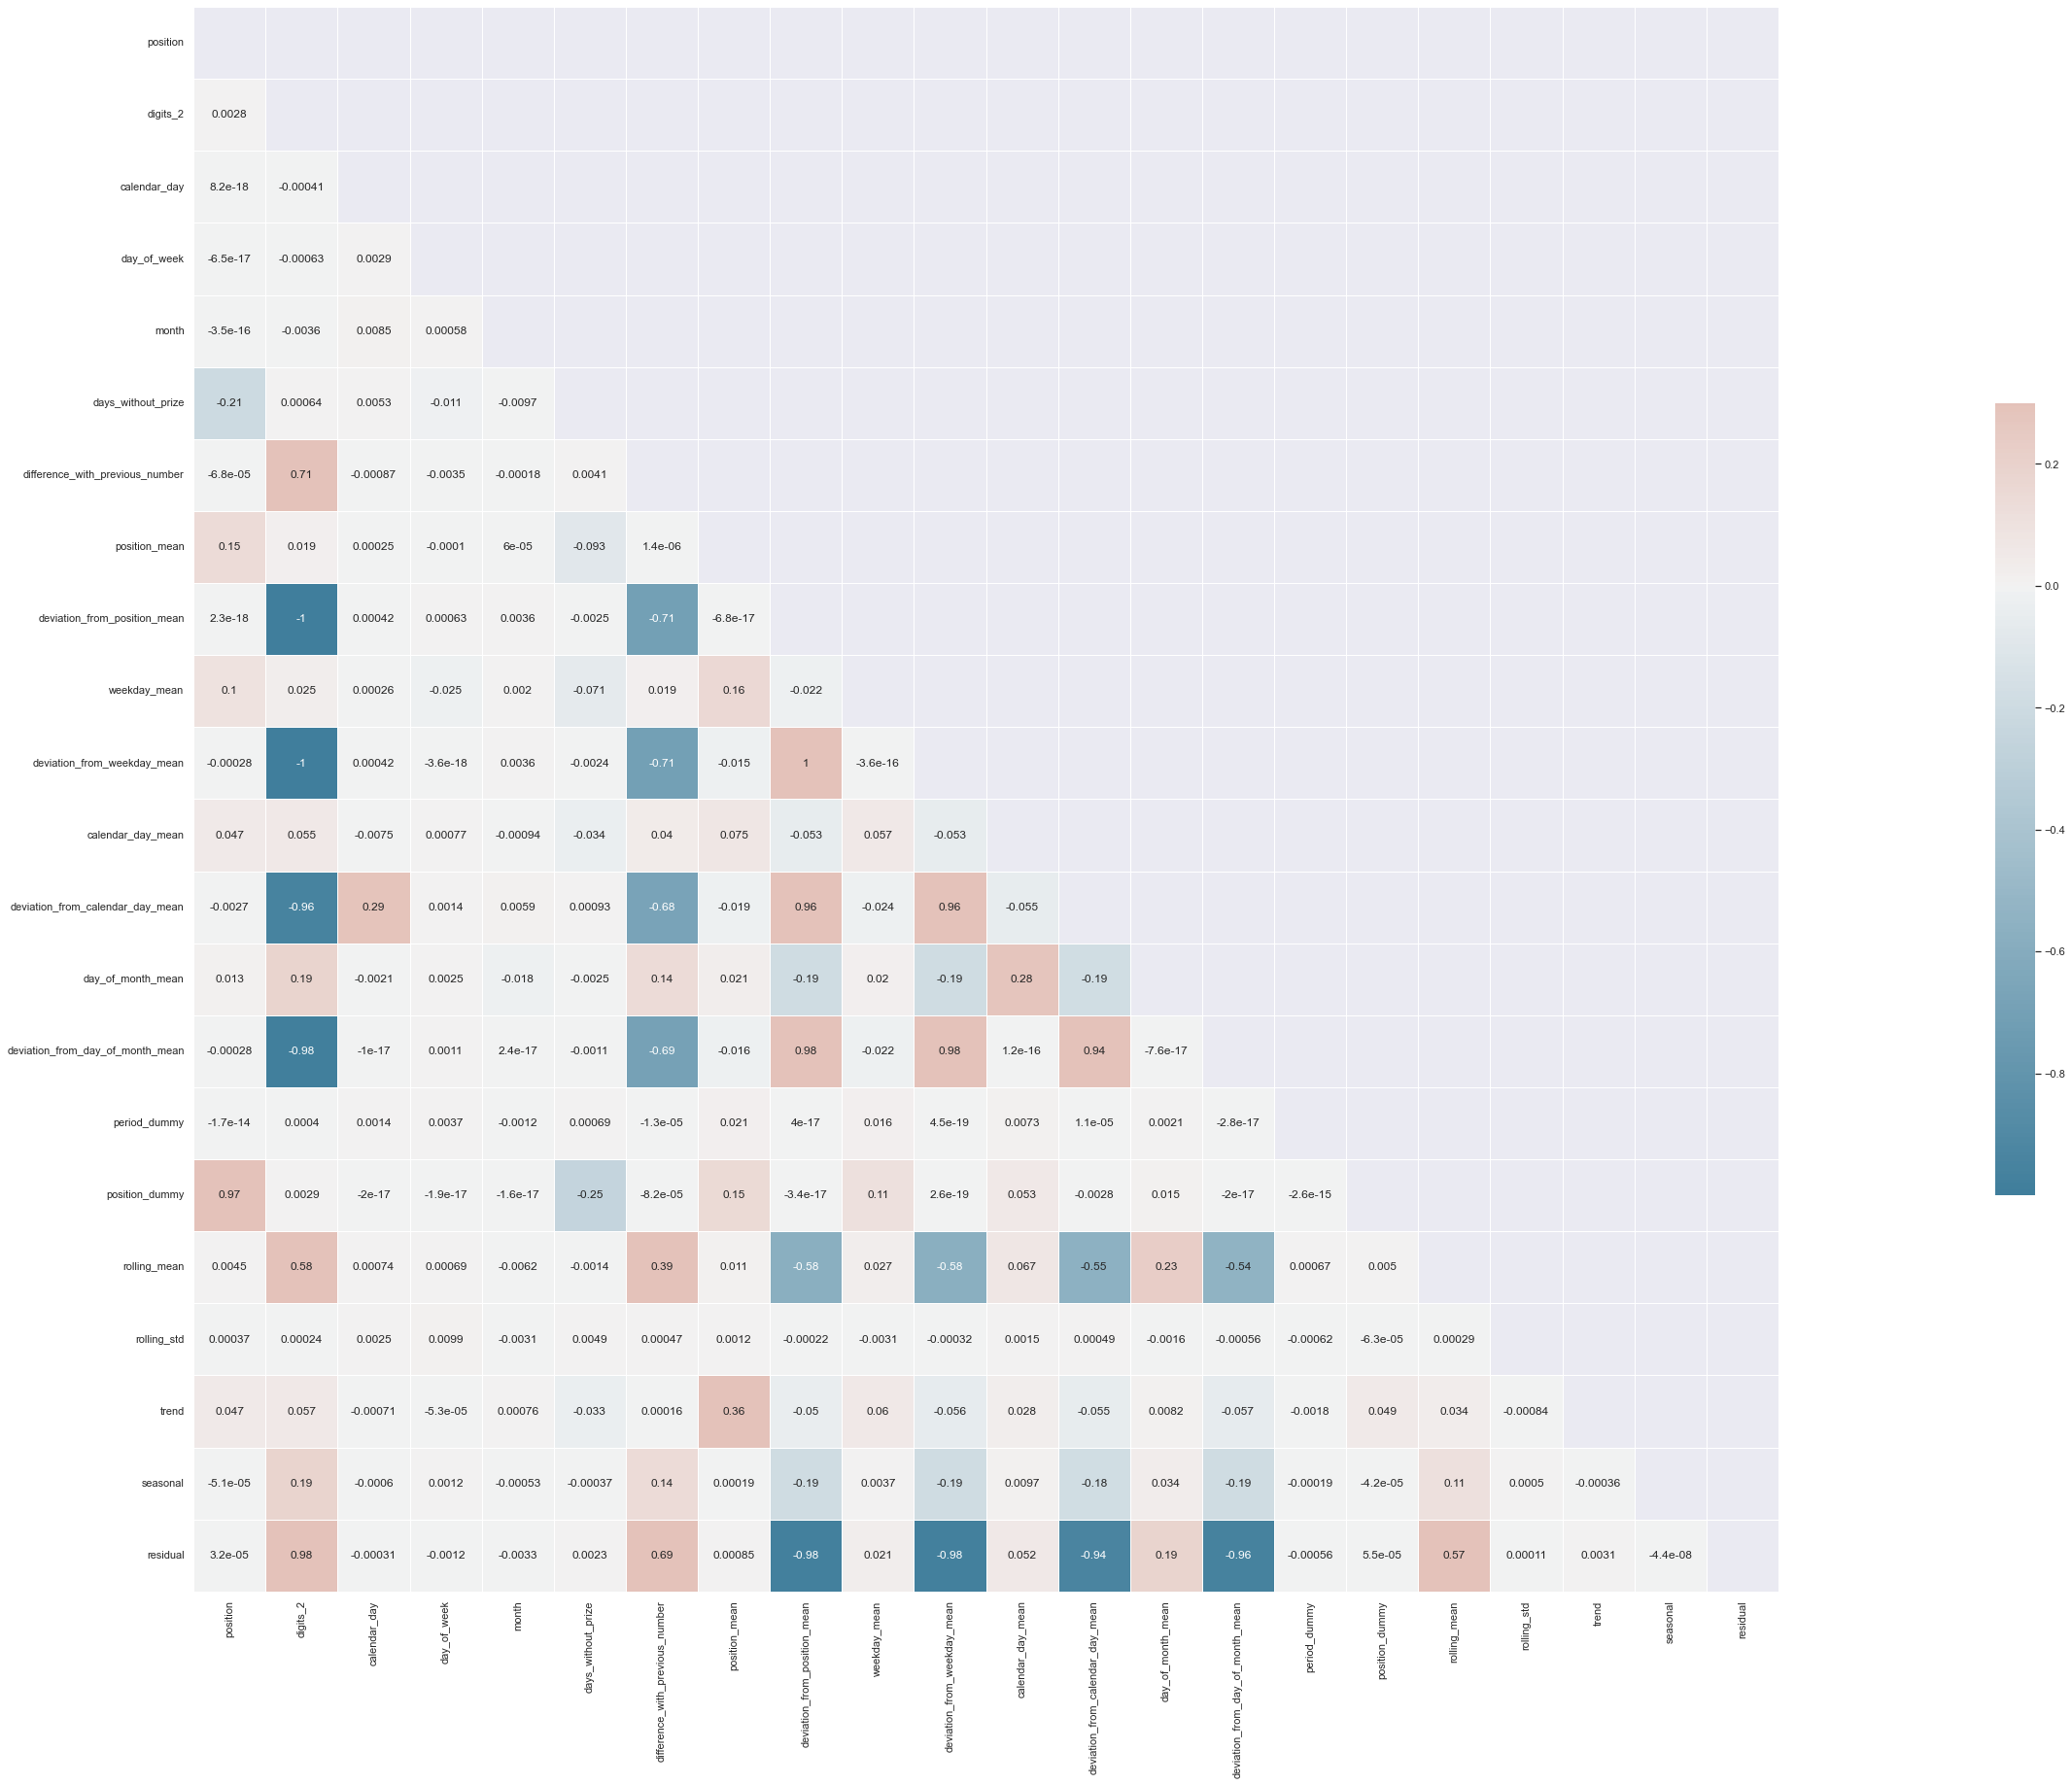

In [117]:
# Create the correlation matrix
corr = df_quiniela_2_digits.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the figure
fig, ax = plt.subplots(figsize=(80,30))
# Generate a custom diverging colormap
color_map = sns.diverging_palette(230, 20, as_cmap=True)
# Create the correlation matrix visual to be displayed
sns.heatmap(
    corr,
    mask=mask,
    cmap=color_map,
    vmax=.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': .5},
    annot=True
)